## $
TD(\lambda)
$ learning

Nicolas Cofre

Replication of Sutton 1988

In [731]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random


In [713]:
def bounded_random_walk_episode_simulator(N_states=7,s0=3,N_sim=10):
    training_set=[]
    for _ in range(N_sim):
        episode=[s0]
        current_state=s0
 
        while current_state not in [0,N_states-1]:
            if np.random.uniform()<0.5:
                current_state+=-1
 
            else:
                current_state+=1
 
            episode.append(current_state)
 
        training_set.append(episode)
   
    return training_set
 
 


In [714]:
def TD_update(episode,lambd,alpha,w,N_states=7,verbose=False):
    dw=np.zeros(N_states-2)
    if verbose: print('w0', w)
    if verbose: print('episode is ',episode)
    x_episode=[]*len(episode)
    w=np.array(w)
    
    for t in range(len(episode)-1):
        if verbose:print('t is ',t)
        x=np.zeros(N_states-2)
        xp=np.zeros(N_states-2)
        

        z=None
        if episode[t] not in [0,N_states-1]:
            x[episode[t]-1]=1
            x_episode.append(x)
            weighted_sum=np.zeros(N_states-2)
            
            if episode[t+1] not in [0,N_states-1]:

                xp[episode[t+1]-1]=1

                for k in range(0,t+1):
                    if verbose:print('k is ',k)
                    weighted_sum+=lambd**(t-k)*x_episode[k]
                    if verbose:print('x_episode[k]',x_episode[k])
                    if verbose:print('weighted_sum',weighted_sum)
                    if verbose:print('w',w)
                    if verbose: print('np.matmul(w.T,xp)',np.matmul(w.T,xp))
                    if verbose: print('np.matmul(w.T,x)',np.matmul(w.T,x))
                    if verbose: print('(w*xp-w*x)*weighted_sum',(w*xp-w*x)*weighted_sum)

                dw+=alpha*(np.matmul(w.T,xp)-np.matmul(w.T,x))*weighted_sum
            
            elif episode[t+1]==N_states-1:
                if verbose:print('right bound')

                z=1
                x[episode[t]-1]=1

                for k in range(0,t+1):
                    if verbose:print('k is ',k)
                    weighted_sum+=lambd**(t-k)*x_episode[k]
                    if verbose:print('x_episode[k]',x_episode[k])
                    if verbose:print('weighted_sum',weighted_sum)

                dw+=alpha*(z-np.matmul(w.T,x))*weighted_sum
            else:
                if verbose:print('left bound')
                z=0
                x[episode[t]-1]=1

                for k in range(0,t+1):
                    if verbose:print('k is ',k)

                    weighted_sum+=lambd**(t-k)*x_episode[k]
                    if verbose:print('x_episode[k]',x_episode[k])                    
                    if verbose:print('weighted_sum',weighted_sum)

                dw+=alpha*(z-np.matmul(w.T,x))*weighted_sum
            
            
        if verbose:print('x is ',x)
        if verbose:print('xp is ',xp)
        if verbose:print('weighted_sum is ',weighted_sum)
        if verbose:print('z is ',z)
        if verbose:print('dw is ',dw)
     
    
    return {'new_w': w+dw , 'w': w, 'dw':dw}
        


# Experiment 1

citing Sutton 1998:
    
    "update the weight vector after the complete presentation of a training set"

In [715]:
def compute_RSME(w,true_prob=[1/6,1/3,1/2,2/3,5/6]):
    return np.sqrt(np.sum((w-np.array(true_prob))**2)/len(w))
    

In [716]:
training_set=[[3,2,1,2,3,4,5,4,5,4,5,4,5,4,5,6],[3,4,5,4,3,2,1,0]]

In [717]:
# if we dont use a small alpha this diverges, just take a sequence with repeated visits to steps and see. Sum of x for same state makes the update explode

In [732]:
average_error=[]
std_error=[]
training_sets=[]
N_training_sets=100
set_lambdas=[0,0.3,0.5,0.7,0.9,1]
#set_lambdas=[0,0.3,1]
set_w=[]
random.seed(1)
for i in range(N_training_sets):
    training_sets.append(bounded_random_walk_episode_simulator(N_sim=10))

for lambdai in set_lambdas:
    #print('lambda is',lambdai)
    training_set_errors=[]

    for i in range(N_training_sets):
        #print('new training set ',i)
        #print(training_sets[i])
        training_set=training_sets[i]

        w=np.ones(5)*0
        dw=np.ones(5)*10
        while max(abs(dw))>0.00001:
            dw=np.zeros(5)
            for sequence_i in training_set:
                #print('sequence',sequence_i)
                TD_dic=TD_update(sequence_i,alpha=0.01,lambd=lambdai,w=w)
                #new_w=TD_dic['new_w']
                dw+=TD_dic['dw']

            #old_w=w.copy()
            w+=dw
            #print('dw is ',dw)
        set_w.append(w)
        #print('w is ',w)
            #print('old w is ',old_w)
            #print('conv test',np.sum((old_w-w)**2))
        #print('error is ',compute_RSME(w))
        training_set_errors.append(compute_RSME(w))
        #print('training set errors ',training_set_errors)

        #print('w is',w)

    average_error.append((lambdai,np.mean(training_set_errors)))
    std_error.append((lambdai,np.std(training_set_errors)))

average_error=np.array(average_error)
    

Text(0.5,0,'$\\lambda$')

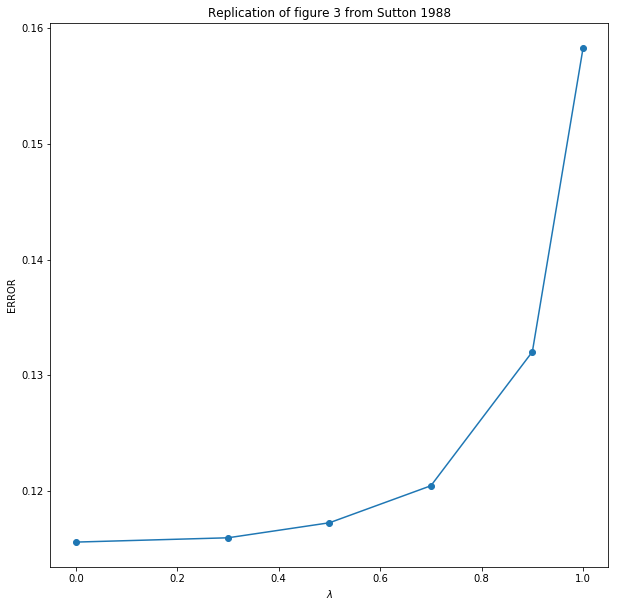

In [733]:
plt.figure(figsize=(10,10))
plt.plot(average_error[:,0],average_error[:,1],marker='o')
plt.title('Replication of figure 3 from Sutton 1988')
plt.ylabel('ERROR')
plt.xlabel(r'$\lambda$')

In [734]:
std_error

[(0, 0.06627987858985733),
 (0.3, 0.06679351687860863),
 (0.5, 0.06711199333582202),
 (0.7, 0.06819632863585291),
 (0.9, 0.07155759596424781),
 (1, 0.07931982644715645)]

# Experiment 2

In this case weight were updated after each sequence and training set presented only once

In [721]:
N_training_sets=100
training_sets=[]
for i in range(N_training_sets):
    training_sets.append(bounded_random_walk_episode_simulator(N_sim=10))

len(training_sets)

100

In [722]:
average_error_exp2=defaultdict(list)
std_error_exp2=defaultdict(list)
set_lambdas=[0,0.3,0.8,1]
set_alphas=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]
#set_lambdas=[0,0.3,1]
#set_alphas=[0,0.1,0.2,0.3,0.4]


for lambdai in set_lambdas:
    print('lambda is',lambdai)

    for alphai in set_alphas:
        print('alpha is',alphai)

        training_set_errors=[]

        
        for i in range(N_training_sets):
            print('training set ',i)
            training_set=training_sets[i]

            w=np.ones(5)*0.5

            for sequence_i in training_set:
                print('w',w)
                #print('sequence_i',sequence_i)
                TD_dic=TD_update(sequence_i,alpha=alphai,lambd=lambdai,w=w)
                #print('dw',TD_dic['dw'])
                w+=TD_dic['dw']


     
    
            training_set_errors.append(compute_RSME(w))
        
        # Used median to remove effect of extremely unlikely sequences
        average_error_exp2[lambdai].append((alphai,np.median(training_set_errors)))
            
        std_error_exp2[lambdai].append((alphai,np.std(training_set_errors)))

    

lambda is 0
alpha is 0
training set  0
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  1
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  2
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  3
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w

w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  45
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  46
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  47
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  48
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0

w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  85
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  86
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  87
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.

w [0.453625   0.49697406 0.50274094 0.52253906 0.59906484]
w [0.453625   0.49726241 0.5034425  0.53019164 0.61528531]
w [0.43312562 0.49289867 0.5031335  0.53019164 0.61528531]
training set  9
w [0.5 0.5 0.5 0.5 0.5]
w [0.475 0.5   0.5   0.5   0.5  ]
w [0.4525 0.4975 0.5    0.5    0.5   ]
w [0.45475  0.495375 0.499875 0.5      0.525   ]
w [0.4320125  0.49334375 0.49965    0.5        0.525     ]
w [0.4320125  0.49334375 0.4996675  0.50125    0.54875   ]
w [0.4320125  0.49397613 0.49919338 0.50829587 0.5665625 ]
w [0.4320125  0.49397613 0.50010363 0.51366741 0.58532104]
w [0.41041187 0.49149069 0.50054088 0.5194764  0.57815568]
w [0.41041187 0.49239571 0.50058264 0.52241036 0.5992479 ]
training set  10
w [0.5 0.5 0.5 0.5 0.5]
w [0.475 0.5   0.5   0.5   0.5  ]
w [0.475 0.5   0.5   0.5   0.525]
w [0.475  0.5    0.5    0.5025 0.5475]
w [0.475    0.5      0.500375 0.51125  0.563375]
w [0.475      0.50001875 0.50144375 0.51591875 0.5826    ]
w [0.475      0.50001875 0.5021675  0.51925281 0.60

w [0.475   0.5     0.5     0.50625 0.54375]
w [0.45125 0.49875 0.5     0.50625 0.54375]
w [0.45125   0.49875   0.500625  0.5096875 0.5646875]
w [0.45125    0.49884375 0.50098438 0.5124375  0.58645313]
w [0.45125    0.49884375 0.50155703 0.51613828 0.60713047]
w [0.43106719 0.49408438 0.50215043 0.51540922 0.60713047]
w [0.40951383 0.49093352 0.50241007 0.51474628 0.60713047]
training set  39
w [0.5 0.5 0.5 0.5 0.5]
w [0.475 0.5   0.5   0.5   0.5  ]
w [0.45125 0.49875 0.5     0.5     0.5    ]
w [0.45125 0.49875 0.5     0.5     0.525  ]
w [0.45125 0.49875 0.5     0.5025  0.5475 ]
w [0.4310625 0.4941875 0.49975   0.5025    0.5475   ]
w [0.4310625 0.4941875 0.4998875 0.50475   0.570125 ]
w [0.4310625  0.4941875  0.50013063 0.50801875 0.59161875]
w [0.4310625  0.4941875  0.50091944 0.52016434 0.60367781]
w [0.4310625  0.4945241  0.50154509 0.53686704 0.6109669 ]
training set  40
w [0.5 0.5 0.5 0.5 0.5]
w [0.475 0.5   0.5   0.5   0.5  ]
w [0.475 0.5   0.5   0.5   0.525]
w [0.475   0.5     0.

w [0.45125 0.49875 0.5     0.5     0.5    ]
w [0.4286875 0.496375  0.4999375 0.5       0.5      ]
w [0.4286875  0.496375   0.49994062 0.5        0.525     ]
w [0.4286875  0.49673156 0.49959    0.50124703 0.54875   ]
w [0.40725312 0.49347228 0.49930416 0.50124703 0.54875   ]
w [0.40725312 0.49347228 0.4994013  0.50837248 0.5665622 ]
w [0.38689047 0.48945777 0.4988084  0.50837248 0.5665622 ]
w [0.38689047 0.48945777 0.4992866  0.51128196 0.58823409]
training set  68
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.525]
w [0.475 0.5   0.5   0.5   0.525]
w [0.475   0.5     0.5     0.50125 0.54875]
w [0.45125 0.49875 0.5     0.50125 0.54875]
w [0.4286875 0.496375  0.4999375 0.50125   0.54875  ]
w [0.4286875  0.496375   0.50000312 0.503625   0.5713125 ]
w [0.4286875  0.49655641 0.50054609 0.50985047 0.5893625 ]
w [0.4286875  0.49655641 0.50194175 0.51289563 0.60989438]
w [0.4286875  0.49655641 0.50248944 0.51774557 0.62939966]
training set  69
w [0.5 0.5 0.5 0.5 0.5]
w [0.475 0.5   0.5  

w [0.475 0.5   0.5   0.5   0.5  ]
w [0.4525 0.4975 0.5    0.5    0.5   ]
w [0.4525 0.4975 0.5    0.5    0.525 ]
w [0.429875 0.49525  0.499875 0.5      0.525   ]
w [0.429875   0.49525    0.49988125 0.50125    0.54875   ]
w [0.40838125 0.49198125 0.49971813 0.50118156 0.54875   ]
w [0.39632219 0.48137547 0.49761658 0.50334047 0.54637158]
w [0.39632219 0.48137547 0.49818897 0.50520583 0.569053  ]
w [0.39632219 0.48305682 0.49756015 0.51408122 0.58421563]
training set  91
w [0.5 0.5 0.5 0.5 0.5]
w [0.475 0.5   0.5   0.5   0.5  ]
w [0.4525 0.4975 0.5    0.5    0.5   ]
w [0.429875 0.49525  0.499875 0.5      0.5     ]
w [0.40838125 0.49244375 0.4991875  0.49999375 0.5       ]
w [0.40838125 0.49244375 0.49922781 0.49999406 0.525     ]
w [0.38796219 0.48857983 0.49854941 0.49999406 0.525     ]
w [0.37359496 0.47851806 0.49819539 0.4998496  0.525     ]
w [0.38408727 0.47294509 0.49344148 0.50228193 0.54749248]
w [0.38408727 0.47294509 0.4938835  0.50454245 0.57011786]
training set  92
w [0.5 0.5

w [0.30990086 0.45213573 0.5031628  0.55036648 0.6306445 ]
training set  12
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.5  0.5  0.55]
w [0.5   0.5   0.5   0.505 0.595]
w [0.5    0.5    0.5005 0.514  0.6355]
w [0.5     0.5     0.50185 0.52615 0.67195]
w [0.5      0.500555 0.511015 0.54802  0.690175]
w [0.5       0.500555  0.5147155 0.5622355 0.7211575]
w [0.4500555  0.500444   0.51329945 0.5622355  0.7211575 ]
w [0.4201665  0.48414524 0.50815727 0.5622355  0.7211575 ]
w [0.37814985 0.48254977 0.50095366 0.5622355  0.7211575 ]
training set  13
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.5  0.5  0.55]
w [0.5   0.5   0.5   0.505 0.595]
w [0.5    0.5    0.503  0.5205 0.6265]
w [0.45    0.5012  0.50325 0.51875 0.6265 ]
w [0.45     0.5012   0.5048   0.529525 0.66385 ]
w [0.405    0.49608  0.50444  0.529525 0.66385 ]
w [0.373608  0.479536  0.5044405 0.540449  0.6504175]
w [0.3362472  0.4689432  0.5055509  0.53684815 0.6504175 ]
w [0.30262248 0.45933437 0.49822936 0.53684815 0.6504175 ]
training set  14


training set  43
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.5  0.5  0.55]
w [0.45 0.5  0.5  0.5  0.55]
w [0.45 0.5  0.5  0.51 0.59]
w [0.405 0.495 0.501 0.509 0.59 ]
w [0.3645 0.4872 0.5008 0.5074 0.59  ]
w [0.3645  0.4872  0.50146 0.51566 0.631  ]
w [0.3894   0.415006 0.500028 0.51424  0.631   ]
w [0.3555812 0.4073242 0.492947  0.5244948 0.619324 ]
w [0.33037168 0.40892586 0.47041494 0.52134002 0.619324  ]
training set  44
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.5  0.5  0.55]
w [0.45 0.5  0.5  0.5  0.55]
w [0.42 0.48 0.5  0.52 0.53]
w [0.378 0.474 0.498 0.52  0.53 ]
w [0.3498 0.4596 0.493  0.5178 0.53  ]
w [0.31482 0.44862 0.49214 0.51532 0.53   ]
w [0.283338 0.443944 0.486038 0.514238 0.524128]
w [0.283338  0.443944  0.488858  0.515227  0.5717152]
w [0.283338   0.443944   0.4914949  0.52087582 0.61454368]
training set  45
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.5  0.5  0.55]
w [0.5   0.5   0.5   0.505 0.595]
w [0.45  0.5   0.5   0.505 0.595]
w [0.41   0.49   0.5005 0.5045 0.595 ]
w [0.41  

w [0.45  0.5   0.5   0.505 0.545]
w [0.415 0.485 0.502 0.507 0.541]
w [0.415  0.4884 0.4991 0.5104 0.5869]
w [0.3735  0.48106 0.49803 0.5104  0.5869 ]
w [0.33615  0.475395 0.492479 0.509163 0.5869  ]
w [0.33615   0.4788118 0.4940674 0.5135999 0.62821  ]
w [0.302535   0.4691223  0.49382491 0.50774015 0.62821   ]
w [0.302535   0.4691223  0.49939101 0.5638005  0.61720106]
training set  74
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.5  0.5  0.55]
w [0.45 0.5  0.5  0.5  0.55]
w [0.41  0.49  0.5   0.505 0.545]
w [0.369  0.482  0.5005 0.5035 0.545 ]
w [0.369   0.48385 0.49895 0.50765 0.5905 ]
w [0.369    0.48536  0.50092  0.52161  0.623165]
w [0.369     0.48536   0.505058  0.5296965 0.6608485]
w [0.380636   0.4776636  0.5060461  0.55346305 0.68164845]
w [0.36197792 0.45423182 0.51175644 0.55205651 0.66882991]
training set  75
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.5  0.5  0.55]
w [0.5  0.5  0.5  0.51 0.59]
w [0.45 0.5  0.5  0.51 0.59]
w [0.405 0.495 0.5   0.51  0.59 ]
w [0.3825 0.468  0.5025 0.515

w [0.34992    0.46552356 0.48913646 0.5293     0.6679    ]
w [0.34992    0.46788485 0.49480788 0.55300365 0.68725   ]
alpha is 0.15
training set  0
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.575]
w [0.425   0.5     0.5     0.53375 0.54125]
w [0.36125 0.48875 0.5     0.53375 0.54125]
w [0.3453125 0.4364375 0.49325   0.53375   0.54125  ]
w [0.3453125 0.4364375 0.499325  0.534875  0.6100625]
w [0.35898125 0.46050125 0.4722575  0.574655   0.63471875]
w [0.40466525 0.421871   0.495923   0.56830494 0.68951094]
w [0.40466525 0.421871   0.50678029 0.58648584 0.7360843 ]
w [0.34396546 0.41929014 0.4940439  0.58648584 0.7360843 ]
training set  1
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.575]
w [0.5     0.5     0.5     0.51125 0.63875]
w [0.5       0.5       0.503375  0.5860625 0.6355625]
w [0.425      0.5010125  0.53906562 0.57112812 0.6132875 ]
w [0.43640187 0.50673453 0.52675109 0.58377594 0.66497047]
w [0.43640187 0.50673453 0.53530482 0.59595512 0.7152249 ]
w [0.43640187

w [0.3725 0.4775 0.5    0.5    0.5   ]
w [0.316625 0.465125 0.49325  0.5      0.5     ]
w [0.3389     0.44706875 0.49206875 0.497975   0.575     ]
w [0.3389     0.47406875 0.46595469 0.5210825  0.62719625]
w [0.3389     0.47406875 0.48249303 0.54464745 0.66719975]
w [0.35917531 0.45758436 0.49734843 0.55370713 0.71711979]
w [0.35917531 0.45758436 0.51425604 0.56976523 0.75955182]
w [0.35917531 0.46608512 0.52240805 0.58990684 0.79561905]
training set  27
w [0.5 0.5 0.5 0.5 0.5]
w [0.425 0.5   0.5   0.5   0.5  ]
w [0.425 0.5   0.5   0.5   0.575]
w [0.425  0.5    0.5    0.5225 0.6275]
w [0.425    0.5      0.503375 0.53825  0.683375]
w [0.425      0.5        0.50860625 0.56001875 0.73086875]
w [0.36125    0.49004094 0.52144813 0.5702225  0.70524125]
w [0.36125    0.49475202 0.53868552 0.61634862 0.70894944]
w [0.36125    0.49475202 0.55033498 0.63023875 0.75260702]
w [0.36125    0.49475202 0.56232055 0.64859399 0.78971597]
training set  28
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5 

w [0.45875 0.46625 0.5     0.5     0.575  ]
w [0.3899375 0.4701875 0.489875  0.5       0.575    ]
w [0.3899375  0.47314062 0.48844063 0.51125    0.63875   ]
w [0.33144687 0.46066016 0.48956703 0.52695359 0.619625  ]
w [0.28172984 0.44127816 0.485231   0.52695359 0.619625  ]
w [0.23947037 0.42393884 0.47204515 0.52695359 0.619625  ]
w [0.23947037 0.42393884 0.48028142 0.55475502 0.66278054]
w [0.23947037 0.42393884 0.49145246 0.57095884 0.71336346]
training set  53
w [0.5 0.5 0.5 0.5 0.5]
w [0.425 0.5   0.5   0.5   0.5  ]
w [0.43625 0.48875 0.5     0.5     0.575  ]
w [0.3708125 0.48425   0.4949375 0.5       0.575    ]
w [0.3708125  0.48425    0.49645625 0.52174062 0.6275    ]
w [0.3708125  0.48425    0.50783422 0.53001922 0.683375  ]
w [0.3708125  0.48778763 0.50762434 0.55302259 0.73086875]
w [0.3708125  0.49076314 0.53869752 0.68584518 0.63785381]
w [0.3888051  0.4799607  0.55357951 0.67864648 0.69217574]
w [0.3888051  0.51308916 0.55797114 0.66191582 0.73834938]
training set  54
w [0

w [0.316625 0.471875 0.4865   0.5      0.5     ]
w [0.29241875 0.4253     0.48430625 0.5        0.5       ]
w [0.29241875 0.4253     0.48666031 0.5        0.575     ]
w [0.26848813 0.38543563 0.47745627 0.5        0.575     ]
w [0.26848813 0.41304182 0.45661319 0.51911844 0.6275    ]
w [0.26848813 0.41304182 0.46598898 0.53537567 0.683375  ]
w [0.24989796 0.36967571 0.45804691 0.53537567 0.683375  ]
training set  83
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.575]
w [0.5    0.5    0.5    0.5225 0.6275]
w [0.5      0.5      0.510125 0.5315   0.683375]
w [0.5        0.50151875 0.5118125  0.55428125 0.73086875]
w [0.42568344 0.50215156 0.50872438 0.55428125 0.73086875]
w [0.38477136 0.46872683 0.51358606 0.54744772 0.73086875]
w [0.32705566 0.45613351 0.51193643 0.54236847 0.73086875]
w [0.27799731 0.44514227 0.49519555 0.54236847 0.73086875]
w [0.27799731 0.44514227 0.50227149 0.57064351 0.77123844]
training set  84
w [0.5 0.5 0.5 0.5 0.5]
w [0.425 0.5   0.5   0.5   0.5  ]
w [0.

w [0.1728512  0.34117274 0.46107597 0.58347571 0.65565338]
training set  8
w [0.5 0.5 0.5 0.5 0.5]
w [0.4 0.5 0.5 0.5 0.5]
w [0.4 0.5 0.5 0.5 0.6]
w [0.4  0.5  0.5  0.56 0.64]
w [0.32 0.48 0.5  0.56 0.64]
w [0.32  0.48  0.524 0.58  0.696]
w [0.32   0.48   0.5352 0.6264 0.7336]
w [0.352   0.51424 0.54192 0.636   0.744  ]
w [0.352    0.519776 0.5552   0.6792   0.7736  ]
w [0.3151552 0.4526656 0.5481152 0.6792    0.7736   ]
training set  9
w [0.5 0.5 0.5 0.5 0.5]
w [0.4 0.5 0.5 0.5 0.5]
w [0.34 0.46 0.5  0.5  0.5 ]
w [0.364 0.444 0.492 0.5   0.6  ]
w [0.2912 0.428  0.4824 0.5    0.6   ]
w [0.2912  0.428   0.48592 0.52    0.68   ]
w [0.2912   0.451168 0.476384 0.609184 0.68    ]
w [0.2912    0.451168  0.529504  0.6109504 0.7298368]
w [0.23296    0.4505088  0.51508096 0.6259264  0.68228224]
w [0.23296    0.47633766 0.51142118 0.63719757 0.74582579]
training set  10
w [0.5 0.5 0.5 0.5 0.5]
w [0.4 0.5 0.5 0.5 0.5]
w [0.4 0.5 0.5 0.5 0.6]
w [0.4  0.5  0.5  0.54 0.66]
w [0.4   0.5   0.524 0.62 

w [0.32       0.44858061 0.5121152  0.68278656 0.80403584]
training set  34
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.6]
w [0.5  0.5  0.5  0.52 0.68]
w [0.4  0.5  0.5  0.52 0.68]
w [0.4   0.5   0.516 0.604 0.68 ]
w [0.32   0.48   0.5128 0.604  0.68  ]
w [0.352   0.49392 0.53984 0.61008 0.6984 ]
w [0.309984 0.437152 0.530656 0.61008  0.6984  ]
w [0.309984  0.437152  0.5624256 0.6118592 0.75872  ]
w [0.2479872  0.46182784 0.49714816 0.60197248 0.75872   ]
training set  35
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.6]
w [0.4 0.5 0.5 0.5 0.6]
w [0.42 0.48 0.5  0.56 0.64]
w [0.336 0.468 0.52  0.552 0.624]
w [0.3624 0.4832 0.5168 0.5344 0.6992]
w [0.3624  0.4832  0.52384 0.56384 0.75936]
w [0.3624   0.4832   0.53184  0.602944 0.807488]
w [0.3624    0.492928  0.5363328 0.6438528 0.8459904]
w [0.3624     0.492928   0.5578368  0.68428032 0.87679232]
training set  36
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.6]
w [0.4 0.5 0.5 0.5 0.6]
w [0.36 0.44 0.5  0.5  0.6 ]
w [0.36 0.44 0.5  0.52 0

w [0.3696  0.44368 0.50864 0.6064  0.7696 ]
w [0.36976  0.406752 0.502336 0.580384 0.73696 ]
w [0.3032064 0.411072  0.4641024 0.580384  0.73696  ]
w [0.3032064  0.43228416 0.55917184 0.54998912 0.7582528 ]
training set  67
w [0.5 0.5 0.5 0.5 0.5]
w [0.4 0.5 0.5 0.5 0.5]
w [0.32 0.48 0.5  0.5  0.5 ]
w [0.256 0.448 0.496 0.5   0.5  ]
w [0.256  0.448  0.4968 0.5    0.6   ]
w [0.256   0.46752 0.47856 0.51936 0.68   ]
w [0.2048   0.427424 0.474144 0.51936  0.68    ]
w [0.2048    0.427424  0.4831872 0.615744  0.679744 ]
w [0.16384    0.39405184 0.46088192 0.615744   0.679744  ]
w [0.16384    0.39405184 0.49185434 0.628544   0.7437952 ]
training set  68
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.6]
w [0.4 0.5 0.5 0.5 0.6]
w [0.4  0.5  0.5  0.52 0.68]
w [0.32 0.48 0.5  0.52 0.68]
w [0.256 0.448 0.496 0.52  0.68 ]
w [0.256  0.448  0.5008 0.552  0.744 ]
w [0.256   0.45856 0.5312  0.59808 0.7568 ]
w [0.256    0.45856  0.571328 0.603072 0.80544 ]
w [0.256     0.45856   0.5776768 0.6435456 0.8443

w [0.2304  0.41216 0.50464 0.63904 0.616  ]
w [0.2304   0.449152 0.575168 0.544576 0.702016]
w [0.2304    0.4743552 0.5254912 0.6888832 0.6671488]
training set  95
w [0.5 0.5 0.5 0.5 0.5]
w [0.4 0.5 0.5 0.5 0.5]
w [0.4 0.5 0.5 0.5 0.6]
w [0.34 0.46 0.5  0.5  0.6 ]
w [0.296 0.412 0.492 0.5   0.6  ]
w [0.26   0.3976 0.4488 0.5152 0.58  ]
w [0.28752 0.4008  0.4712  0.5272  0.62512]
w [0.230016 0.378144 0.46832  0.516    0.62512 ]
w [0.2892672 0.336928  0.4788928 0.5624    0.656448 ]
w [0.23141376 0.32739584 0.48390272 0.52899712 0.656448  ]
training set  96
w [0.5 0.5 0.5 0.5 0.5]
w [0.4 0.5 0.5 0.5 0.5]
w [0.4 0.5 0.5 0.5 0.6]
w [0.32 0.48 0.5  0.5  0.6 ]
w [0.288 0.416 0.496 0.5   0.6  ]
w [0.2816 0.3552 0.464  0.5    0.6   ]
w [0.2816 0.3552 0.4712 0.52   0.68  ]
w [0.22528 0.34048 0.448   0.52    0.68   ]
w [0.180224 0.31744  0.455296 0.5872   0.584   ]
w [0.1716224 0.2625536 0.4277248 0.5872    0.584    ]
training set  97
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.6]
w [0.4 0.5 0.5

w [0.17138672 0.42126465 0.50427246 0.63256836 0.73608398]
w [0.2338562  0.42105103 0.53823853 0.62017822 0.77618408]
training set  23
w [0.5 0.5 0.5 0.5 0.5]
w [0.375 0.5   0.5   0.5   0.5  ]
w [0.28125 0.46875 0.5     0.5     0.5    ]
w [0.2109375 0.4375    0.4765625 0.5       0.5      ]
w [0.2109375  0.44726562 0.47851562 0.49414062 0.625     ]
w [0.27001953 0.39599609 0.47460938 0.52685547 0.71875   ]
w [0.20251465 0.40380859 0.45483398 0.4876709  0.71875   ]
w [0.35317993 0.22872925 0.36553955 0.4876709  0.71875   ]
w [0.26488495 0.29404449 0.2971344  0.4876709  0.71875   ]
w [0.26488495 0.29404449 0.44003677 0.62348175 0.61575317]
training set  24
w [0.5 0.5 0.5 0.5 0.5]
w [0.375 0.5   0.5   0.5   0.5  ]
w [0.4375 0.4375 0.5    0.5    0.625 ]
w [0.4375   0.453125 0.484375 0.59375  0.65625 ]
w [0.4375     0.453125   0.51171875 0.609375   0.7421875 ]
w [0.328125   0.44921875 0.49707031 0.609375   0.7421875 ]
w [0.41894531 0.41821289 0.52148438 0.68603516 0.70703125]
w [0.31420898 0

w [0.40625 0.46875 0.5     0.5625  0.6875 ]
w [0.40625  0.46875  0.53125  0.640625 0.703125]
w [0.3046875 0.453125  0.515625  0.640625  0.703125 ]
w [0.3046875  0.46875    0.53125    0.65625    0.77734375]
w [0.3046875  0.46875    0.5625     0.68652344 0.83300781]
w [0.34570312 0.45117188 0.63208008 0.66113281 0.87475586]
w [0.25927734 0.47003174 0.54888916 0.65386963 0.87475586]
training set  48
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.625]
w [0.375 0.5   0.5   0.5   0.625]
w [0.375   0.5     0.5     0.53125 0.71875]
w [0.375     0.5       0.5078125 0.578125  0.7890625]
w [0.375      0.50195312 0.5234375  0.63085938 0.84179688]
w [0.375      0.50732422 0.57177734 0.65673828 0.88134766]
w [0.31433105 0.45727539 0.58203125 0.61425781 0.88134766]
w [0.23574829 0.42153931 0.55084229 0.61425781 0.88134766]
w [0.23574829 0.42153931 0.56669617 0.74780273 0.84423828]
training set  49
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.625]
w [0.375 0.5   0.5   0.5   0.625]
w [0.3

w [0.23291016 0.21533203 0.44384766 0.54980469 0.68115234]
w [0.23291016 0.21533203 0.47033691 0.5826416  0.76086426]
training set  72
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.625]
w [0.375 0.5   0.5   0.5   0.625]
w [0.375  0.5    0.5    0.5625 0.6875]
w [0.3125 0.4375 0.5    0.5625 0.6875]
w [0.265625 0.375    0.484375 0.5625   0.6875  ]
w [0.265625   0.375      0.50390625 0.59375    0.765625  ]
w [0.29296875 0.37988281 0.51660156 0.61425781 0.82421875]
w [0.29296875 0.37988281 0.54101562 0.71923828 0.81567383]
w [0.21972656 0.3581543  0.50073242 0.71923828 0.81567383]
training set  73
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.625]
w [0.375   0.5     0.5     0.53125 0.59375]
w [0.34375  0.40625  0.53125  0.515625 0.578125]
w [0.34375    0.46875    0.46484375 0.53125    0.68359375]
w [0.2578125  0.4375     0.46582031 0.53125    0.68359375]
w [0.19335938 0.41381836 0.45385742 0.51489258 0.68359375]
w [0.19335938 0.43383789 0.47961426 0.52655029 0.76269531]
w [0.1

w [0.3607352  0.2015456  0.51819314 0.6354932  0.85643   ]
training set  1
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.5  0.5  0.65]
w [0.5   0.5   0.5   0.545 0.755]
w [0.5    0.5    0.527  0.7835 0.6395]
w [0.35    0.5162  0.73355 0.42305 0.7691 ]
w [0.39986  0.661955 0.444785 0.63068  0.734555]
w [0.39986   0.661955  0.5005535 0.6618425 0.8141885]
w [0.39986    0.661955   0.5489402  0.7075463  0.86993195]
w [0.279902   0.5833265  0.58284464 0.7075463  0.86993195]
w [0.279902   0.58318194 0.65781019 0.76756719 0.86023667]
training set  2
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.5  0.5  0.65]
w [0.35 0.5  0.5  0.5  0.65]
w [0.35  0.5   0.5   0.635 0.665]
w [0.29  0.41  0.5   0.635 0.665]
w [0.29   0.41   0.5405 0.644  0.7655]
w [0.29    0.44915 0.7187  0.6035  0.7265 ]
w [0.29     0.530015 0.603275 0.6404   0.80855 ]
w [0.29      0.530015  0.6144125 0.690845  0.865985 ]
w [0.29       0.530015   0.63734225 0.743387   0.9061895 ]
training set  3
w [0.5 0.5 0.5 0.5 0.5]
w [0.35 0.5  0.5  0.5  0

w [0.5    0.5    0.554  0.6305 0.7655]
w [0.5     0.5     0.57695 0.7115  0.79535]
w [0.5      0.5      0.73841  0.66587  0.806435]
w [0.35     0.571523 0.595364 0.66587  0.806435]
w [0.245     0.5050661 0.5882117 0.66587   0.806435 ]
w [0.1715     0.42704627 0.56326802 0.66587    0.806435  ]
w [0.1715     0.42704627 0.6556098  0.64647831 0.8645045 ]
training set  32
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.5  0.5  0.65]
w [0.35 0.5  0.5  0.5  0.65]
w [0.44  0.41  0.5   0.635 0.665]
w [0.44   0.437  0.5135 0.644  0.7655]
w [0.44    0.437   0.5918  0.6413  0.83585]
w [0.308   0.53078 0.51188 0.69863 0.71912]
w [0.374834 0.452606 0.63527  0.648752 0.803384]
w [0.374834  0.452606  0.6393146 0.6951416 0.8623688]
w [0.3981656  0.54129956 0.56078564 0.87906614 0.75315368]
training set  33
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.5  0.5  0.65]
w [0.5   0.5   0.5   0.545 0.755]
w [0.5    0.5    0.527  0.6575 0.7655]
w [0.5     0.5     0.56615 0.7223  0.80345]
w [0.35     0.5      0.546305 0.7223  

w [0.35 0.5  0.5  0.5  0.5 ]
w [0.245 0.455 0.5   0.5   0.5  ]
w [0.245  0.4685 0.4865 0.5    0.65  ]
w [0.245   0.4793  0.49595 0.7088  0.575  ]
w [0.245    0.4793   0.559805 0.66866  0.7025  ]
w [0.245     0.4793    0.5924615 0.678812  0.79175  ]
w [0.1715     0.44295845 0.5245646  0.678812   0.79175   ]
w [0.1715     0.49192214 0.56814935 0.66641918 0.854225  ]
w [0.12005    0.3957955  0.54528119 0.66641918 0.854225  ]
training set  57
w [0.5 0.5 0.5 0.5 0.5]
w [0.35 0.5  0.5  0.5  0.5 ]
w [0.29 0.41 0.5  0.5  0.5 ]
w [0.239 0.392 0.419 0.5   0.5  ]
w [0.3968 0.1652 0.5567 0.3056 0.5   ]
w [0.3968  0.4001  0.09581 0.5729  0.59168]
w [0.27776  0.39911  0.473351 0.286646 0.59168 ]
w [0.194432  0.3849773 0.4288064 0.286646  0.59168  ]
w [0.1361024  0.34096244 0.40250894 0.286646   0.59168   ]
w [0.09527168 0.27950443 0.38404499 0.286646   0.59168   ]
training set  58
w [0.5 0.5 0.5 0.5 0.5]
w [0.35 0.5  0.5  0.5  0.5 ]
w [0.245 0.455 0.5   0.5   0.5  ]
w [0.2345 0.3425 0.473  0.5    0.

w [0.5     0.5     0.54185 0.7403  0.8138 ]
w [0.35     0.537665 0.551165 0.680765 0.8138  ]
w [0.245     0.4854155 0.543065  0.680765  0.8138   ]
w [0.245     0.4854155 0.625685  0.6793655 0.86966  ]
w [0.245      0.52749635 0.64802075 0.74522975 0.85167365]
w [0.1715     0.44274744 0.67018883 0.68690435 0.85167365]
training set  88
w [0.5 0.5 0.5 0.5 0.5]
w [0.35 0.5  0.5  0.5  0.5 ]
w [0.335 0.365 0.5   0.5   0.5  ]
w [0.335 0.365 0.5   0.5   0.65 ]
w [0.2345 0.3965 0.419  0.5    0.65  ]
w [0.2345 0.3965 0.4433 0.545  0.755 ]
w [0.16415 0.3479  0.52079 0.45347 0.755  ]
w [0.439775 0.435344 0.016349 0.665105 0.8285  ]
w [0.439775  0.435344  0.2109758 0.7141235 0.87995  ]
w [0.439775   0.435344   0.36192011 0.76387145 0.915965  ]
training set  89
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.5  0.5  0.65]
w [0.35  0.5   0.5   0.545 0.605]
w [0.245  0.455  0.5135 0.5315 0.605 ]
w [0.245   0.47255 0.50675 0.59225 0.6794 ]
w [0.239765 0.38732  0.62474  0.491135 0.600965]
w [0.239765  0.38732   

w [0.325      0.5        0.52786875 0.65925    0.822875  ]
w [0.325      0.5        0.57385219 0.7737875  0.8276    ]
w [0.325      0.5        0.71380691 0.72264452 0.88794   ]
w [0.325      0.5        0.71690007 0.78049794 0.927161  ]
w [0.325      0.5        0.76141858 0.80957075 0.95265465]
w [0.325      0.5914965  0.7036286  0.89287622 0.91914616]
training set  16
w [0.5 0.5 0.5 0.5 0.5]
w [0.325 0.5   0.5   0.5   0.5  ]
w [0.325 0.5   0.5   0.5   0.675]
w [0.2725 0.3775 0.5    0.5    0.675 ]
w [0.177125 0.34075  0.457125 0.5      0.675   ]
w [0.177125   0.38148125 0.47641875 0.57748125 0.7275    ]
w [0.24864969 0.34318469 0.51393438 0.6471225  0.77036844]
w [0.24864969 0.34318469 0.56055022 0.69025858 0.85073948]
w [0.24864969 0.34318469 0.60594814 0.7464269  0.90298066]
w [0.2277968  0.33589015 0.47118129 0.69725933 0.90298066]
training set  17
w [0.5 0.5 0.5 0.5 0.5]
w [0.325 0.5   0.5   0.5   0.5  ]
w [0.21125 0.43875 0.5     0.5     0.5    ]
w [0.21125  0.481625 0.457125 0.5  

w [0.2169375  0.3438125  0.66577619 0.83408659 0.80731969]
w [0.2169375  0.45649979 0.61199754 0.79661292 0.90286305]
training set  40
w [0.5 0.5 0.5 0.5 0.5]
w [0.325 0.5   0.5   0.5   0.5  ]
w [0.325 0.5   0.5   0.5   0.675]
w [0.325   0.5     0.5     0.56125 0.78875]
w [0.2725  0.3775  0.5     0.56125 0.78875]
w [0.213875 0.304    0.457125 0.56125  0.78875 ]
w [0.213875   0.4111875  0.45926875 0.5679875  0.8626875 ]
w [0.13901875 0.34212813 0.44244031 0.5679875  0.8626875 ]
w [0.16145047 0.23506083 0.46010481 0.58324947 0.7595425 ]
w [0.16145047 0.23506083 0.50320544 0.64495203 0.84370263]
training set  41
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.675]
w [0.5     0.5     0.5     0.56125 0.78875]
w [0.325   0.5     0.5     0.56125 0.78875]
w [0.21125   0.43875   0.5214375 0.5398125 0.78875  ]
w [0.21125    0.43875    0.52786875 0.62694063 0.8626875 ]
w [0.1373125  0.359125   0.49667719 0.62694063 0.8626875 ]
w [0.1668875  0.39642931 0.34714527 0.53575622 0.8626875 ]
w [0.1

w [0.25393661 0.43029014 0.62073075 0.56821567 0.79469155]
training set  67
w [0.5 0.5 0.5 0.5 0.5]
w [0.325 0.5   0.5   0.5   0.5  ]
w [0.21125 0.43875 0.5     0.5     0.5    ]
w [0.1373125 0.359125  0.4785625 0.5       0.5      ]
w [0.1373125  0.359125   0.48606563 0.5        0.675     ]
w [0.1373125  0.44798344 0.40696125 0.55637297 0.78875   ]
w [0.08925313 0.32489084 0.43567678 0.55637297 0.78875   ]
w [0.08925313 0.32489084 0.47792045 0.80036885 0.70002358]
w [0.05801453 0.295978   0.37079972 0.80036885 0.70002358]
w [0.05801453 0.295978   0.52114892 0.76524801 0.80501533]
training set  68
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.675]
w [0.325 0.5   0.5   0.5   0.675]
w [0.325   0.5     0.5     0.56125 0.78875]
w [0.21125 0.43875 0.5     0.56125 0.78875]
w [0.1373125 0.359125  0.4785625 0.56125   0.78875  ]
w [0.1373125  0.359125   0.50750313 0.640875   0.8626875 ]
w [0.1373125  0.41105734 0.64229141 0.65610328 0.8331125 ]
w [0.1373125  0.41105734 0.65679388 0.7083882

w [0.2510625  0.83304687 0.62005    0.29772188 0.63560313]
w [0.2510625  0.75849797 0.35615437 0.64161    0.76314203]
w [ 0.87360028 -1.39689642  1.96417589  0.48432727  0.72060582]
w [ 0.56784018 -0.60222258  0.78780058  0.48432727  0.72060582]
w [ 0.36909612 -0.19270061  0.19507682  0.67324042  0.63790833]
training set  98
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.675]
w [0.5     0.5     0.5     0.68375 0.66625]
w [0.325     0.5       0.5643125 0.6194375 0.66625  ]
w [0.325      0.5        0.6029     0.61652812 0.7830625 ]
w [0.325      0.5        0.60766984 0.67481516 0.85899063]
w [0.325      0.53768445 0.61698712 0.78023712 0.84388249]
w [0.21125    0.46324489 0.64636868 0.72309962 0.84388249]
w [0.21125    0.46324489 0.70008034 0.7385178  0.89852362]
w [0.49010535 0.18803865 0.47830934 0.76761362 0.84252158]
training set  99
w [0.5 0.5 0.5 0.5 0.5]
w [0.325 0.5   0.5   0.5   0.5  ]
w [0.21125 0.43875 0.5     0.5     0.5    ]
w [0.450125 0.285625 0.41425  0.5      0.675

w [0.3 0.5 0.5 0.5 0.5]
w [0.3 0.5 0.5 0.5 0.7]
w [0.34 0.26 0.5  0.5  0.7 ]
w [ 0.108  0.868 -0.076  0.58   0.62 ]
w [ 0.9768 -1.4808  2.484  -0.4536  0.604 ]
w [ 0.58608  5.84592 -7.79568  1.89648  0.604  ]
w [ 0.58608   5.84592  -3.918816  1.379488  0.7624  ]
w [ 2.690016  -0.1639104  2.1064     0.8858176  1.1042752]
w [ 2.690016   -0.1639104   0.64170112  2.12443264  0.88779904]
training set  26
w [0.5 0.5 0.5 0.5 0.5]
w [0.3 0.5 0.5 0.5 0.5]
w [0.26 0.34 0.5  0.5  0.5 ]
w [0.156 0.372 0.372 0.5   0.5  ]
w [0.2424 0.2856 0.5256 0.3976 0.7   ]
w [0.2424  0.6696  0.0904  0.63952 0.69904]
w [0.2424   0.6696   0.529696 0.467488 0.795616]
w [0.41328   0.3308352 0.6478144 0.6236224 0.8773696]
w [0.41328    0.3308352  0.6284608  0.73479808 0.92642176]
w [0.41328    0.44988544 0.59448038 0.76891264 0.95585306]
training set  27
w [0.5 0.5 0.5 0.5 0.5]
w [0.3 0.5 0.5 0.5 0.5]
w [0.3 0.5 0.5 0.5 0.7]
w [0.3  0.5  0.5  0.66 0.74]
w [0.3   0.5   0.564 0.692 0.844]
w [0.3    0.5    0.6152 0.7528

w [0.3 0.5 0.5 0.5 0.5]
w [0.38 0.42 0.5  0.5  0.7 ]
w [0.228 0.468 0.404 0.5   0.7  ]
w [0.228  0.468  0.4808 0.6216 0.74  ]
w [0.228   0.468   0.64976 0.55632 0.844  ]
w [0.228    0.540704 0.53968  0.671392 0.9064  ]
w [0.228     0.5402944 0.8035136 1.024672  0.473824 ]
w [0.35291776 0.52066432 0.78668928 0.8043328  0.6842944 ]
w [0.35291776 0.83989427 0.48157414 0.74926003 0.81057664]
training set  54
w [0.5 0.5 0.5 0.5 0.5]
w [0.3 0.5 0.5 0.5 0.5]
w [0.38 0.42 0.5  0.5  0.7 ]
w [0.244 0.42  0.436 0.5   0.7  ]
w [0.1464 0.356  0.4232 0.5    0.7   ]
w [0.08784 0.27216 0.39632 0.5     0.7    ]
w [0.161568 0.29776  0.379936 0.618528 0.74    ]
w [0.1514176 0.3531584 0.7553344 0.2402624 0.5456448]
w [0.17154688 0.19176576 0.3884352  0.56844416 0.42349184]
w [0.18772198 0.33292621 0.37510682 0.32249779 0.77005696]
training set  55
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.7]
w [0.5  0.5  0.5  0.74 0.66]
w [0.5   0.5   0.596 0.676 0.828]
w [0.3    0.6152 0.5384 0.58   0.828 ]
w [0.3    

training set  76
w [0.5 0.5 0.5 0.5 0.5]
w [0.3 0.5 0.5 0.5 0.5]
w [0.3 0.5 0.5 0.5 0.7]
w [0.18 0.42 0.5  0.5  0.7 ]
w [0.18 0.42 0.5  0.74 0.66]
w [0.108 0.324 0.468 0.74  0.66 ]
w [0.1512 0.4968 0.3912 0.4136 0.66  ]
w [0.1512  0.45456 0.4424  0.51216 0.796  ]
w [0.09072  0.328352 0.452128 0.51216  0.796   ]
w [0.054432  0.2332992 0.4506432 0.4641344 0.796    ]
training set  77
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.7]
w [0.3 0.5 0.5 0.5 0.7]
w [0.18 0.42 0.5  0.5  0.7 ]
w [0.204 0.292 0.404 0.58  0.62 ]
w [0.204  0.292  0.6856 0.4008 0.756 ]
w [0.1224  0.57168 0.09936 0.51472 0.756  ]
w [ 0.612576 -1.280736  1.588     0.348576  0.756   ]
w [-0.3897792  1.381408  -0.7069888  0.348576   0.756    ]
w [-0.3897792   0.54604928  0.55059584  1.4893632  -0.1242176 ]
training set  78
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.7]
w [0.3 0.5 0.5 0.5 0.7]
w [0.18 0.42 0.5  0.58 0.62]
w [0.18  0.452 0.5   0.596 0.772]
w [0.3256 0.2024 0.4808 0.5896 0.7016]
w [0.3256  0.31376 0.5     0.5

w [0.275 0.5   0.5   0.5   0.5  ]
w [0.275 0.5   0.5   0.5   0.725]
w [0.15125 0.39875 0.5     0.5     0.725  ]
w [0.15125   0.6265625 0.2721875 0.905     0.545    ]
w [ 0.15125     0.6265625   1.12648437 -0.15053125  1.07375   ]
w [ 0.0831875   0.63763672 -0.47275937  0.99878281  1.07375   ]
w [ 0.04575312 -0.11154367  1.85098508 -0.32560516  1.07375   ]
w [-0.1164029   0.98394494  0.0847092  -0.32560516  1.07375   ]
w [ 0.92629146 -0.50152464  0.12008236  0.67338759  0.44404018]
training set  4
w [0.5 0.5 0.5 0.5 0.5]
w [0.275 0.5   0.5   0.5   0.5  ]
w [0.15125 0.39875 0.5     0.5     0.5    ]
w [0.15125 0.39875 0.5     0.5     0.725  ]
w [0.0831875 0.287375  0.4544375 0.5       0.725    ]
w [0.0831875  0.36255312 0.44076875 0.66149375 0.7475    ]
w [0.04575312 0.30723266 0.33517766 0.66149375 0.7475    ]
w [ 0.37816159 -0.13828     0.44429415  0.55335432  0.70879719]
w [ 0.14576287  0.88059381 -0.19494972  0.66504804  0.69993987]
w [0.08016958 0.54991989 0.28904487 0.66504804 0.699

training set  32
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.725]
w [0.275 0.5   0.5   0.5   0.725]
w [0.4775  0.2975  0.5     0.80375 0.64625]
w [0.4775    0.388625  0.5455625 0.732875  0.8054375]
w [0.4775     0.388625   0.71414375 0.6812375  0.89299063]
w [0.262625   0.72158562 0.21546219 0.93104656 0.70241281]
w [0.46915728 0.05954225 1.31499922 0.50614841 0.83632705]
w [0.46915728 0.05954225 0.95101635 0.65472879 0.90997988]
w [ 0.28483052  1.04619571 -0.11796914  1.24751014  0.60589997]
training set  33
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.725]
w [0.5     0.5     0.5     0.60125 0.84875]
w [0.5       0.5       0.591125  0.7784375 0.8054375]
w [0.5        0.5        0.67541562 0.8027375  0.88084063]
w [0.275      0.5        0.59647859 0.8027375  0.88084063]
w [ 0.55625    -0.00625     0.64587973  0.70992099  0.88084063]
w [ 0.55625    -0.00625     0.6746983   0.78683483  0.93446234]
w [0.05       1.11285347 0.1627677  0.86923816 0.89752191]
w [0.0275     0

w [0.37625 0.39875 0.5     0.5     0.725  ]
w [0.2170625 0.4240625 0.408875  0.5       0.725    ]
w [0.11938438 0.32407812 0.42254375 0.5        0.725     ]
w [0.06566141 0.23196594 0.37823422 0.5        0.725     ]
w [0.14049845 0.28877035 0.35618197 0.6477054  0.7475    ]
w [0.1439965  0.30700177 0.96128386 0.04022242 0.56786972]
w [0.15255045 0.16029703 0.25237927 0.69214135 0.33042843]
w [0.15952237 0.23619913 0.56529113 0.00593598 0.95727727]
training set  55
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.725]
w [0.5     0.5     0.5     0.80375 0.64625]
w [0.5       0.5       0.6366875 0.662     0.8763125]
w [0.275      0.68452812 0.42482188 0.62782812 0.8763125 ]
w [0.275      0.56766031 0.6330425  0.85146406 0.82015391]
w [0.41464428 0.20199088 0.67248823 0.75317436 0.82015391]
w [0.13236032 0.39337894 0.46076442 0.75317436 0.82015391]
w [0.13236032 0.45402587 0.66328643 0.68187148 0.87094385]
w [0.07279818 0.40344363 0.50004175 0.74186423 0.78586128]
training set  56
w [0

w [0.275   0.5     0.5     0.60125 0.62375]
w [0.275     0.5       0.5455625 0.611375  0.7930625]
w [0.275      0.5        0.57517812 0.69313437 0.88618438]
w [0.37625    0.50024047 0.68600891 0.62076594 0.93740141]
w [0.2069375  0.44444476 0.60241311 0.62076594 0.93740141]
w [0.11381563 0.33756649 0.53132735 0.62076594 0.93740141]
w [0.11381563 0.42475888 0.52462969 0.72300453 0.96557077]
w [0.67351348 0.04482849 0.61266826 0.76277679 0.87190912]
training set  81
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.725]
w [0.275 0.5   0.5   0.5   0.725]
w [0.275   0.5     0.5     0.60125 0.84875]
w [0.275     0.5       0.5455625 0.712625  0.9168125]
w [0.275      0.52050312 0.6002375  0.89639375 0.8623625 ]
w [0.15125    0.41002672 0.56435703 0.89639375 0.8623625 ]
w [0.15125    0.47947536 0.94315796 0.52099039 0.98555562]
w [0.15125    0.68813253 0.54452538 0.73004475 0.99205559]
w [0.0831875  0.38191218 0.84073924 0.56307732 0.99205559]
training set  82
w [0.5 0.5 0.5 0.5 0.5]
w [0.

w [ 0.08984375  1.1796875  -0.55078125  0.78515625  0.6640625 ]
w [0.04492188 0.63476562 0.31445312 0.78515625 0.6640625 ]
training set  5
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.5  0.5  0.75]
w [0.5  0.5  0.5  0.75 0.75]
w [0.25 0.5  0.5  0.75 0.75]
w [0.375 0.125 0.625 0.625 0.75 ]
w [0.0625 0.625  0.125  0.625  0.75  ]
w [ 0.3125 -0.1875  0.875   0.375   0.75  ]
w [ 0.0625  1.125  -0.6875  0.8125  0.875 ]
w [ 0.5625  -2.65625  5.1875  -1.4375   0.875  ]
w [ 0.5625  -2.65625 -1.4375   3.03125  0.9375 ]
training set  6
w [0.5 0.5 0.5 0.5 0.5]
w [0.25 0.5  0.5  0.5  0.5 ]
w [0.125 0.375 0.5   0.5   0.5  ]
w [0.0625 0.25   0.4375 0.5    0.5   ]
w [0.125   0.25    0.1875  0.46875 0.5    ]
w [0.25     0.03125  0.5625   0.359375 0.734375]
w [ 0.25       0.296875  -0.109375   1.2265625  0.4921875]
w [ 0.21875    -1.0390625   1.98046875  0.55859375  0.4921875 ]
w [ 0.21875     0.47070312 -2.37304688  2.625       0.77929688]
w [ 0.109375    0.34472656 -0.95117188  2.625       0.77929688]
train

w [0.375 0.125 0.5   0.5   0.5  ]
w [-0.0625  0.875  -0.0625  0.5     0.5   ]
w [ 0.90625 -1.       1.15625  0.21875  0.5    ]
w [ 0.90625   0.078125 -0.390625  0.5       0.609375]
w [ 0.4921875 -0.4453125  1.4375     0.109375   0.8046875]
w [-1.62890625  4.72265625 -2.9921875   0.7734375   0.8046875 ]
w [ 1.546875   -2.31054688  2.74804688  0.7890625   0.90234375]
w [ 0.7734375  -0.38183594 -1.74023438  2.8046875   0.84570312]
training set  38
w [0.5 0.5 0.5 0.5 0.5]
w [0.25 0.5  0.5  0.5  0.5 ]
w [0.25 0.5  0.5  0.5  0.75]
w [0.25  0.5   0.5   1.125 0.375]
w [0.125 0.375 0.5   1.125 0.375]
w [0.125  0.375  1.125  0.0625 1.0625]
w [0.125   0.75    0.21875 0.5625  1.03125]
w [0.125    0.75     0.390625 0.796875 1.015625]
w [0.375     0.125     0.7734375 0.59375   1.015625 ]
w [0.1875     0.25       0.359375   0.68359375 1.015625  ]
training set  39
w [0.5 0.5 0.5 0.5 0.5]
w [0.25 0.5  0.5  0.5  0.5 ]
w [0.125 0.375 0.5   0.5   0.5  ]
w [0.125 0.375 0.5   0.5   0.75 ]
w [0.125 0.375 0.5

w [0.25 0.5  0.5  0.5  0.75]
w [0.25  0.5   0.5   0.625 0.875]
w [0.375  0.375  0.625  0.8125 0.8125]
w [0.1875 0.375  0.5    0.8125 0.8125]
w [0.28125 0.34375 0.59375 0.8125  0.90625]
w [0.296875 0.65625  0.296875 0.53125  0.859375]
w [0.328125  0.1171875 0.65625   0.53125   0.859375 ]
w [ 0.328125   0.65625   -0.1953125  1.109375   0.765625 ]
training set  67
w [0.5 0.5 0.5 0.5 0.5]
w [0.25 0.5  0.5  0.5  0.5 ]
w [0.125 0.375 0.5   0.5   0.5  ]
w [0.0625 0.25   0.4375 0.5    0.5   ]
w [0.0625  0.25    0.46875 0.5     0.75   ]
w [0.0625   0.46875  0.28125  0.609375 0.875   ]
w [0.03125  0.171875 0.46875  0.609375 0.875   ]
w [0.03125   0.171875  0.5390625 1.0078125 0.671875 ]
w [0.015625   0.28515625 0.171875   1.0078125  0.671875  ]
w [0.015625   0.28515625 0.58984375 0.83984375 0.8359375 ]
training set  68
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.5  0.5  0.75]
w [0.25 0.5  0.5  0.5  0.75]
w [0.25  0.5   0.5   0.625 0.875]
w [0.125 0.375 0.5   0.625 0.875]
w [0.0625 0.25   0.4375 0.625

w [0.00922641 0.08077092 0.27017373 0.40071572 0.775     ]
w [0.00922641 0.08077092 0.41376992 0.74063034 0.69289365]
w [0.00922641 0.08077092 0.77331638 0.53460193 0.86180214]
w [ 0.04350137  0.76387196 -0.89455542  1.41969396  0.5018819 ]
training set  8
w [0.5 0.5 0.5 0.5 0.5]
w [0.225 0.5   0.5   0.5   0.5  ]
w [0.225 0.5   0.5   0.5   0.775]
w [0.225   0.5     0.5     0.95375 0.59625]
w [0.10125 0.34875 0.5     0.95375 0.59625]
w [0.10125   0.34875   0.999125  0.3109375 1.0149375]
w [0.10125    0.34875    0.62062187 1.0853375  0.61952187]
w [ 0.237375    1.10980219  0.74581906 -0.45003906  1.34118203]
w [0.237375   0.90961147 0.28828781 1.52030414 0.16836031]
w [0.47654881 0.17015135 0.63001582 1.52030414 0.16836031]
training set  9
w [0.5 0.5 0.5 0.5 0.5]
w [0.225 0.5   0.5   0.5   0.5  ]
w [0.2525 0.1975 0.5    0.5    0.5   ]
w [0.22225  0.394125 0.333625 0.5      0.775   ]
w [0.1000125  0.29959375 0.3669     0.5        0.775     ]
w [0.1000125  0.29959375 0.440105   0.65125    

w [0.5     0.5     0.5     0.65125 0.89875]
w [0.5       0.5       0.5831875 0.787375  0.9544375]
w [0.5        0.5        0.69549063 0.87925938 0.97949688]
w [0.5        0.5        0.79656344 0.93439    0.99077359]
w [0.5        0.82621978 0.54614827 0.96540098 0.99584812]
w [0.225      0.6467989  0.93077659 0.75155791 0.97910219]
w [ 0.10125     0.57099723 -0.07159078  2.19244593  0.22820608]
w [ 0.10125    -0.48927298  2.23389963 -1.04854983  2.81335658]
training set  31
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.775]
w [0.5     0.5     0.5     0.65125 0.89875]
w [0.5       0.5       0.83275   0.6739375 0.8183125]
w [0.5        0.5        0.74540313 0.83275    0.83883438]
w [0.5        0.5        0.93756625 0.69866688 0.92078266]
w [0.225      0.74066144 0.45624337 0.69866688 0.92078266]
w [0.10125    0.45704765 0.61267331 0.69866688 0.92078266]
w [0.0455625  0.26135894 0.5270792  0.69866688 0.92078266]
w [0.0455625  0.26135894 0.81019887 0.63208411 0.9643522 ]
training se

w [0.0455625  0.23321391 0.60086484 0.71662781 0.86255313]
w [0.1237114  0.02679736 0.39865683 0.71662781 0.86255313]
w [0.1237114  0.02679736 0.57354087 0.79688673 0.93814891]
w [0.05567013 0.08010008 0.27283194 0.79688673 0.93814891]
training set  50
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.775]
w [0.5    0.5    0.5    0.8025 0.7475]
w [0.5      0.5      0.83275  0.605875 0.886375]
w [0.5        0.6830125  0.400175   1.03920625 0.79459375]
w [ 0.5         0.52745188  2.31307156 -0.77027313  1.17664094]
w [ 0.225       0.51235334  1.33098073 -0.77027313  1.17664094]
w [ 0.73342736  1.52311191 -4.38731346  2.69679574  1.17664094]
w [ 2.03640687 -9.53206946 13.15740852 -2.8716346   1.91557356]
w [ -5.44627889  28.15168027 -41.91217757  17.39327732  -0.71739093]
training set  51
w [0.5 0.5 0.5 0.5 0.5]
w [0.225 0.5   0.5   0.5   0.5  ]
w [0.225 0.5   0.5   0.5   0.775]
w [0.10125 0.34875 0.5     0.5     0.775  ]
w [0.10125   0.4319375 0.4168125 0.8025    0.7475   ]
w [0.10125

w [-1.20225  3.041   -1.16375  0.5      0.5    ]
w [-0.5410125  0.7072125  1.1488625  0.5        0.5      ]
w [-0.24345563  0.02068875  0.905955    0.5         0.5       ]
w [-0.24345563  0.02068875  0.4594045   0.72327525  0.775     ]
w [ 0.18100378 -0.41514947  0.21811084  0.72327525  0.775     ]
w [ 0.18100378 -0.41514947  0.49595126  0.78017248  0.87030139]
w [ 0.18100378 -0.41514947  0.65227293  0.82974338  0.94163562]
training set  72
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.775]
w [0.225 0.5   0.5   0.5   0.775]
w [0.225  0.5    0.5    0.8025 0.7475]
w [0.2525 0.1975 0.5    0.8025 0.7475]
w [0.083375 0.258    0.333625 0.8025   0.7475  ]
w [0.083375   0.258      0.59150625 0.77225    0.886375  ]
w [0.17941875 0.34538469 0.60689594 0.73560969 0.94886875]
w [0.17941875 0.34538469 0.6776885  0.97019466 0.85969845]
w [0.08073844 0.25410342 0.4949214  0.97019466 0.85969845]
training set  73
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.5   0.5   0.775]
w [0.225   0.5     0.5   

w [ 2.191424  -4.994464   2.1851456  0.4747136  0.94304  ]
w [ 0.8765696  -0.6829312  -2.12262016  0.4747136   0.94304   ]
training set  1
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.8]
w [0.5  0.5  0.5  0.68 0.92]
w [0.5   0.5   0.716 1.148 0.536]
w [ 0.2     0.7592  1.1048 -0.7312  1.6376]
w [ 0.53552  1.04576 -0.61888  2.11136 -0.16624]
w [0.53552  1.04576  1.019264 0.7448   0.533504]
w [0.53552   1.04576   0.8545856 0.6180224 0.8134016]
w [0.214208   0.739616   0.96929024 0.6180224  0.8134016 ]
w [0.214208   0.87742054 0.40996429 1.06323814 0.80813312]
training set  2
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.8]
w [0.2 0.5 0.5 0.5 0.8]
w [0.2  0.5  0.5  1.04 0.56]
w [0.26 0.14 0.5  1.04 0.56]
w [0.26  0.14  0.824 0.752 0.824]
w [0.26   0.5504 0.1112 1.184  0.8   ]
w [0.26    0.28688 1.0184  0.9536  0.92   ]
w [0.26    0.28688 0.97952 0.93344 0.968  ]
w [0.26     0.28688  0.951872 0.954176 0.9872  ]
training set  3
w [0.5 0.5 0.5 0.5 0.5]
w [0.2 0.5 0.5 0.5 0.5]
w [0.2 0.5 0.5 0

w [0.0286592 0.156128  0.1683968 0.5470016 0.26     ]
w [0.01146368 0.07964672 0.3881984  0.31983872 0.26      ]
w [ 0.00458547  0.96439194 -0.92766669  0.48901453  0.29590323]
training set  30
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.8]
w [0.5  0.5  0.5  0.68 0.92]
w [0.5   0.5   0.608 0.824 0.968]
w [0.5    0.5    0.7376 0.9104 0.9872]
w [0.5     0.5     0.84128 0.95648 0.99488]
w [0.5      0.909536 0.500864 0.97952  0.997952]
w [0.2       0.6638144 1.0332608 0.7033856 0.9868928]
w [ 0.08        0.6071936  -0.79555072  3.10948736 -0.03373312]
w [ 0.08       -1.91774618  4.0724119  -2.5483095   4.35837133]
training set  31
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.8]
w [0.5  0.5  0.5  0.68 0.92]
w [0.5   0.5   0.932 0.644 0.824]
w [0.5    0.5    0.7592 0.86   0.8216]
w [0.5     0.5     1.00112 0.60944 0.97472]
w [0.2      0.800672 0.399776 0.60944  0.97472 ]
w [0.08      0.4402688 0.6403136 0.60944   0.97472  ]
w [0.032      0.22410752 0.52028672 0.60944    0.97472   ]
w [0.032

w [-12.19483725  61.59191936 -93.04792038  37.47750886  -2.77149568]
training set  51
w [0.5 0.5 0.5 0.5 0.5]
w [0.2 0.5 0.5 0.5 0.5]
w [0.2 0.5 0.5 0.5 0.8]
w [0.08 0.32 0.5  0.5  0.8 ]
w [0.08  0.428 0.392 0.86  0.74 ]
w [0.08   0.428  0.6728 0.788  0.896 ]
w [0.2408  0.0104  0.66416 0.64976 0.896  ]
w [-0.18016   0.42512   0.263264  0.806144  0.748256]
w [-0.072064  -0.0351616  2.0861312 -0.822496   0.748256 ]
w [-0.0288256  -0.05730304 -0.9318208   1.86513152 -0.1941952 ]
training set  52
w [0.5 0.5 0.5 0.5 0.5]
w [0.2 0.5 0.5 0.5 0.5]
w [ 0.74 -0.04  0.5   0.5   0.8 ]
w [ 0.296  0.752 -0.148  0.5    0.8  ]
w [0.296  0.212  0.7808 0.68   0.92  ]
w [0.1184  0.2624  0.37904 0.88448 0.776  ]
w [0.04736  0.176    0.309056 0.88448  0.776   ]
w [0.018944  0.1786496 0.1493888 0.88448   0.776    ]
w [0.018944   0.1786496  0.59044352 0.754304   0.975488  ]
w [0.018944   0.1786496  0.68875981 0.8870144  0.9901952 ]
training set  53
w [0.5 0.5 0.5 0.5 0.5]
w [0.2 0.5 0.5 0.5 0.5]
w [0.38 0.32

w [0.2 0.5 0.5 0.5 0.5]
w [ 0.44 -0.04  0.5   0.5   0.5 ]
w [-0.4    1.148 -0.148  0.5    0.5  ]
w [-0.4     1.148   0.6296  0.1112  0.8   ]
w [-0.4      0.52592  0.6296   0.83552  0.92   ]
w [-0.16      0.032576  0.628736  0.711968  0.92    ]
w [-0.064      0.2747264 -0.086656   0.711968   0.92     ]
w [ 0.54570752 -0.76864     1.78452608 -0.1215616   0.968     ]
w [ 0.54570752  2.2951593  -6.99753626  5.10678579  0.9872    ]
training set  85
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.8]
w [0.5  0.5  0.5  0.86 0.74]
w [0.5   0.5   1.148 0.356 0.896]
w [0.5    0.5    0.6728 0.68   0.9584]
w [0.2     0.5     0.57344 0.67568 0.9584 ]
w [0.08     0.32     0.529376 0.67568  0.9584  ]
w [0.224     0.4272512 0.7170368 0.6638144 0.813728 ]
w [0.224      0.94886528 0.16348928 0.75376256 0.9254912 ]
w [0.224      0.94886528 0.51765325 0.85679974 0.97019648]
training set  86
w [0.5 0.5 0.5 0.5 0.5]
w [0.2 0.5 0.5 0.5 0.5]
w [0.2 0.5 0.5 0.5 0.8]
w [0.38 0.32 0.5  0.68 0.92]
w [0.344 0.896 0.71

w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  22
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  23
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  24
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  25
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0

w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  71
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  72
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  73
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  74
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0

w [0.50007185 0.50026107 0.50566815 0.51632795 0.54778671]
w [0.50007185 0.50173903 0.5089674  0.5240966  0.57039737]
w [0.47506826 0.49549688 0.50700837 0.52106297 0.57039737]
w [0.47506826 0.49802426 0.51240386 0.53225551 0.5866216 ]
w [0.4499805  0.48965386 0.50949896 0.53225551 0.5866216 ]
w [0.45260506 0.49059387 0.51196134 0.54117449 0.60729052]
w [0.45260506 0.49059387 0.51618093 0.55037093 0.62692599]
w [0.43343674 0.47534617 0.5144631  0.55037093 0.62692599]
training set  21
w [0.5 0.5 0.5 0.5 0.5]
w [0.475   0.4925  0.49775 0.5     0.5    ]
w [0.45020025 0.48243507 0.49726777 0.5        0.5       ]
w [0.45020025 0.48389269 0.49935003 0.5075     0.525     ]
w [0.45020025 0.48389269 0.50215753 0.5155     0.54875   ]
w [0.42769024 0.47545507 0.498713   0.5155     0.54875   ]
w [0.40630573 0.46665147 0.49515421 0.51351946 0.54875   ]
w [0.40630573 0.46911981 0.49920477 0.52205802 0.56921388]
w [0.39833498 0.45647921 0.49316701 0.51685519 0.56631275]
w [0.40852967 0.45354322 0.492

w [0.47275    0.49184725 0.50039604 0.50742086 0.5274525 ]
w [0.47275    0.49360801 0.50330991 0.51471018 0.55107987]
w [0.47275    0.49360801 0.50644561 0.52326247 0.57352588]
w [0.4491125  0.48519111 0.50263678 0.52326247 0.57352588]
w [0.42665688 0.47665049 0.50070569 0.52277452 0.57039422]
w [0.40515385 0.46520022 0.49873771 0.52277452 0.57039422]
w [0.40515385 0.46520022 0.50258708 0.53159959 0.59187451]
w [0.38489616 0.45612059 0.49799385 0.53159959 0.59187451]
training set  50
w [0.5 0.5 0.5 0.5 0.5]
w [0.5        0.5        0.5002043  0.50824176 0.52726823]
w [0.5        0.5        0.5010231  0.51767379 0.55236618]
w [0.50010363 0.50034799 0.50522581 0.52630056 0.57474787]
w [0.50010363 0.50106105 0.51045383 0.53685676 0.59360446]
w [0.50010363 0.50186104 0.51948039 0.54667546 0.6085396 ]
w [0.47509845 0.49427162 0.5163226  0.54667546 0.6085396 ]
w [0.45479206 0.48574698 0.51194124 0.54250796 0.6085396 ]
w [0.45909212 0.48715815 0.51522592 0.55178176 0.62420256]
w [0.43505391 0

w [0.42584923 0.47486997 0.49903792 0.51464236 0.54916691]
w [0.40455677 0.46825922 0.49362825 0.51270412 0.54916691]
w [0.39373302 0.45650069 0.48195197 0.51145532 0.54916691]
w [0.37447144 0.44506527 0.47868952 0.51145532 0.54916691]
w [0.37447144 0.44736851 0.47977271 0.52951792 0.56537874]
training set  78
w [0.5 0.5 0.5 0.5 0.5]
w [0.5        0.50000547 0.50226987 0.50823575 0.5252025 ]
w [0.47277474 0.49201636 0.50164606 0.50823575 0.5252025 ]
w [0.449136   0.4844351  0.49887456 0.50716059 0.52422474]
w [0.449136   0.48600045 0.50143344 0.51515042 0.5480135 ]
w [0.43080429 0.47662958 0.49590321 0.51495904 0.54610671]
w [0.43080429 0.47788683 0.50037199 0.52228205 0.56880137]
w [0.43383173 0.4786853  0.50254765 0.53107599 0.5903613 ]
w [0.43383173 0.4786853  0.50670672 0.54018484 0.61084324]
w [0.41741773 0.47294629 0.50315727 0.53488382 0.6064458 ]
training set  79
w [0.5 0.5 0.5 0.5 0.5]
w [0.47499821 0.492494   0.49752926 0.49926425 0.5       ]
w [0.47499821 0.49371238 0.499829

w [0.405      0.48309055 0.50121199 0.52839978 0.58240956]
w [0.405      0.48309055 0.51589166 0.55182208 0.61387   ]
w [0.3645     0.46691591 0.50848217 0.54121221 0.61387   ]
w [0.32805    0.45029952 0.49856937 0.53067675 0.61387   ]
w [0.30991193 0.41070656 0.48682048 0.53067675 0.61387   ]
w [0.29062676 0.37468262 0.48639233 0.52585561 0.60333808]
training set  4
w [0.5 0.5 0.5 0.5 0.5]
w [0.45   0.485  0.4955 0.5    0.5   ]
w [0.405      0.46831471 0.48882291 0.49742834 0.5       ]
w [0.405      0.46831471 0.49014941 0.51423867 0.55431998]
w [0.3645     0.44983324 0.48242149 0.51423867 0.55431998]
w [0.3645     0.45383128 0.48995031 0.53176078 0.60009341]
w [0.32805    0.4372983  0.4741547  0.53176078 0.60009341]
w [0.32066944 0.39910584 0.46597964 0.52822557 0.59097066]
w [0.33006547 0.41365089 0.469268   0.54828936 0.62347811]
w [0.29705893 0.39539038 0.45822813 0.54828936 0.62347811]
training set  5
w [0.5 0.5 0.5 0.5 0.5]
w [0.5    0.5    0.5045 0.515  0.55  ]
w [0.5        0.

w [0.45131534 0.49897311 0.5455472  0.60921828 0.71919888]
w [0.40618381 0.48228059 0.58065072 0.62150041 0.65203883]
w [0.40618381 0.50906095 0.56399057 0.64078449 0.68578067]
training set  31
w [0.5 0.5 0.5 0.5 0.5]
w [0.5    0.5    0.5045 0.515  0.55  ]
w [0.5       0.5       0.5119385 0.532795  0.595    ]
w [0.50127416 0.50441703 0.51802677 0.55144024 0.63479065]
w [0.50127416 0.50441703 0.52363934 0.57830231 0.66876394]
w [0.50127416 0.50441703 0.54751167 0.6008733  0.68855937]
w [0.4519515  0.49062656 0.53426513 0.6008733  0.68855937]
w [0.40675635 0.47320051 0.52467346 0.6008733  0.68855937]
w [0.36608072 0.4543534  0.51387203 0.6008733  0.68855937]
w [0.36608072 0.4543534  0.54212051 0.60803361 0.71970344]
training set  32
w [0.5 0.5 0.5 0.5 0.5]
w [0.50003973 0.50013342 0.5049053  0.51635    0.55      ]
w [0.45003576 0.48512286 0.49992494 0.51635    0.55      ]
w [0.456708   0.48655194 0.49828164 0.53781709 0.59449151]
w [0.456708   0.49051592 0.50760122 0.55564978 0.63504235]

w [0.33401157 0.43153716 0.47277711 0.52987845 0.59617819]
w [0.30061042 0.41176426 0.46272124 0.52987845 0.59617819]
w [0.30061042 0.41176426 0.47506035 0.54862308 0.63656037]
w [0.30061042 0.41176426 0.4883257  0.56832    0.67290434]
training set  60
w [0.5 0.5 0.5 0.5 0.5]
w [0.45     0.48365  0.495095 0.5      0.5     ]
w [0.405    0.466785 0.488891 0.5      0.5     ]
w [0.36517995 0.44248199 0.48488805 0.5        0.5       ]
w [0.38645414 0.43729404 0.47487713 0.51411156 0.554905  ]
w [0.38645414 0.44701448 0.47942974 0.53154376 0.5994145 ]
w [0.38645414 0.45590417 0.52109957 0.52103774 0.63095081]
w [0.38645414 0.47091599 0.51836297 0.54044996 0.66785573]
w [0.34780872 0.45087618 0.50760633 0.54044996 0.66785573]
w [0.35948094 0.45507199 0.51204484 0.56057719 0.70107015]
training set  61
w [0.5 0.5 0.5 0.5 0.5]
w [0.5        0.5        0.50453645 0.5164715  0.550405  ]
w [0.50034866 0.50195969 0.50990357 0.53628929 0.59326199]
w [0.50141124 0.50535255 0.51724508 0.5541887  0.6339

training set  83
w [0.5 0.5 0.5 0.5 0.5]
w [0.5        0.50148244 0.50494473 0.515      0.55      ]
w [0.5        0.50148244 0.50714426 0.53598    0.5966    ]
w [0.5        0.50148244 0.52051315 0.55170722 0.63694   ]
w [0.50152412 0.50637768 0.5276467  0.5711223  0.673246  ]
w [0.44749835 0.48968276 0.52371385 0.5711223  0.673246  ]
w [0.40717338 0.46919997 0.51766451 0.56495185 0.673246  ]
w [0.36645605 0.45078211 0.50966935 0.55711157 0.673246  ]
w [0.32981044 0.43372956 0.49277614 0.55711157 0.673246  ]
w [0.32981044 0.43372956 0.5056345  0.57852763 0.7059214 ]
training set  84
w [0.5 0.5 0.5 0.5 0.5]
w [0.4499964  0.48351648 0.49505855 0.5        0.5       ]
w [0.40690002 0.46184118 0.4898941  0.5        0.5       ]
w [0.37616567 0.43650913 0.47805831 0.49777081 0.5       ]
w [0.37616567 0.43650913 0.48656474 0.51298392 0.55      ]
w [0.37616567 0.44802047 0.48932072 0.52641679 0.595     ]
w [0.3385491  0.4307787  0.47814633 0.52157876 0.595     ]
w [0.30469419 0.41297085 0.463330

w [0.50066465 0.51899443 0.54477764 0.56489591 0.67860378]
w [0.42437243 0.49904876 0.5278676  0.5605688  0.67860378]
w [0.42437243 0.49904876 0.5424232  0.59273688 0.72681321]
w [0.36071656 0.46875055 0.52682757 0.59273688 0.72681321]
w [0.32498973 0.44569375 0.5052938  0.59000794 0.70207599]
w [0.27624127 0.41296361 0.49374142 0.5716731  0.70207599]
w [0.23480508 0.38554155 0.46128146 0.5716731  0.70207599]
training set  14
w [0.5 0.5 0.5 0.5 0.5]
w [0.425   0.4775  0.49325 0.5     0.5    ]
w [0.425      0.48219125 0.50005738 0.5225     0.575     ]
w [0.36151758 0.44907618 0.4903942  0.5225     0.575     ]
w [0.36151758 0.44907618 0.50534462 0.55117604 0.638975  ]
w [0.36125269 0.40680517 0.45797041 0.53513134 0.638975  ]
w [0.36125269 0.40680517 0.47367484 0.58072164 0.687099  ]
w [0.36125269 0.42435607 0.49397782 0.61075879 0.73403415]
w [0.36125269 0.44279586 0.51572157 0.64121856 0.77392903]
w [0.37927219 0.45526363 0.5305835  0.67129832 0.80783968]
training set  15
w [0.5 0.5 0.

w [0.28078397 0.43138433 0.47359387 0.57745596 0.73899687]
w [0.25068883 0.37717568 0.46156745 0.57745596 0.73899687]
training set  42
w [0.5 0.5 0.5 0.5 0.5]
w [0.42433783 0.47527635 0.49324504 0.49999839 0.49999956]
w [0.36030714 0.44078558 0.48916831 0.49725223 0.49924352]
w [0.31862014 0.40364515 0.4731988  0.48841129 0.49751161]
w [0.31862014 0.40364515 0.48694166 0.51140208 0.57288487]
w [0.31862014 0.40364515 0.49331538 0.54886021 0.6362625 ]
w [0.31862014 0.40364515 0.51049066 0.57833874 0.69082312]
w [0.31862014 0.4220345  0.54431572 0.6154001  0.71094651]
w [0.30337642 0.40539476 0.50123463 0.57031476 0.71094651]
w [0.25786996 0.37644007 0.47817224 0.57031476 0.71094651]
training set  43
w [0.5 0.5 0.5 0.5 0.5]
w [0.5       0.502025  0.5073575 0.5225    0.575    ]
w [0.425      0.48029181 0.50014006 0.51793632 0.575     ]
w [0.425      0.48461418 0.51391811 0.55229163 0.63037735]
w [0.36125    0.45709792 0.50052054 0.54526651 0.63037735]
w [0.3070625  0.43630208 0.48397519 0.

w [0.29593644 0.40962608 0.45181199 0.52854291 0.64410449]
w [0.29593644 0.40962608 0.47332649 0.56189244 0.69748882]
w [0.25948824 0.3765528  0.46144892 0.54442066 0.69748882]
w [0.220565   0.34731614 0.4399435  0.54442066 0.69748882]
training set  59
w [0.5 0.5 0.5 0.5 0.5]
w [0.425      0.4775     0.49324464 0.49777487 0.49933783]
w [0.425      0.4775     0.50075344 0.52053911 0.57443715]
w [0.36125    0.4505     0.48916543 0.52053911 0.57443715]
w [0.37701997 0.44978506 0.48790785 0.55588459 0.63835738]
w [0.32046698 0.42339803 0.47521813 0.54410698 0.63835738]
w [0.27239693 0.39629101 0.45154    0.54410698 0.63835738]
w [0.23153739 0.36544904 0.43400006 0.54410698 0.63835738]
w [0.23153739 0.36544904 0.45963954 0.57451846 0.69260378]
w [0.23153739 0.36544904 0.48633506 0.60606409 0.73871321]
training set  60
w [0.5 0.5 0.5 0.5 0.5]
w [0.425     0.475475  0.4926425 0.5       0.5      ]
w [0.36125    0.44877875 0.4820585  0.5        0.5       ]
w [0.31137614 0.40755797 0.47351597 0.

w [0.37654881 0.47787673 0.56341505 0.6019106  0.75451234]
w [0.37654881 0.51599378 0.55231342 0.63584781 0.79133548]
w [0.37654881 0.51599378 0.57465749 0.66856086 0.82263516]
training set  86
w [0.5 0.5 0.5 0.5 0.5]
w [0.425   0.4775  0.49325 0.5     0.5    ]
w [0.425      0.48426721 0.49831766 0.5225     0.575     ]
w [0.43448457 0.48582989 0.5057042  0.5495     0.63875   ]
w [0.44287481 0.49388767 0.53858466 0.54973903 0.6929375 ]
w [0.44287481 0.50127467 0.54863347 0.58704218 0.73899687]
w [0.44287481 0.52560115 0.5684326  0.62200912 0.7550768 ]
w [0.37644359 0.49326283 0.55230639 0.62200912 0.7550768 ]
w [0.37644359 0.49326283 0.57205631 0.65299082 0.79181528]
w [0.31997705 0.45879999 0.55640235 0.63420328 0.79181528]
training set  87
w [0.5 0.5 0.5 0.5 0.5]
w [0.5       0.5       0.5006075 0.524525  0.58175  ]
w [0.5        0.5        0.51241662 0.55193    0.6444875 ]
w [0.5        0.50632995 0.52734463 0.58181169 0.69781437]
w [0.5        0.50632995 0.54000574 0.62778061 0.7350

w [0.5     0.5     0.50981 0.5327  0.6    ]
w [0.5      0.5      0.525626 0.57016  0.68    ]
w [0.50126236 0.5343724  0.56817086 0.58192398 0.71988049]
w [0.40480425 0.50506872 0.53623549 0.57677037 0.71988049]
w [0.40480425 0.50506872 0.55797123 0.62219957 0.7759044 ]
w [0.3238434  0.46072757 0.53408838 0.62219957 0.7759044 ]
w [0.29011815 0.42976131 0.50048487 0.6151204  0.73729246]
w [0.23209452 0.38442559 0.48629133 0.58386966 0.73729246]
w [0.18567562 0.35029964 0.43530725 0.58386966 0.73729246]
training set  14
w [0.5 0.5 0.5 0.5 0.5]
w [0.4   0.47  0.491 0.5   0.5  ]
w [0.4      0.47744  0.499832 0.53     0.6     ]
w [0.3236416  0.42869618 0.48362005 0.53       0.6       ]
w [0.3236416  0.42869618 0.51173185 0.56894611 0.6774    ]
w [0.34744634 0.37869506 0.42384885 0.54146845 0.6774    ]
w [0.34744634 0.37869506 0.45433854 0.61122999 0.72869638]
w [0.34744634 0.40681668 0.49095607 0.65100148 0.78295711]
w [0.34744634 0.43679451 0.52695473 0.69041518 0.82636569]
w [0.37468329 0.

w [0.4        0.47414421 0.5002733  0.5227868  0.6       ]
w [0.4        0.48169695 0.5214052  0.57347305 0.66467674]
w [0.32       0.44328617 0.50062549 0.56085056 0.66467674]
w [0.256      0.41770936 0.4751658  0.53594028 0.66467674]
w [0.256      0.41770936 0.5010807  0.58180696 0.7317414 ]
w [0.32166763 0.25279134 0.47315417 0.56150839 0.7317414 ]
w [0.23086978 0.26687776 0.4562333  0.55269476 0.68870959]
w [0.2018386  0.30759312 0.36200394 0.5214169  0.68870959]
training set  44
w [0.5 0.5 0.5 0.5 0.5]
w [0.5     0.5027  0.50981 0.53    0.6    ]
w [0.4      0.47216  0.499226 0.53     0.6     ]
w [0.3501624  0.41591006 0.49792149 0.55183591 0.5441839 ]
w [0.28012992 0.38175078 0.47127142 0.55183591 0.5441839 ]
w [0.23328852 0.36210461 0.43199808 0.52877058 0.5441839 ]
w [0.18663081 0.32234408 0.41730776 0.50164403 0.5441839 ]
w [0.14930465 0.33085409 0.41118419 0.46527741 0.50154214]
w [0.14930465 0.33085409 0.43315096 0.50243783 0.60123371]
w [0.14930465 0.33085409 0.46011388 0.54

w [0.16384    0.34127484 0.42301816 0.63663015 0.71134159]
w [0.16384    0.34127484 0.4754191  0.66889194 0.76907327]
training set  68
w [0.5 0.5 0.5 0.5 0.5]
w [0.50000059 0.50026702 0.50988951 0.5327     0.6       ]
w [0.39103776 0.4674716  0.50714238 0.5327     0.6       ]
w [0.39103776 0.4674716  0.52349191 0.57016    0.68      ]
w [0.31283021 0.42872256 0.50066314 0.57016    0.68      ]
w [0.25026417 0.38677428 0.47369054 0.57016    0.68      ]
w [0.25026417 0.38677428 0.50533483 0.611328   0.744     ]
w [0.25026417 0.41569146 0.56508858 0.6198763  0.78123392]
w [0.25026417 0.41569146 0.60810724 0.6536964  0.82498714]
w [0.25026417 0.41569146 0.63065275 0.69845532 0.85998971]
training set  69
w [0.5 0.5 0.5 0.5 0.5]
w [0.391      0.4673     0.4991894  0.49973297 0.49992049]
w [0.391      0.4673     0.50920782 0.53240295 0.59993639]
w [0.36652954 0.39247469 0.4787551  0.52176465 0.59993639]
w [0.29755908 0.35102743 0.47179983 0.51729664 0.58006019]
w [0.29755908 0.35102743 0.500431

w [0.4        0.46705698 0.49011645 0.49997598 0.49999344]
w [0.32       0.42964559 0.47428114 0.49997598 0.49999344]
w [0.3858274  0.41942653 0.46631332 0.50782842 0.59719545]
w [0.3858274  0.41942653 0.47950488 0.56616524 0.67249546]
w [0.30866192 0.38955706 0.45852837 0.56616524 0.67249546]
w [0.30866192 0.38955706 0.49233064 0.60708155 0.73799637]
w [0.24692954 0.35485832 0.4613663  0.60708155 0.73799637]
w [0.24692954 0.40662866 0.47600821 0.64898473 0.79039709]
w [0.24692954 0.43456044 0.55692076 0.67013491 0.79316194]
alpha is 0.25
training set  0
w [0.5 0.5 0.5 0.5 0.5]
w [0.5     0.5     0.51125 0.5375  0.625  ]
w [0.38131682 0.48685038 0.53562225 0.53302638 0.55246145]
w [0.28598762 0.43186823 0.50693464 0.53302638 0.55246145]
w [0.28430116 0.35436781 0.41174796 0.53302638 0.55246145]
w [0.28430116 0.35436781 0.45359481 0.57145054 0.66434609]
w [0.30758181 0.43528099 0.44115964 0.63621257 0.68866251]
w [0.40679351 0.37973733 0.51439009 0.64182276 0.76649688]
w [0.40679351 0.3

w [0.30405617 0.3755918  0.48961314 0.53604477 0.62461485]
w [0.27375915 0.43921225 0.38922663 0.46657798 0.59604715]
w [0.31267701 0.24805085 0.46935729 0.42972158 0.55921301]
w [0.23450775 0.42648692 0.22485735 0.42445539 0.55921301]
w [0.23450775 0.42648692 0.29478139 0.49120382 0.66940976]
w [0.27805467 0.37672994 0.37756231 0.59797673 0.72830956]
w [0.27805467 0.37672994 0.5459699  0.62516851 0.73612651]
training set  26
w [0.5 0.5 0.5 0.5 0.5]
w [0.375     0.4625    0.4877375 0.496625  0.5      ]
w [0.30516732 0.41930876 0.44000686 0.48736839 0.49791959]
w [0.22887549 0.36687995 0.41392917 0.48736839 0.49791959]
w [0.26857429 0.36161408 0.45997388 0.50536972 0.61669725]
w [0.26857429 0.44968234 0.40675586 0.58652379 0.70166493]
w [0.26857429 0.44968234 0.49529661 0.63320682 0.76281154]
w [0.32173049 0.47033817 0.53219033 0.64597936 0.82210865]
w [0.32173049 0.47033817 0.60187228 0.68860413 0.86658149]
w [0.32173049 0.51463165 0.63372446 0.71554325 0.89993612]
training set  27
w [

w [0.37389638 0.45879391 0.48874179 0.4999973  0.4999992 ]
w [0.39692617 0.46308389 0.47227592 0.53574592 0.63483734]
w [0.3134663  0.40240787 0.45024486 0.53574592 0.63483734]
w [0.23509972 0.3609169  0.41387907 0.53574592 0.63483734]
w [0.17632479 0.31183012 0.3859125  0.53574592 0.63483734]
w [0.21847414 0.32922888 0.42007396 0.58570371 0.71700316]
w [0.17832202 0.41860677 0.53472243 0.42018018 0.57361084]
w [0.1717791  0.29650152 0.47093487 0.46397732 0.53991742]
w [0.23888188 0.33322483 0.38695276 0.537032   0.6384465 ]
training set  55
w [0.5 0.5 0.5 0.5 0.5]
w [0.5     0.5     0.51125 0.5375  0.625  ]
w [0.5        0.50885739 0.52438254 0.61723025 0.69594375]
w [0.5        0.52128611 0.55272129 0.67731114 0.76502422]
w [0.38459153 0.49755047 0.57586975 0.58575094 0.76502422]
w [0.38459153 0.52120071 0.57695306 0.685185   0.79768229]
w [0.32897635 0.421088   0.56378378 0.65155443 0.79768229]
w [0.25544983 0.35297422 0.52198604 0.65155443 0.79768229]
w [0.25544983 0.44216438 0.525

w [0.45155916 0.40356755 0.515949   0.73683897 0.85248414]
training set  81
w [0.5 0.5 0.5 0.5 0.5]
w [0.5        0.5        0.51226324 0.54120879 0.62509939]
w [0.375      0.4625     0.49794743 0.54120879 0.62509939]
w [0.375      0.4625     0.53335938 0.58714637 0.71882454]
w [0.375      0.48910956 0.55327646 0.64115407 0.78911841]
w [0.375      0.51450029 0.57601528 0.72460768 0.82068988]
w [0.28125    0.45150021 0.54173651 0.72460768 0.82068988]
w [0.28125    0.48943727 0.67590566 0.76752943 0.77411801]
w [0.28125    0.5445991  0.67431954 0.78611773 0.83058851]
w [0.2109375  0.49635366 0.6301361  0.71695546 0.83058851]
training set  82
w [0.5 0.5 0.5 0.5 0.5]
w [0.36375    0.45912254 0.49897856 0.49966891 0.49990887]
w [0.28131832 0.38670677 0.48267522 0.49417587 0.49832548]
w [0.21098874 0.38811422 0.387129   0.49417587 0.49832548]
w [0.18449127 0.29160224 0.37645337 0.49417587 0.49832548]
w [0.18449127 0.29160224 0.41748289 0.53283886 0.62374411]
w [0.15296182 0.22858792 0.379292

w [0.31612477 0.33601706 0.39769118 0.41717689 0.65      ]
w [0.31612477 0.33601706 0.43394098 0.51852382 0.755     ]
w [0.22128734 0.30159815 0.43350427 0.5275424  0.67287143]
w [0.22063611 0.18093657 0.40405805 0.48579126 0.67287143]
w [0.22063611 0.18093657 0.44267434 0.61834463 0.74055564]
w [0.22063611 0.27806412 0.45531201 0.70942343 0.79972963]
training set  20
w [0.5 0.5 0.5 0.5 0.5]
w [0.5    0.5    0.5135 0.545  0.65  ]
w [0.50203999 0.50741195 0.56292863 0.61754019 0.72031702]
w [0.50203999 0.54807584 0.58535153 0.65342955 0.80422192]
w [0.35142799 0.52937117 0.57577172 0.58507021 0.80422192]
w [0.35142799 0.5705475  0.62119976 0.75741317 0.73062039]
w [0.28252613 0.44690333 0.55253311 0.75741317 0.73062039]
w [0.34731531 0.46861363 0.57820717 0.7736195  0.81143427]
w [0.34731531 0.46861363 0.64532547 0.80193485 0.86800399]
w [0.34201587 0.28507631 0.58391356 0.80193485 0.86800399]
training set  21
w [0.5 0.5 0.5 0.5 0.5]
w [0.35   0.455  0.4865 0.5    0.5   ]
w [0.280784   

w [0.38599731 0.488513   0.5397783  0.55854238 0.749501  ]
w [0.38599731 0.488513   0.58810751 0.72574937 0.72316686]
w [0.27019812 0.42301853 0.53858082 0.72574937 0.72316686]
w [0.27019812 0.47670501 0.58341071 0.7498896  0.8062168 ]
w [0.27019812 0.47670501 0.64365597 0.78422825 0.86435176]
w [0.35194985 0.50527734 0.69107036 0.7249369  0.90504623]
w [0.24636489 0.48334102 0.57301202 0.69106493 0.90504623]
training set  48
w [0.5 0.5 0.5 0.5 0.5]
w [0.5    0.5    0.5135 0.545  0.65  ]
w [0.335285   0.45647489 0.50300747 0.545      0.65      ]
w [0.335285   0.45647489 0.53450523 0.608      0.755     ]
w [0.335285   0.45647489 0.57639866 0.67415    0.8285    ]
w [0.335285   0.50680624 0.60336834 0.73589    0.87995   ]
w [0.335285   0.54563474 0.67487775 0.76694498 0.915965  ]
w [0.31063563 0.45480078 0.58533234 0.67641648 0.915965  ]
w [0.21744494 0.38359403 0.52481084 0.67641648 0.915965  ]
w [0.21744494 0.38359403 0.58752864 0.81329787 0.89313926]
training set  49
w [0.5 0.5 0.5 0.5

w [0.34998927 0.47675324 0.595574   0.72814735 0.75229869]
w [0.34998927 0.47675324 0.64420756 0.75768587 0.82660908]
w [0.24499249 0.68918451 0.35177477 0.68315661 0.82660908]
w [0.17149474 0.53387758 0.40640562 0.68315661 0.82660908]
w [0.17149474 0.53387758 0.50702319 0.74179753 0.87862636]
w [0.23080591 0.32424417 0.56382064 0.59745973 0.87862636]
training set  80
w [0.5 0.5 0.5 0.5 0.5]
w [0.5      0.5      0.501215 0.54905  0.6635  ]
w [0.35       0.4616544  0.54982919 0.50259573 0.62576985]
w [0.35       0.51129975 0.51883777 0.57322868 0.7380389 ]
w [0.35       0.51129975 0.55706091 0.64624824 0.81662723]
w [0.40438007 0.52494495 0.62245504 0.65108479 0.87163906]
w [0.28306605 0.45238128 0.57143291 0.65108479 0.87163906]
w [0.19814623 0.37611077 0.51283627 0.65108479 0.87163906]
w [0.19814623 0.42758741 0.5869151  0.70676605 0.91014734]
w [0.49680376 0.39155946 0.4965841  0.77033481 0.8680265 ]
training set  81
w [0.5 0.5 0.5 0.5 0.5]
w [0.5        0.5        0.51471589 0.54945

w [0.28809035 0.45554519 0.41879378 0.67041037 0.70068429]
w [0.45879435 0.30105005 0.60040044 0.65457049 0.80544479]
w [0.45879435 0.30105005 0.64133025 0.72780479 0.87353911]
w [0.29821633 0.30808715 0.52434331 0.72780479 0.87353911]
training set  1
w [0.5 0.5 0.5 0.5 0.5]
w [0.5     0.5     0.51575 0.5525  0.675  ]
w [0.5        0.51630125 0.55109038 0.6295     0.78875   ]
w [0.5        0.51630125 0.61424248 0.82415778 0.74560696]
w [0.325      0.54137573 0.69823761 0.52197081 0.77852921]
w [0.41342095 0.6114378  0.50207782 0.70805198 0.80016351]
w [0.41342095 0.6114378  0.59013534 0.76127385 0.87010628]
w [0.41342095 0.6114378  0.66555287 0.81300404 0.91556908]
w [0.26872362 0.49872271 0.61279807 0.81300404 0.91556908]
w [0.26872362 0.56156759 0.75162118 0.83382173 0.8957156 ]
training set  2
w [0.5 0.5 0.5 0.5 0.5]
w [0.50001252 0.5004673  0.50154518 0.557225   0.69075   ]
w [0.32500813 0.44780681 0.48536977 0.557225   0.69075   ]
w [0.32500813 0.49550254 0.54472326 0.67965549 0.7

w [0.33673315 0.24938802 0.58977463 0.83465107 0.8830722 ]
training set  21
w [0.5 0.5 0.5 0.5 0.5]
w [0.325   0.4475  0.48425 0.5     0.5    ]
w [0.26281725 0.30022017 0.4613863  0.5        0.5       ]
w [0.26281725 0.36540776 0.45379923 0.5525     0.675     ]
w [0.26281725 0.36540776 0.5114445  0.6295     0.78875   ]
w [0.17083121 0.30190527 0.44128089 0.6295     0.78875   ]
w [0.11104029 0.23809207 0.41335586 0.54324568 0.78875   ]
w [0.11104029 0.32280253 0.51730796 0.65020019 0.75988893]
w [0.38652138 0.27386631 0.35246607 0.42472749 0.69988055]
w [0.26293282 0.48654528 0.36324781 0.5525436  0.80492236]
training set  22
w [0.5 0.5 0.5 0.5 0.5]
w [0.30912139 0.44230772 0.49857092 0.49999997 0.5       ]
w [0.30912139 0.44230772 0.51663372 0.55687486 0.675     ]
w [0.30912139 0.47933933 0.54697181 0.61378788 0.78875   ]
w [0.37420092 0.54121117 0.53358203 0.78858024 0.73333447]
w [0.2432306  0.44346648 0.50692882 0.78858024 0.73333447]
w [0.15809989 0.34784471 0.54747402 0.65095125 0

w [0.26735889 0.52525193 0.48576023 0.68778041 0.77149683]
training set  51
w [0.5 0.5 0.5 0.5 0.5]
w [0.30924991 0.44234941 0.49845388 0.49995828 0.49998852]
w [0.30924991 0.44234941 0.51538037 0.55722714 0.6762892 ]
w [0.20101244 0.37407088 0.45201812 0.5358825  0.6762892 ]
w [0.20101244 0.41392751 0.47861056 0.660896   0.76538523]
w [0.20101244 0.41392751 0.5607722  0.72210178 0.8475004 ]
w [0.17649039 0.25753035 0.5669238  0.59826083 0.8475004 ]
w [0.15015546 0.16453791 0.48008991 0.60979905 0.74663568]
w [0.09760105 0.26465445 0.43903593 0.35248726 0.74663568]
w [0.06344068 0.19593765 0.35622178 0.45537286 0.61042298]
training set  52
w [0.5 0.5 0.5 0.5 0.5]
w [0.325     0.442775  0.4828325 0.5       0.5      ]
w [0.44882591 0.39107898 0.44685978 0.5525     0.675     ]
w [0.29173684 0.3754076  0.40311181 0.5525     0.675     ]
w [0.29173684 0.40771983 0.47849487 0.6295     0.78875   ]
w [0.18962895 0.33649342 0.49511163 0.59582028 0.71300443]
w [0.12325882 0.26517981 0.41820117 0.

w [0.13730765 0.29255997 0.43038216 0.71138651 0.74011831]
w [0.16486116 0.43138123 0.32891    0.44726697 0.74011831]
w [0.16486116 0.41962448 0.44160851 0.57705252 0.8310769 ]
w [0.10715976 0.30895    0.39301735 0.57705252 0.8310769 ]
w [0.06965384 0.22707164 0.42796935 0.44410071 0.8310769 ]
training set  77
w [0.5 0.5 0.5 0.5 0.5]
w [0.5     0.5     0.51575 0.5525  0.675  ]
w [0.30925  0.442775 0.50882  0.5525   0.675   ]
w [0.2010125  0.36357    0.4684254  0.52314883 0.675     ]
w [0.16415282 0.31402298 0.39624958 0.52287901 0.61153832]
w [0.16415282 0.31402298 0.55314953 0.52676074 0.73801492]
w [0.10669933 0.3889526  0.30866615 0.50461638 0.73801492]
w [ 0.32994458 -0.08740731  0.44817819  0.44248208  0.73801492]
w [0.10181951 0.27762513 0.14934938 0.44248208 0.73801492]
w [0.10181951 0.27066854 0.31862533 1.05590759 0.36924842]
training set  78
w [0.5 0.5 0.5 0.5 0.5]
w [0.5        0.50003827 0.51588906 0.55765025 0.6764175 ]
w [0.31053115 0.45472584 0.49459987 0.55765025 0.6764

w [0.0648     0.34518403 0.29476838 0.6100647  0.79191399]
w [ 0.31893647 -0.02698344  0.437963    0.52161764  0.68081698]
w [0.22362458 0.57430619 0.14098944 0.67598927 0.70419643]
w [0.13417475 0.4071986  0.26418386 0.67598927 0.70419643]
training set  5
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.518 0.56  0.7  ]
w [0.5        0.5        0.59086604 0.6874068  0.762956  ]
w [0.3        0.44       0.53651962 0.6874068  0.762956  ]
w [0.28995112 0.40544104 0.33418026 0.6116457  0.762956  ]
w [0.211994   0.26241984 0.43577157 0.50607981 0.762956  ]
w [0.16069682 0.25112363 0.29354364 0.45624349 0.762956  ]
w [0.20133846 0.27566456 0.42841169 0.57541954 0.8577736 ]
w [0.1343662  0.39136059 0.35134635 0.37556799 0.8577736 ]
w [0.1343662  0.39136059 0.4373425  0.59763079 0.91466416]
training set  6
w [0.5 0.5 0.5 0.5 0.5]
w [0.3        0.4346     0.48037881 0.49946593 0.49984097]
w [0.18       0.34949247 0.4182235  0.49946593 0.49984097]
w [0.108      0.26009548 0.36391199 0.49946593 0.499840

training set  36
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.518 0.56  0.7  ]
w [0.3      0.44     0.502292 0.53564  0.7     ]
w [0.250156   0.2570468  0.46433324 0.53564    0.7       ]
w [0.250156   0.2570468  0.52337914 0.637384   0.82      ]
w [0.250156   0.2570468  0.59737501 0.7320304  0.892     ]
w [0.14301741 0.21939258 0.45977997 0.7320304  0.892     ]
w [0.14301741 0.35514289 0.53633463 0.80897824 0.9352    ]
w [0.08581044 0.25313061 0.43325425 0.80897824 0.9352    ]
w [0.18353538 0.4405564  0.85979422 0.44718762 0.85804448]
training set  37
w [0.5 0.5 0.5 0.5 0.5]
w [0.28198677 0.43406594 0.49823301 0.5        0.5       ]
w [0.27018643 0.27380435 0.41984548 0.48582339 0.49609818]
w [0.18637081 0.348426   0.32488478 0.35765358 0.4798352 ]
w [0.22701947 0.16360227 0.32559909 0.37210343 0.42552374]
w [0.22701947 0.23605918 0.30806472 0.48549387 0.6610377 ]
w [0.24865758 0.38453534 0.37129799 0.5187545  0.79662262]
w [0.3138143  0.13215224 0.4101822  0.45759483 0.79662262]
w [0.2805

training set  60
w [0.5 0.5 0.5 0.5 0.5]
w [0.3     0.4346  0.48038 0.5     0.5    ]
w [0.18     0.34476  0.435116 0.5      0.5     ]
w [0.1476528  0.20324784 0.38277115 0.5        0.5       ]
w [0.23109725 0.37663468 0.27834726 0.50518451 0.71962   ]
w [0.23109725 0.34764628 0.47484151 0.62460431 0.831772  ]
w [0.23109725 0.47705924 0.89748441 0.3766893  0.79539248]
w [0.23109725 0.72018402 0.00801236 1.06736537 0.87723549]
w [0.13865835 0.49681764 0.22587111 1.06736537 0.87723549]
w [0.25833749 0.28028423 1.24311255 0.50758721 0.92634129]
training set  61
w [0.5 0.5 0.5 0.5 0.5]
w [0.5       0.5       0.5181458 0.565886  0.70162  ]
w [0.50514123 0.52976483 0.59911651 0.68675865 0.73333178]
w [0.56076993 0.55344295 0.60445223 0.73738809 0.83999907]
w [0.31422269 0.53507304 0.69295548 0.6009543  0.7816307 ]
w [0.31422269 0.53507304 0.68569747 0.69942918 0.86897842]
w [0.18853361 0.40902618 0.60642584 0.70884907 0.79068517]
w [0.18853361 0.56651994 0.54515977 0.7948221  0.85903233]
w [0

w [0.28022108 0.43406593 0.4999987  0.5        0.5       ]
w [0.2326395  0.30661195 0.40604738 0.5        0.5       ]
w [0.2326395  0.30661195 0.49293746 0.53909327 0.7       ]
w [0.1395837  0.24910623 0.40115554 0.53909327 0.7       ]
w [0.1395837  0.24910623 0.48643944 0.63945596 0.82      ]
w [0.08375022 0.18854717 0.40600397 0.54431905 0.82      ]
w [0.18054418 0.47942099 0.0611089  0.36966632 0.68711431]
w [0.18054418 0.47942099 0.33583585 0.46260301 0.81226858]
w [0.18054418 0.39055739 0.63054239 0.78088553 0.64873654]
training set  91
w [0.5 0.5 0.5 0.5 0.5]
w [0.3     0.44    0.48038 0.4946  0.5    ]
w [0.2084     0.3075532  0.43594196 0.4946     0.5       ]
w [0.12504    0.24288392 0.39257117 0.42946354 0.5       ]
w [0.075024   0.28898471 0.23003999 0.39115131 0.5       ]
w [0.075024   0.28898471 0.32554636 0.49469078 0.7       ]
w [0.0450144  0.19612196 0.26843822 0.49469078 0.7       ]
w [0.06769824 0.08204106 0.35318659 0.31850301 0.7       ]
w [ 0.1310708   0.57386168 -0.

w [0.275   0.4325  0.47975 0.5     0.5    ]
w [0.24280025 0.21021508 0.44200177 0.5        0.5       ]
w [0.24280025 0.32842385 0.41950959 0.5675     0.725     ]
w [0.24280025 0.32842385 0.51850528 0.6755     0.84875   ]
w [0.13354014 0.2571152  0.41157604 0.6755     0.84875   ]
w [0.07344708 0.1834785  0.39486984 0.5292547  0.84875   ]
w [0.07344708 0.31152381 0.53646135 0.70962659 0.74979353]
w [0.49750575 0.26241176 0.3161362  0.3144995  0.69700993]
w [0.15202287 0.67011577 0.3514066  0.52753285 0.83335546]
training set  22
w [0.5 0.5 0.5 0.5 0.5]
w [0.25458465 0.42582422 0.49816261 0.49999996 0.5       ]
w [0.25458465 0.42582422 0.5217151  0.57299621 0.725     ]
w [0.25458465 0.48539547 0.56504848 0.64786256 0.84875   ]
w [0.36678366 0.57037783 0.5459086  0.88605941 0.72179754]
w [0.20173101 0.42924466 0.5145798  0.88605941 0.72179754]
w [0.11095206 0.29962983 0.58379813 0.62683389 0.73860996]
w [0.11095206 0.44101821 0.5741513  0.73658981 0.75148359]
w [0.06102363 0.30473109 0.413

training set  50
w [0.5 0.5 0.5 0.5 0.5]
w [0.5        0.5        0.50183872 0.57417582 0.74541402]
w [0.5        0.5        0.55358094 0.74957052 0.81634841]
w [0.51486475 0.54991736 0.70538325 0.74761269 0.89899163]
w [0.51486475 0.62982143 0.73607313 0.87057456 0.87454162]
w [0.51486475 0.69198729 0.96978026 0.68912685 0.9127508 ]
w [0.28317561 0.5427754  0.80000986 0.68912685 0.9127508 ]
w [0.57351621 0.36045412 0.09584856 0.78744242 0.9127508 ]
w [0.29798151 0.36973217 1.09121724 0.60201521 0.81496359]
w [ 0.17442304  0.75855638 -0.11668478  0.97158314  0.7620244 ]
training set  51
w [0.5 0.5 0.5 0.5 0.5]
w [0.25474988 0.42587782 0.49801214 0.49994636 0.49998524]
w [0.25474988 0.42587782 0.52016008 0.57343764 0.72661463]
w [0.14011243 0.33415203 0.42128348 0.5385052  0.72661463]
w [0.14011243 0.39550362 0.47428794 0.730256   0.80145568]
w [0.14011243 0.39550362 0.60712657 0.78909934 0.89080063]
w [0.15183551 0.16916848 0.59188565 0.6023063  0.89080063]
w [0.08821791 0.12668369 0.4

w [0.14601887 0.51135387 0.31091316 0.31609136 0.75758134]
w [0.14601887 0.44268034 0.45225871 0.54748837 0.86666973]
w [0.08031038 0.2786984  0.3944436  0.54748837 0.86666973]
w [0.04417071 0.17858189 0.40502433 0.39735747 0.86666973]
training set  77
w [0.5 0.5 0.5 0.5 0.5]
w [0.5     0.5     0.52025 0.5675  0.725  ]
w [0.25475  0.426425 0.509315 0.5675   0.725   ]
w [0.1401125  0.31478    0.45047782 0.52007855 0.725     ]
w [0.12640758 0.27885753 0.33495381 0.52426326 0.61617098]
w [0.12640758 0.27885753 0.63098453 0.46835102 0.77548818]
w [0.06952417 0.45465651 0.14054905 0.48628888 0.77548818]
w [ 0.45292247 -0.78765818  0.98122639  0.36330835  0.77548818]
w [-0.16001891  0.74137774 -0.30119397  0.36330835  0.77548818]
w [-0.16001891  0.37476927  0.39981011  1.44239506  0.04455567]
training set  78
w [0.5 0.5 0.5 0.5 0.5]
w [0.5        0.50004921 0.52042879 0.57412175 0.7268225 ]
w [0.25687204 0.44633806 0.48580445 0.57412175 0.7268225 ]
w [0.14127962 0.35105548 0.49769918 0.51964

w [0.275      0.42587821 0.47776201 0.49994596 0.49998524]
w [0.15125    0.32085802 0.42290824 0.49994596 0.49998524]
w [0.38941051 0.35546931 0.40558826 0.4190875  0.70887481]
w [0.38941051 0.35546931 0.44362988 0.69535025 0.76038871]
w [0.21417578 0.31817243 0.39276856 0.69535025 0.76038871]
w [0.21417578 0.31817243 0.54741477 0.75696508 0.86821379]
w [0.11779668 0.24246021 0.42154205 0.75696508 0.86821379]
w [0.11779668 0.44272452 0.49174397 0.82481814 0.92751759]
w [0.11779668 0.51478827 0.81352575 0.7496517  0.86891534]
alpha is 0.5
training set  0
w [0.5 0.5 0.5 0.5 0.5]
w [0.5    0.5    0.5225 0.575  0.75  ]
w [0.2752673  0.52240155 0.64268778 0.56452304 0.4618723 ]
w [0.13763365 0.35754433 0.5330875  0.56452304 0.4618723 ]
w [0.28719006 0.24208069 0.14889952 0.56452304 0.4618723 ]
w [0.28719006 0.24208069 0.36552941 0.59391682 0.73093615]
w [0.27900894 0.50815145 0.43932667 0.72141361 0.67132849]
w [0.60362412 0.166598   0.75400901 0.64912458 0.83566424]
w [0.60362412 0.166598 

w [0.5 0.5 0.5 0.5 0.5]
w [0.25   0.425  0.4775 0.5    0.5   ]
w [0.125   0.3     0.41375 0.5     0.5    ]
w [0.0625     0.28864065 0.30725971 0.38327187 0.48368905]
w [0.0625     0.30799163 0.41352962 0.49581182 0.74184452]
w [0.20914618 0.30890757 0.42679804 0.65755149 0.87092226]
w [0.10457309 0.34714444 0.51409721 0.34599697 0.87092226]
w [ 0.54987263  0.21665516 -0.12182769  0.34599697  0.87092226]
w [0.27493632 0.18988551 0.20862426 0.34599697 0.87092226]
w [0.27493632 0.18988551 0.61355828 1.13780293 0.18674002]
training set  24
w [0.5 0.5 0.5 0.5 0.5]
w [0.25     0.41825  0.475475 0.5      0.5     ]
w [0.43245104 0.38202114 0.38146764 0.5563328  0.774525  ]
w [0.43245104 0.41556998 0.56669454 0.78854778 0.73871446]
w [0.43245104 0.41556998 0.68190401 0.80282395 0.86935723]
w [0.21622552 0.35914285 0.53180886 0.80282395 0.86935723]
w [0.42266536 0.66461121 0.59416757 0.65740424 0.80332836]
w [0.21133268 0.48023848 0.59440231 0.61975891 0.80332836]
w [0.36732591 0.46438464 0.5600

w [0.2275     0.42643833 0.55799129 0.50091346 0.774525  ]
w [0.2275     0.55760473 0.44018469 0.7009574  0.8872625 ]
w [0.2275     0.55760473 0.60359    0.81102057 0.94363125]
w [0.11375    0.35659625 0.49730219 0.81102057 0.94363125]
w [0.056875   0.21811062 0.55104527 0.64986693 0.82019727]
w [0.08231059 0.06450568 0.36524118 0.64986693 0.82019727]
w [0.08231059 0.06450568 0.54119473 0.76200251 0.91009864]
w [0.0411553  0.06106155 0.30181696 0.76200251 0.91009864]
training set  50
w [0.5 0.5 0.5 0.5 0.5]
w [0.5        0.5        0.50204302 0.58241758 0.77268225]
w [0.5        0.5        0.5656973  0.78987091 0.82997779]
w [0.51954879 0.56564687 0.74852637 0.76106703 0.91498889]
w [0.51954879 0.6638461  0.74226212 0.90866882 0.88163898]
w [0.51954879 0.72268562 1.07272245 0.61671379 0.94426311]
w [0.2597744  0.54318488 0.84385381 0.61671379 0.94426311]
w [ 0.63916637  0.35993916 -0.17018392  0.86930221  0.94426311]
w [0.21469719 0.14833949 1.61663285 0.47204794 0.80547728]
w [ 0.0744

training set  79
w [0.5 0.5 0.5 0.5 0.5]
w [0.24998212 0.42493996 0.47529262 0.4926425  0.5       ]
w [0.24998212 0.48056068 0.48296452 0.55824467 0.74201344]
w [0.24998212 0.48056068 0.59304069 0.6742314  0.87100672]
w [0.24998212 0.48056068 0.71815896 0.9171286  0.76766964]
w [0.24998212 0.48056068 0.8056798  0.87724867 0.88383482]
w [ 0.12499106  1.22796096 -0.23122686  0.76985157  0.88383482]
w [0.06249553 0.65772735 0.32729697 0.76985157 0.88383482]
w [0.06249553 0.65772735 0.57089919 0.84426797 0.94191741]
w [0.32466124 0.06911813 0.7207083  0.57286266 0.94191741]
training set  80
w [0.5 0.5 0.5 0.5 0.5]
w [0.5      0.5      0.502025 0.58175  0.7725  ]
w [0.25       0.44388973 0.65354793 0.45725012 0.66769403]
w [0.25       0.61465128 0.44348965 0.61231797 0.83384701]
w [0.25       0.61465128 0.56861005 0.74800544 0.91692351]
w [0.43166558 0.4532201  0.91567042 0.63792892 0.95846175]
w [0.21583279 0.377693   0.66178713 0.63792892 0.95846175]
w [0.1079164  0.26438798 0.48574856 0.

training set  4
w [0.5 0.5 0.5 0.5 0.5]
w [0.225   0.4175  0.47525 0.5     0.5    ]
w [0.10125    0.31770313 0.39565828 0.42524114 0.5       ]
w [0.10125    0.31770313 0.42390117 0.58876624 0.77096784]
w [0.0455625  0.18194766 0.32476561 0.58876624 0.77096784]
w [0.0455625  0.29414692 0.67894841 0.60500693 0.838125  ]
w [0.02050312 0.44538832 0.08939837 0.60500693 0.838125  ]
w [ 0.55231265 -0.58703603  0.82902987  0.43199494  0.63759012]
w [ 0.10570048  1.83767376 -1.51010893  1.12256691  0.71283821]
w [0.04756522 0.86764788 0.04016378 1.12256691 0.71283821]
training set  5
w [0.5 0.5 0.5 0.5 0.5]
w [0.5     0.5     0.52475 0.5825  0.775  ]
w [0.5        0.5        0.65315593 0.78940601 0.79006588]
w [0.225      0.4175     0.54417017 0.78940601 0.79006588]
w [0.3082902  0.37337521 0.20360719 0.62639435 0.79006588]
w [0.15257919 0.18190789 0.5251822  0.41902534 0.79006588]
w [0.12332433 0.2693129  0.07741383 0.4207955  0.79006588]
w [0.17986451 0.06794377 0.66764514 0.5477278  0.905529

w [0.22532595 0.08960072 0.6250387  0.72321005 0.99447412]
w [0.10139668 0.12707082 0.35409232 0.58424085 0.99447412]
training set  39
w [0.5 0.5 0.5 0.5 0.5]
w [0.225   0.4175  0.47525 0.5     0.5    ]
w [0.10125   0.2745    0.4005875 0.5       0.5      ]
w [0.10125    0.2745     0.53385833 0.54887479 0.76574536]
w [0.10125    0.2745     0.57143007 0.80451456 0.82268585]
w [ 0.17212159  0.44272683 -0.06261963  0.80451456  0.82268585]
w [0.17212159 0.44272683 0.42607949 0.8437656  0.92020863]
w [0.17212159 0.44272683 0.67236962 0.89897485 0.96409388]
w [0.17212159 0.44272683 0.93551933 0.90234617 0.89933874]
w [0.17212159 0.70817568 0.72549471 0.9150878  0.96386535]
training set  40
w [0.5 0.5 0.5 0.5 0.5]
w [0.225   0.4175  0.47525 0.5     0.5    ]
w [0.225     0.4175    0.5136125 0.5825    0.775    ]
w [0.225      0.53854047 0.52498902 0.7255     0.89875   ]
w [0.21082558 0.18939363 0.49056994 0.7255     0.89875   ]
w [0.07618434 0.17257641 0.3267774  0.7255     0.89875   ]
w [0.0761

w [0.36104953 0.31656138 0.97576186 0.67484879 0.75658918]
w [0.1274724  0.61355403 0.20216573 0.73284006 0.75658918]
training set  66
w [0.5 0.5 0.5 0.5 0.5]
w [0.225      0.40940675 0.47282202 0.5        0.5       ]
w [0.225      0.40940675 0.52738576 0.57918801 0.77408844]
w [0.225      0.40940675 0.59921819 0.72365866 0.8983398 ]
w [0.35199424 0.56640173 0.6000209  0.78880759 0.82654015]
w [0.22352058 0.29201139 0.55201421 0.78880759 0.82654015]
w [0.31714535 0.46894497 0.5511864  0.83818137 0.92194307]
w [0.51069059 0.29418502 0.69866029 0.34534823 0.82497387]
w [0.12117694 0.57899394 0.32873593 0.34534823 0.82497387]
w [0.12117694 0.30830474 0.6386074  0.87172366 0.74524616]
training set  67
w [0.5 0.5 0.5 0.5 0.5]
w [0.225   0.4175  0.47525 0.5     0.5    ]
w [0.10125    0.2745     0.4132277  0.46074774 0.48919662]
w [0.0455625  0.16250625 0.30332934 0.46074774 0.48919662]
w [0.0455625  0.16250625 0.41988829 0.56067718 0.77013848]
w [0.0455625  0.45624189 0.39283462 0.60427084 0

w [0.5 0.5 0.5 0.5 0.5]
w [0.5     0.5     0.52475 0.5825  0.775  ]
w [0.5       0.5       0.5994125 0.7255    0.89875  ]
w [0.225      0.4175     0.51998563 0.7255     0.89875   ]
w [0.24400525 0.13765886 0.39229384 0.7255     0.89875   ]
w [0.10980236 0.15588851 0.2577135  0.7255     0.89875   ]
w [0.10980236 0.15588851 0.80960245 0.93880019 0.59995375]
w [0.04941106 0.36019178 0.17588012 0.78217776 0.59995375]
w [ 0.04941106  0.27864563  1.47325069 -0.22294119  0.93365312]
w [ 0.04941106  0.71404342 -2.13122787  4.1287259  -0.28629362]
training set  95
w [0.5 0.5 0.5 0.5 0.5]
w [0.225      0.41677161 0.47280236 0.49256959 0.5       ]
w [0.225      0.57285184 0.42219943 0.53646847 0.775     ]
w [0.26900018 0.05416319 0.58827987 0.492116   0.775     ]
w [0.02502233 0.21729053 0.3213213  0.492116   0.775     ]
w [0.12605645 0.14108999 0.36365034 0.29722564 0.59686907]
w [0.17116237 0.4990016  0.06593355 0.96204715 0.37851978]
w [0.07702307 0.29044823 0.60236463 0.52187109 0.37851978]
w

w [ 0.10652618  0.60036199  0.45406489 -0.08846562  0.8       ]
w [0.10652618 0.60036199 0.2992704  0.48061375 0.92      ]
w [0.04261047 0.28488579 0.54721011 0.57468338 0.63146753]
w [ 0.450735   -0.31950281  0.35062296  0.50091705  0.63146753]
w [ 0.450735   -0.31950281  0.46115476  0.71343434  0.81765656]
w [0.450735   0.19901403 0.31538961 0.86114479 0.89313584]
training set  20
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.527 0.59  0.8  ]
w [0.50794124 0.52885317 0.69526468 0.78205431 0.78126632]
w [0.50794124 0.72842328 0.64882709 0.74617974 0.91250653]
w [0.2031765  0.39925589 0.86892146 0.58810959 0.91250653]
w [0.2031765  0.89402097 0.09956837 1.32989747 0.64698523]
w [ 0.36045375 -0.98427071  1.57809064  1.32989747  0.64698523]
w [-0.00790584  1.17363971 -0.00320544  0.98369278  0.85879409]
w [-0.00790584  1.17363971  0.57407685  0.93417063  0.94351764]
w [ 2.12469156 -1.73121772  0.77021276  0.93417063  0.94351764]
training set  21
w [0.5 0.5 0.5 0.5 0.5]
w [0.2   0.41  0.473 0.

w [0.56200336 0.24361906 0.34555436 0.59       0.8       ]
w [0.22480134 0.38439016 0.26546333 0.59       0.8       ]
w [0.22480134 0.38603066 0.58063358 0.752      0.92      ]
w [0.08992054 0.24882883 0.54264383 0.65884577 0.77414104]
w [0.03596822 0.13729816 0.33289563 0.65884577 0.77414104]
w [0.01438729 0.14612235 0.10082592 0.65884577 0.77414104]
w [0.01438729 0.14612235 0.45313049 0.82698642 0.87342879]
w [0.01438729 0.14612235 0.69263852 0.87763466 0.94937151]
training set  53
w [0.5 0.5 0.5 0.5 0.5]
w [0.2        0.4018941  0.47054855 0.49920539 0.4997813 ]
w [0.33435358 0.4860328  0.46905034 0.43022849 0.79991252]
w [0.13374143 0.30510257 0.44533969 0.43022849 0.79991252]
w [0.13374143 0.30510257 0.55193216 0.8755326  0.70701991]
w [0.13374143 0.30510257 1.03326109 0.53835972 0.88280796]
w [0.13374143 0.67341415 0.47824768 0.76612323 0.95312318]
w [0.13374143 0.59794811 1.45576846 0.79536357 0.40958745]
w [0.52763107 0.8221431  0.45916875 0.67017215 0.76383498]
w [0.52763107 0

w [-0.00743237  0.17715482  0.18839663  0.57367736  0.79638685]
w [-0.00743237  0.24990741  0.64612189  0.700796    0.83601186]
w [-0.00743237  0.24990741  0.71212057  0.81144338  0.93440475]
w [ 0.10551111 -0.02501728  0.39823508  0.81144338  0.93440475]
training set  83
w [0.5 0.5 0.5 0.5 0.5]
w [0.5        0.50889461 0.52966838 0.59       0.8       ]
w [0.5        0.50889461 0.59670135 0.85478    0.8426    ]
w [0.5        0.50889461 1.00020642 0.65132502 0.93704   ]
w [0.57986786 0.7759552  0.55650611 0.83408681 0.974816  ]
w [0.46012382 0.16909997 0.76256897 0.83408681 0.974816  ]
w [-0.03068086  0.90223693  0.13736245  0.6960959   0.974816  ]
w [-0.01227234  0.34800881  0.69102582  0.44865271  0.974816  ]
w [-0.00490894  0.25885991  0.25266074  0.44865271  0.974816  ]
w [-0.00490894  0.25885991  0.46632525  0.7688838   0.9899264 ]
training set  84
w [0.5 0.5 0.5 0.5 0.5]
w [0.19997839 0.40109891 0.47035129 0.5        0.5       ]
w [0.28360705 0.11529051 0.29768342 0.5        0.5  

w [0.5 0.5 0.5 0.5 0.5]
training set  11
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  12
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  13
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  14
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0

w [0.5 0.5 0.5 0.5 0.5]
training set  66
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  67
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  68
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  69
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0

w [0.48370481 0.54039988 0.58959602 0.5824144  0.61809418]
w [0.45951957 0.50451181 0.54287556 0.55969186 0.59978903]
w [0.45951957 0.52137576 0.55788165 0.59767048 0.63974409]
training set  31
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.516 0.52  0.525]
w [0.5      0.5      0.541624 0.55153  0.54875 ]
w [0.51483662 0.52414563 0.55353016 0.58145035 0.5857803 ]
w [0.51483662 0.52414563 0.56355488 0.60902151 0.61970302]
w [0.51483662 0.52414563 0.58637321 0.64798696 0.65509707]
w [0.47927589 0.48191072 0.55664686 0.64798696 0.65509707]
w [0.4553121  0.46260794 0.53746784 0.64798696 0.65509707]
w [0.43254649 0.44403067 0.51886302 0.64798696 0.65509707]
w [0.43254649 0.44403067 0.55870865 0.67358325 0.67234222]
training set  32
w [0.5 0.5 0.5 0.5 0.5]
w [0.5107479  0.51679032 0.52892435 0.5328     0.525     ]
w [0.48521051 0.49605829 0.51173202 0.5328     0.525     ]
w [0.48834452 0.51209824 0.52832326 0.57178798 0.57388392]
w [0.48834452 0.52562372 0.55422519 0.58893742 0.59518972]
w [0.4883

w [0.41562729 0.42249576 0.46249408 0.51341067 0.54046376]
w [0.38682146 0.38830438 0.43950903 0.51341067 0.54046376]
w [0.38682146 0.4064505  0.47094807 0.53314478 0.56344058]
w [0.38682146 0.4064505  0.48923963 0.55212194 0.58526855]
w [0.35529839 0.37739846 0.46336986 0.53880095 0.58526855]
w [0.33753347 0.36208152 0.44681773 0.53880095 0.58526855]
training set  59
w [0.5 0.5 0.5 0.5 0.5]
w [0.475      0.48       0.47712134 0.47040968 0.4832064 ]
w [0.475      0.48       0.49383502 0.49172126 0.50904608]
w [0.45125    0.46075    0.47774327 0.49172126 0.50904608]
w [0.45965961 0.47692095 0.49323151 0.52552172 0.54913105]
w [0.43667663 0.44551496 0.46005247 0.5154746  0.54913105]
w [0.4148428  0.4162896  0.43521844 0.5154746  0.54913105]
w [0.39410066 0.39962355 0.42093915 0.5154746  0.54913105]
w [0.39410066 0.39962355 0.44143999 0.53519218 0.5716745 ]
w [0.39410066 0.39962355 0.46129331 0.55414931 0.59309078]
training set  60
w [0.5 0.5 0.5 0.5 0.5]
w [0.475   0.4672  0.47376 0.5   

w [0.50171799 0.51688482 0.54221405 0.53803022 0.525     ]
w [0.50171799 0.52541608 0.56036921 0.57264747 0.5640803 ]
w [0.51587265 0.54349686 0.58546532 0.60055029 0.58587629]
w [0.51587265 0.54349686 0.59888457 0.61638154 0.60658247]
w [0.47384733 0.50711419 0.57566882 0.60409658 0.60658247]
w [0.45015497 0.48649695 0.5557473  0.60409658 0.60658247]
w [0.45714242 0.51228027 0.59017333 0.62392066 0.62818088]
w [0.45714242 0.54487455 0.61832078 0.63900644 0.64677184]
w [0.45714242 0.54487455 0.63096898 0.65352384 0.66443325]
training set  86
w [0.5 0.5 0.5 0.5 0.5]
w [0.475 0.48  0.484 0.5   0.5  ]
w [0.475      0.5024096  0.51832768 0.52       0.525     ]
w [0.48324742 0.52941602 0.54694769 0.53925    0.54875   ]
w [0.48699794 0.5442761  0.58128957 0.57796627 0.5713125 ]
w [0.48699794 0.55290246 0.60809527 0.6055758  0.59274688]
w [0.48699794 0.56773099 0.62956876 0.638608   0.62178326]
w [0.46264804 0.54421442 0.60766362 0.638608   0.62178326]
w [0.46264804 0.54421442 0.62064078 0.65

w [0.5        0.54334694 0.61291005 0.67842091 0.69612614]
w [0.45       0.49901225 0.5446448  0.63793057 0.69612614]
w [0.45       0.49901225 0.57807695 0.66806004 0.72651353]
w [0.405      0.43351553 0.50986664 0.66806004 0.72651353]
w [0.3645     0.39826398 0.47403029 0.66806004 0.72651353]
w [0.32805    0.36572758 0.43706353 0.59331749 0.68363812]
w [0.27500335 0.313582   0.38629519 0.55921013 0.68363812]
training set  12
w [0.5 0.5 0.5 0.5 0.5]
w [0.5     0.5     0.55248 0.5656  0.55   ]
w [0.5        0.54752589 0.60886871 0.60004    0.595     ]
w [0.5        0.54752589 0.63350264 0.631936   0.6355    ]
w [0.5        0.54752589 0.6569591  0.6614524  0.67195   ]
w [0.5        0.59115226 0.70541457 0.71690455 0.70347995]
w [0.5        0.59115226 0.72446688 0.7392837  0.73313196]
w [0.41982305 0.50878025 0.68452999 0.7392837  0.73313196]
w [0.36195387 0.40216741 0.57151385 0.7392837  0.73313196]
w [0.32575848 0.34351788 0.4737903  0.7392837  0.73313196]
training set  13
w [0.5 0.5 0.

w [0.4083264  0.46678704 0.48155326 0.48659429 0.5690685 ]
w [0.43052004 0.49913038 0.51855416 0.56424402 0.63809178]
w [0.43052004 0.49913038 0.55219309 0.60058146 0.6742826 ]
w [0.43052004 0.49913038 0.60495344 0.6544348  0.70685434]
w [0.36128696 0.43002185 0.57212642 0.6544348  0.70685434]
w [0.36128696 0.43002185 0.62491717 0.69984615 0.73616891]
training set  47
w [0.5 0.5 0.5 0.5 0.5]
w [0.45  0.46  0.468 0.5   0.5  ]
w [0.45    0.46    0.49168 0.5656  0.582  ]
w [0.45660916 0.51075651 0.56817546 0.61295426 0.650224  ]
w [0.45660916 0.51075651 0.60983283 0.68638974 0.70379443]
w [0.41094824 0.46881304 0.56637042 0.68638974 0.70379443]
w [0.41094824 0.50444995 0.61747567 0.71182666 0.73341499]
w [0.41094824 0.50444995 0.64569928 0.73531229 0.76007349]
w [0.44842876 0.56024712 0.68161143 0.74361952 0.78406614]
w [0.40358588 0.5008315  0.57918617 0.69759364 0.78406614]
training set  48
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.532 0.54  0.55 ]
w [0.39752    0.40250895 0.49688716 0.5

w [0.29953351 0.31003425 0.38717655 0.51939479 0.6109932 ]
w [0.26958016 0.2850215  0.34435284 0.48399342 0.6109932 ]
w [0.26958016 0.2850215  0.43049642 0.5831282  0.67225032]
w [0.23466127 0.24211687 0.3627284  0.52765234 0.67225032]
training set  76
w [0.5 0.5 0.5 0.5 0.5]
w [0.44161139 0.44280335 0.42420074 0.44921304 0.49780098]
w [0.44161139 0.44280335 0.45053715 0.52404173 0.57918986]
w [0.39745025 0.40735525 0.42140529 0.52404173 0.57918986]
w [0.39745025 0.40735525 0.4459544  0.60725611 0.66252728]
w [0.35770523 0.37456873 0.41586527 0.60725611 0.66252728]
w [0.33041408 0.32950862 0.35009084 0.54295236 0.66252728]
w [0.33041408 0.37192716 0.43241785 0.58190767 0.69627455]
w [0.29737267 0.3229785  0.38116078 0.58190767 0.69627455]
w [0.2676354  0.2966281  0.33662896 0.50967935 0.69627455]
training set  77
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.532 0.54  0.55 ]
w [0.418   0.4344  0.50832 0.54    0.55   ]
w [0.3762     0.39932    0.45080576 0.5084672  0.55      ]
w [0.3149656  

w [0.425     0.44      0.4323392 0.437024  0.46928  ]
w [0.425      0.44       0.48786176 0.5055488  0.548888  ]
w [0.36125    0.38675    0.40675438 0.46307233 0.548888  ]
w [0.36125    0.47034556 0.58141529 0.58867332 0.60631695]
w [0.36125    0.47034556 0.6572343  0.71282042 0.6868411 ]
w [0.3070625  0.40118655 0.47788359 0.60702952 0.6868411 ]
w [0.26100312 0.33805845 0.36507334 0.50947647 0.6868411 ]
w [0.18686311 0.23121528 0.32960048 0.50947647 0.6868411 ]
w [0.13292661 0.1681076  0.32005402 0.41482256 0.6219913 ]
training set  4
w [0.5 0.5 0.5 0.5 0.5]
w [0.425 0.44  0.452 0.5   0.5  ]
w [0.36125    0.34124869 0.3440966  0.42562207 0.5       ]
w [0.36125    0.34124869 0.39454272 0.54455038 0.62076866]
w [0.3070625  0.30089888 0.35426877 0.54455038 0.62076866]
w [0.3070625  0.33589901 0.51133617 0.66579845 0.71177302]
w [0.26100312 0.2654055  0.37599464 0.66579845 0.71177302]
w [0.20218185 0.25490704 0.35064171 0.56014563 0.65266608]
w [0.22810832 0.36445105 0.52170194 0.68390548

w [0.1672619  0.2080966  0.33187527 0.50984516 0.60699968]
w [0.14217262 0.18189996 0.29235116 0.50984516 0.60699968]
training set  29
w [0.5 0.5 0.5 0.5 0.5]
w [0.35218524 0.35072974 0.44534549 0.48993367 0.5       ]
w [0.29935745 0.30868584 0.397518   0.48993367 0.5       ]
w [0.22599537 0.24719766 0.34673193 0.4499452  0.5       ]
w [0.28559251 0.36221602 0.43688825 0.51745342 0.575     ]
w [0.24275363 0.2894022  0.35623552 0.51745342 0.575     ]
w [0.21995525 0.27523239 0.37108677 0.27232398 0.50776519]
w [0.18696196 0.24054619 0.29903541 0.25343671 0.50776519]
w [0.15891767 0.21007312 0.24329844 0.23375504 0.50776519]
w [0.13508002 0.17779588 0.17714407 0.22429365 0.4623668 ]
training set  30
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.548 0.56  0.575]
w [0.5      0.54272  0.619376 0.61325  0.63875 ]
w [0.5        0.61218634 0.68877337 0.660425   0.6929375 ]
w [0.5        0.61218634 0.71790062 0.70214938 0.73899687]
w [0.5        0.61218634 0.74501593 0.73899688 0.77814734]
w [0.5404

w [0.52782006 0.57242753 0.62390316 0.67767523 0.70056866]
w [0.61315521 0.66665686 0.67821394 0.717041   0.74548336]
w [0.46392408 0.51284286 0.57183326 0.62927013 0.73188439]
w [0.46392408 0.51284286 0.6185016  0.67683614 0.77210173]
w [0.39433547 0.44983416 0.53166392 0.57841623 0.70840805]
w [0.39433547 0.52231641 0.60313222 0.67167927 0.77623992]
w [0.4515891  0.59649279 0.65660477 0.71421458 0.80980393]
w [0.32422892 0.42939798 0.61700505 0.71421458 0.80980393]
training set  62
w [0.5 0.5 0.5 0.5 0.5]
w [0.51258291 0.55037097 0.55843386 0.5984     0.623     ]
w [0.51258291 0.55037097 0.57236091 0.72488972 0.75804965]
w [0.43569548 0.48319281 0.51531989 0.72488972 0.75804965]
w [0.37034115 0.42378475 0.46297439 0.72488972 0.75804965]
w [0.31478998 0.37132728 0.41512996 0.72488972 0.75804965]
w [0.31478998 0.37132728 0.48880035 0.75889775 0.7943422 ]
w [0.23432233 0.26500384 0.41871002 0.75889775 0.7943422 ]
w [0.23432233 0.26500384 0.54910427 0.81012964 0.82720512]
w [0.27047544 0

w [0.3523512  0.36247531 0.38330641 0.4299392  0.465824  ]
w [0.3523512  0.36247531 0.4458884  0.49942304 0.5459504 ]
w [0.29949852 0.29314445 0.36539979 0.49942304 0.5459504 ]
w [0.29949852 0.29314445 0.43467532 0.5608881  0.61405784]
w [0.25457374 0.25815774 0.33865022 0.43138578 0.61405784]
w [0.36851285 0.50088228 0.41893514 0.41201223 0.67194916]
w [0.36851285 0.50088228 0.48058202 0.49036887 0.72115679]
w [0.36851285 0.50088228 0.53651355 0.55844825 0.76298327]
training set  89
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.548 0.56  0.575]
w [0.425      0.44       0.42803168 0.45287399 0.55721751]
w [0.36125    0.38675    0.36185716 0.41650384 0.55721751]
w [0.36125    0.40603027 0.47737281 0.59591432 0.64498566]
w [0.32410575 0.41300547 0.41719631 0.38349124 0.56865584]
w [0.32410575 0.41300547 0.51224493 0.51494142 0.63335746]
w [0.23150353 0.29891882 0.47674596 0.51494142 0.63335746]
w [0.196778   0.2610261  0.41975772 0.51494142 0.63335746]
w [0.196778   0.33578398 0.51943944 0.57

w [0.4       0.42      0.4750144 0.663968  0.70496  ]
w [0.2696     0.30094245 0.38998706 0.58901018 0.70496   ]
w [0.21568    0.25153796 0.29349518 0.44054941 0.70496   ]
w [0.21568    0.29603574 0.60575742 0.66399601 0.72243109]
w [0.30009896 0.43293453 0.65658718 0.78047835 0.81113629]
w [0.30009896 0.43293453 0.71044524 0.81682813 0.84890903]
w [0.30009896 0.43293453 0.7561944  0.84741887 0.87912723]
w [0.29410592 0.35235893 0.48562269 0.72971931 0.87912723]
training set  17
w [0.5 0.5 0.5 0.5 0.5]
w [0.4        0.41141007 0.39879867 0.37262271 0.42842755]
w [0.32       0.30220311 0.29506731 0.35240376 0.42842755]
w [0.32       0.38945977 0.45594935 0.55202581 0.60674235]
w [0.256      0.2630686  0.31494266 0.55202581 0.60674235]
w [0.2048     0.22069488 0.27066888 0.55202581 0.60674235]
w [0.16384    0.1847479  0.2319165  0.55202581 0.60674235]
w [0.131072   0.18384387 0.25656801 0.35625161 0.52298123]
w [0.131072   0.18384387 0.48777884 0.57050245 0.61838498]
w [0.131072   0.1838

w [0.07762066 0.09784686 0.29481826 0.4090148  0.65415555]
w [0.07265285 0.11951496 0.16505025 0.3473984  0.65415555]
training set  44
w [0.5 0.5 0.5 0.5 0.5]
w [0.5     0.5512  0.60496 0.58    0.6    ]
w [0.4      0.46096  0.522016 0.58     0.6     ]
w [0.26331787 0.3311471  0.4796382  0.45634415 0.50342092]
w [0.2106543  0.27545039 0.40538262 0.45634415 0.50342092]
w [0.14415153 0.20319634 0.27574045 0.40459037 0.50342092]
w [0.11532123 0.16832313 0.21134633 0.34489448 0.50342092]
w [0.09225698 0.19480494 0.27255188 0.23384075 0.30205166]
w [0.09225698 0.19480494 0.36506079 0.35915467 0.44164133]
w [0.09225698 0.19480494 0.44854734 0.46498939 0.55331306]
training set  45
w [0.5 0.5 0.5 0.5 0.5]
w [0.5     0.5512  0.60496 0.58    0.6    ]
w [0.5      0.5512   0.654368 0.648    0.68    ]
w [0.30044672 0.33915864 0.56350099 0.648      0.68      ]
w [0.20344867 0.24607543 0.44439928 0.57135304 0.68      ]
w [0.20344867 0.24607543 0.58680163 0.68587909 0.744     ]
w [0.30609523 0.43731884

w [0.4        0.42       0.52638564 0.76016432 0.7655494 ]
w [0.4        0.42       0.60401267 0.79875343 0.81243952]
w [0.4        0.42       0.7186412  0.84466871 0.84995162]
w [0.4        0.42       0.85181682 0.87259642 0.89304219]
w [0.48227252 0.63649486 0.80947791 0.90653718 0.91443375]
w [0.44577881 0.58200636 0.65157122 0.61370829 0.73026275]
w [0.30501246 0.39240866 0.50541499 0.56628875 0.73026275]
training set  66
w [0.5 0.5 0.5 0.5 0.5]
w [0.4       0.336032  0.3688256 0.5       0.5      ]
w [0.4        0.336032   0.50882331 0.65536296 0.63676242]
w [0.4        0.336032   0.58164956 0.70976086 0.70940994]
w [0.44592457 0.55829579 0.67385954 0.7016906  0.7410223 ]
w [0.30415616 0.39993257 0.59911396 0.7016906  0.7410223 ]
w [0.39355329 0.54009731 0.66112517 0.75099337 0.79281784]
w [0.46593594 0.40649203 0.38609016 0.55833859 0.72682369]
w [0.3107312  0.28114556 0.3441025  0.55833859 0.72682369]
w [0.3107312  0.36727798 0.64414573 0.68834878 0.80968611]
training set  67
w [

w [0.23582132 0.49125725 0.75691776 0.8767536  0.88688085]
training set  93
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.564 0.58  0.6  ]
w [0.4      0.37136  0.435488 0.58     0.6     ]
w [0.4        0.37136    0.58270434 0.74663221 0.73679663]
w [0.4        0.4655504  0.6806897  0.78677763 0.7894373 ]
w [0.32735658 0.37402362 0.46439139 0.68178731 0.7894373 ]
w [0.32735658 0.46222134 0.68257609 0.72586546 0.83154984]
w [0.32735658 0.46222134 0.72970508 0.77395436 0.86523988]
w [0.32735658 0.46222134 0.77040992 0.81377309 0.8921919 ]
w [0.4133864  0.66993958 0.73218858 0.82837938 0.91354386]
training set  94
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.564 0.58  0.6  ]
w [0.5    0.5    0.6216 0.648  0.68  ]
w [0.4     0.42    0.53328 0.648   0.68   ]
w [0.238144   0.26438093 0.45332874 0.648      0.68      ]
w [0.1905152  0.2210305  0.38085884 0.648      0.68      ]
w [0.1905152  0.2210305  0.50325411 0.78951672 0.81607458]
w [0.15241216 0.17231924 0.32051314 0.67934793 0.81607458]
w [0.15241

w [0.1656779  0.19935923 0.29058739 0.60530574 0.74826729]
w [0.09943403 0.11598577 0.21151927 0.60530574 0.74826729]
w [0.07457552 0.08136187 0.13503059 0.48096896 0.74826729]
training set  19
w [0.5 0.5 0.5 0.5 0.5]
w [0.375 0.4   0.42  0.5   0.5  ]
w [0.375 0.4   0.52  0.6   0.625]
w [0.2507   0.24206  0.370448 0.6      0.625   ]
w [0.27382897 0.3348632  0.18043012 0.30139567 0.625     ]
w [0.27382897 0.3348632  0.33539237 0.45729675 0.71875   ]
w [0.20537173 0.26483885 0.2815713  0.34671749 0.59306868]
w [0.09888359 0.10531444 0.25663649 0.31667869 0.59306868]
w [0.09888359 0.10531444 0.35975033 0.57729156 0.74609102]
w [0.09888359 0.25591853 0.52536852 0.73822146 0.84175373]
training set  20
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.58  0.6   0.625]
w [0.545312   0.5928896  0.71192595 0.73710758 0.7142598 ]
w [0.545312   0.70989322 0.80090424 0.78998603 0.78569485]
w [0.408984   0.54027817 0.39494949 0.57615724 0.78569485]
w [0.408984   0.61060603 0.76793159 0.7410129  0.75823719]


w [0.08160769 0.10414315 0.29261896 0.49931371 0.80468174]
w [0.04276659 0.05616867 0.25140656 0.35663865 0.65129414]
w [0.04967468 0.10180411 0.1003676  0.28597837 0.65129414]
training set  44
w [0.5 0.5 0.5 0.5 0.5]
w [0.5    0.564  0.6312 0.6    0.625 ]
w [0.375  0.448  0.5216 0.6    0.625 ]
w [0.22592227 0.30254178 0.4726161  0.41910957 0.48198271]
w [0.16944171 0.23820245 0.37862605 0.41910957 0.48198271]
w [0.10340864 0.16449952 0.21626754 0.35778186 0.48198271]
w [0.07755648 0.12854507 0.15494613 0.28903883 0.48198271]
w [0.05816736 0.16600509 0.25829974 0.18695981 0.21475875]
w [0.05816736 0.16600509 0.37166315 0.35095779 0.41106906]
w [0.05816736 0.16600509 0.47273801 0.4837718  0.5583018 ]
training set  45
w [0.5 0.5 0.5 0.5 0.5]
w [0.5    0.564  0.6312 0.6    0.625 ]
w [0.5     0.564   0.6884  0.68125 0.71875]
w [0.252248   0.29025098 0.56195278 0.68125    0.71875   ]
w [0.15072647 0.19003226 0.4036878  0.57131358 0.71875   ]
w [0.15072647 0.19003226 0.60295481 0.71563122 0.

w [0.375      0.29504    0.6163012  0.75211803 0.75223096]
w [0.43913657 0.61070864 0.70473914 0.71548284 0.77208505]
w [0.26766918 0.38774869 0.60743983 0.71548284 0.77208505]
w [0.38949774 0.56995252 0.68126901 0.77521638 0.82906379]
w [0.51001643 0.36367911 0.33186636 0.52842442 0.74154254]
w [0.29359283 0.24000544 0.30116896 0.52842442 0.74154254]
w [0.29359283 0.35255963 0.70677356 0.71098756 0.83685419]
training set  67
w [0.5 0.5 0.5 0.5 0.5]
w [0.375 0.4   0.42  0.5   0.5  ]
w [0.28125  0.31875  0.331088 0.37536  0.4392  ]
w [0.2109375 0.253125  0.2755035 0.37536   0.4392   ]
w [0.2109375  0.253125   0.40296362 0.50348    0.5794    ]
w [0.2109375  0.4632339  0.62911189 0.60688284 0.68455   ]
w [0.15820312 0.29889877 0.4147048  0.60688284 0.68455   ]
w [0.15820312 0.29889877 0.4948801  0.78624082 0.83593451]
w [0.11865234 0.199122   0.31706802 0.78624082 0.83593451]
w [0.11865234 0.199122   0.47055043 0.83147734 0.87695089]
training set  68
w [0.5 0.5 0.5 0.5 0.5]
w [0.51342177 

w [0.375      0.34       0.62364825 0.7926526  0.77722384]
w [0.375      0.47075968 0.73215345 0.83335064 0.83291788]
w [0.30151963 0.35950768 0.42870487 0.69245104 0.83291788]
w [0.30151963 0.47341742 0.73560129 0.73652392 0.87468841]
w [0.30151963 0.47341742 0.7835147  0.79612736 0.90601631]
w [0.30151963 0.47341742 0.82368305 0.84239634 0.92951223]
w [0.42310862 0.75127787 0.7189428  0.85303858 0.94297545]
training set  94
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.58  0.6   0.625]
w [0.5     0.5     0.65    0.68125 0.71875]
w [0.375   0.4     0.5325  0.68125 0.71875]
w [0.18615    0.2141838  0.42519704 0.68125    0.71875   ]
w [0.1396125  0.16994535 0.33705297 0.68125    0.71875   ]
w [0.1396125  0.16994535 0.52557342 0.83749214 0.86013427]
w [0.10470937 0.12949738 0.27156602 0.6852238  0.86013427]
w [0.10470937 0.33195485 0.76958306 0.73716724 0.8557726 ]
w [0.10470937 0.4723167  0.81616896 0.86178742 0.82645229]
training set  95
w [0.5 0.5 0.5 0.5 0.5]
w [0.375      0.3328256  0.30

w [0.16192733 0.11737626 0.60833387 0.86408506 0.87437765]
training set  21
w [0.5 0.5 0.5 0.5 0.5]
w [0.35  0.38  0.404 0.5   0.5  ]
w [0.139544   0.1846352  0.36396416 0.5        0.5       ]
w [0.139544   0.34788249 0.57757406 0.62       0.65      ]
w [0.139544   0.34788249 0.66470184 0.713      0.755     ]
w [0.0976808  0.25189038 0.49286235 0.713      0.755     ]
w [0.06837656 0.18218412 0.29605778 0.54451342 0.755     ]
w [0.06837656 0.35402099 0.66025063 0.69238773 0.77184141]
w [ 0.50657665  0.43900521 -0.0052171   0.23637389  0.67179856]
w [0.46092047 0.53374622 0.67494013 0.44576964 0.77025899]
training set  22
w [0.5 0.5 0.5 0.5 0.5]
w [0.19857227 0.18957316 0.3947598  0.48093658 0.49307572]
w [0.19857227 0.18957316 0.60672767 0.68126383 0.645153  ]
w [0.19857227 0.38017941 0.73786009 0.75510393 0.7516071 ]
w [0.32085807 0.81303326 0.53073597 0.78470263 0.92485726]
w [0.22460065 0.58837476 0.43569836 0.78470263 0.92485726]
w [0.15722045 0.42533837 0.37423093 0.51037224 0.7448

w [0.41950544 0.47293457 0.18985878 0.45037386 0.57155538]
w [0.46694447 0.53411991 0.52875726 0.68971592 0.77507924]
w [0.46694447 0.53411991 0.64071684 0.7693059  0.84255547]
w [0.46694447 0.53411991 0.79010517 0.85959951 0.88978883]
w [0.24123832 0.31324972 0.64238888 0.85959951 0.88978883]
w [0.24123832 0.31324972 0.80887496 0.90479913 0.92285218]
training set  47
w [0.5 0.5 0.5 0.5 0.5]
w [0.35  0.38  0.404 0.5   0.5  ]
w [0.35    0.38    0.49424 0.6968  0.746  ]
w [0.40652552 0.69532881 0.80845372 0.62496524 0.868016  ]
w [0.40652552 0.69532881 0.82670863 0.92781767 0.87571469]
w [0.28456786 0.5111217  0.639929   0.92781767 0.87571469]
w [0.28456786 0.62794362 0.79246901 0.94201525 0.91300028]
w [0.28456786 0.62794362 0.84707324 0.95419069 0.9391002 ]
w [0.46590372 0.76790349 0.83846681 0.86304318 0.95737014]
w [0.3261326  0.49408687 0.46136453 0.7091883  0.95737014]
training set  48
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.596 0.62  0.65 ]
w [0.19256    0.21766446 0.44117157 0.6

w [0.22738392 0.24937709 0.30602159 0.62749734 0.73390286]
w [0.22738392 0.24937709 0.44222738 0.84067285 0.88066604]
w [0.15916875 0.188207   0.33543622 0.84067285 0.88066604]
w [0.18859832 0.33878809 0.16856921 0.38517939 0.88066604]
w [0.18859832 0.453172   0.51795397 0.56246554 0.91646622]
w [0.13201882 0.25265637 0.31867229 0.56246554 0.91646622]
w [0.09241318 0.18478059 0.20540271 0.33066538 0.91646622]
training set  77
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.596 0.62  0.65 ]
w [0.254   0.3032  0.50576 0.62    0.65   ]
w [0.1778     0.22748    0.31361024 0.4886528  0.65      ]
w [0.0933032  0.19039196 0.26221929 0.33650685 0.52265595]
w [0.0933032  0.19039196 0.55699425 0.76395152 0.74634027]
w [0.06531224 0.23057228 0.17484831 0.58090737 0.74634027]
w [ 0.1390616  -0.06273629  0.14009989  0.46299411  0.74634027]
w [0.05853542 0.02496732 0.06682941 0.46299411 0.74634027]
w [0.05853542 0.16716808 0.33008406 1.05556132 0.7432656 ]
training set  78
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   

w [0.41637309 0.58254697 0.6462871  0.69254811 0.84090356]
w [0.41637309 0.58254697 0.73965558 0.78901952 0.89658731]
w [0.41637309 0.58254697 0.81021638 0.8556238  0.93278175]
w [0.27064251 0.40780165 0.59073583 0.8556238  0.93278175]
w [0.27064251 0.55387216 0.87549163 0.92454149 0.93793224]
training set  2
w [0.5 0.5 0.5 0.5 0.5]
w [0.54815061 0.64218537 0.63727769 0.7296     0.787     ]
w [0.3562979  0.45579104 0.48987991 0.7296     0.787     ]
w [0.3562979  0.64337934 0.82074596 0.83509029 0.86890868]
w [0.1718786  0.2948869  0.64006722 0.83509029 0.86890868]
w [0.1718786  0.2948869  0.7471589  0.88363229 0.91479064]
w [0.1718786  0.47722436 1.0497486  0.87851774 0.92715089]
w [0.1718786  0.65361159 0.96047958 0.91593709 0.95264808]
w [0.1718786  0.65361159 0.96577562 0.94204447 0.96922125]
w [0.1718786  0.65361159 0.97197365 0.9601744  0.97999381]
training set  3
w [0.5 0.5 0.5 0.5 0.5]
w [0.325     0.36      0.3421248 0.353056  0.42832  ]
w [0.325      0.36       0.49508096 0.53

w [0.06753407 0.17050096 0.61644435 0.73646392 0.7266911 ]
w [0.04389715 0.11555301 0.4164058  0.73646392 0.7266911 ]
w [0.02853315 0.07818226 0.21708994 0.51628751 0.7266911 ]
w [0.01854654 0.05281579 0.14817907 0.51628751 0.7266911 ]
training set  29
w [0.5 0.5 0.5 0.5 0.5]
w [0.15509889 0.15170273 0.37247281 0.4765119  0.5       ]
w [0.10081428 0.1094637  0.26141205 0.4765119  0.5       ]
w [0.04355234 0.05759955 0.16221188 0.34549175 0.5       ]
w [0.21818289 0.40452999 0.45283816 0.53956964 0.675     ]
w [0.14181888 0.20075874 0.25600544 0.53956964 0.675     ]
w [ 0.13520998  0.21991712  0.59930009 -0.25468373  0.3822469 ]
w [ 0.08788649  0.15241083  0.23318714 -0.10522065  0.3822469 ]
w [ 0.05712622  0.10521909  0.10121743 -0.039598    0.3822469 ]
w [ 0.03713204  0.00180839 -0.03998385  0.22418109  0.26607365]
training set  30
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.612 0.64  0.675]
w [0.5      0.61312  0.755696 0.74325  0.78875 ]
w [0.5        0.77802246 0.84351867 0.818325   0

w [0.30620952 0.11953534 0.2110496  0.49205719 0.49701491]
w [0.19903619 0.09913264 0.1514226  0.35502281 0.49701491]
w [0.07779617 0.07170419 0.10948798 0.35502281 0.49701491]
w [0.14177598 0.47895826 0.84117401 0.3753599  0.7757889 ]
w [0.1497042  0.17369326 0.40387497 0.3753599  0.7757889 ]
w [0.1497042  0.37614736 0.63763779 0.57828916 0.85426279]
w [0.1497042  0.37614736 0.72678352 0.71568635 0.90527081]
w [0.07962501 0.18258385 0.29628446 0.56161541 0.90527081]
w [0.05175626 0.12425325 0.20982477 0.56161541 0.90527081]
training set  59
w [0.5 0.5 0.5 0.5 0.5]
w [0.325      0.36       0.33984939 0.29286774 0.3824448 ]
w [0.325      0.36       0.48681975 0.49713517 0.59858912]
w [0.21125    0.25675    0.35983284 0.49713517 0.59858912]
w [0.33889519 0.48259138 0.52217081 0.74679939 0.82189719]
w [0.22028187 0.24725966 0.26690257 0.59940281 0.82189719]
w [0.14318322 0.13199598 0.16094159 0.59940281 0.82189719]
w [0.09306909 0.09582021 0.12187001 0.59940281 0.82189719]
w [0.09306909 0

w [0.24437358 0.42300899 0.85056963 0.76876871 0.86133475]
w [0.24437358 0.71464969 0.74078955 0.89295799 0.90986759]
training set  85
w [0.5 0.5 0.5 0.5 0.5]
w [0.51202591 0.61819376 0.79549834 0.76621154 0.675     ]
w [0.51202591 0.6921613  0.80360951 0.86465563 0.86793481]
w [0.71853659 0.80025639 0.8431851  0.87518548 0.91415763]
w [0.71853659 0.80025639 0.88452613 0.91286159 0.94420246]
w [0.31181697 0.41767683 0.63768174 0.78156473 0.94420246]
w [0.20268103 0.29331713 0.46119226 0.78156473 0.94420246]
w [0.34443712 0.70743155 0.98431431 0.56052502 0.87125188]
w [0.34443712 0.90396213 0.81832872 0.70532889 0.91631372]
w [0.34443712 0.90396213 0.85660026 0.80260574 0.94560392]
training set  86
w [0.5 0.5 0.5 0.5 0.5]
w [0.325 0.36  0.388 0.5   0.5  ]
w [0.325      0.5764064  0.69272512 0.64       0.675     ]
w [0.46662469 0.76078299 0.76931705 0.74325    0.78875   ]
w [0.57418429 0.77640893 0.83256609 0.9109392  0.8626875 ]
w [0.57418429 0.82332802 0.92920458 0.94081051 0.91074688]

w [0.3        0.59372099 0.91980373 0.950656   0.91987483]
w [0.3        0.73493359 0.93881808 0.97146191 0.96908655]
w [0.3        0.73493359 0.95902934 0.98040407 0.98145193]
w [0.18       0.46496016 0.33715098 0.5637027  0.98145193]
w [0.108      0.29337609 0.2510074  0.5637027  0.98145193]
w [0.0648     0.18466566 0.18098653 0.5637027  0.98145193]
training set  11
w [0.5 0.5 0.5 0.5 0.5]
w [0.5       0.565536  0.7623488 0.7624    0.7      ]
w [0.5        0.6897431  0.83984184 0.83344    0.82      ]
w [0.5        0.6897431  0.84230202 0.95540241 1.00605301]
w [0.3        0.45384586 0.44177422 0.71036916 1.00605301]
w [0.3        0.45384586 0.64228146 0.82670574 1.00363181]
w [0.18       0.21055782 0.29690255 0.82670574 1.00363181]
w [0.108      0.14073469 0.20650616 0.82670574 1.00363181]
w [0.0648     0.09308082 0.24806948 0.34947452 0.69316123]
w [0.02455367 0.09561998 0.04652841 0.24474116 0.69316123]
training set  12
w [0.5 0.5 0.5 0.5 0.5]
w [0.5     0.5     0.70992 0.7624  0.7

w [0.47789986 0.85464152 0.94690791 0.9600085  0.98528712]
w [0.28673992 0.59343852 0.43649438 0.37272065 0.70692636]
w [0.45933367 0.64281599 0.75105887 0.68577128 0.82415581]
w [0.45933367 0.64281599 0.81424299 0.79739523 0.89449349]
w [0.59043105 0.83679621 0.80627317 0.99040806 0.92941818]
training set  33
w [0.5 0.5 0.5 0.5 0.5]
w [0.5        0.5        0.58598323 0.86987904 0.90992   ]
w [0.5        0.5        0.73541514 0.91472102 0.945952  ]
w [0.5        0.5        0.90710531 0.95474754 0.95885456]
w [0.5        0.5        0.93400744 0.97936343 0.98551741]
w [0.3        0.34       0.63240446 0.97936343 0.98551741]
w [0.02486236 0.03988989 0.43398511 0.73025006 0.98551741]
w [0.02486236 0.03988989 0.63788419 0.83699143 0.99131044]
w [0.46268493 0.91037661 0.55113756 0.59446534 0.7772636 ]
w [0.27761096 0.58324076 0.4331245  0.59446534 0.7772636 ]
training set  34
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.628 0.66  0.7  ]
w [0.65830876 0.82453296 0.72033211 0.74476813 0.82      ]

w [0.3        0.57045857 0.88429116 0.67084777 0.61576192]
w [0.18       0.36627514 0.59541138 0.67084777 0.61576192]
w [0.108      0.27167719 0.26330911 0.1876388  0.44152509]
w [0.17915972 0.27024514 0.66059473 1.10636356 0.54311782]
w [0.10749583 0.17647986 0.42944267 1.10636356 0.54311782]
w [0.10749583 0.17647986 0.82388249 0.92249245 0.72587069]
w [ 0.0644975   0.73461587 -0.14413317  0.43725058  0.57548909]
w [ 0.14723726 -1.46953643  1.5942378   0.36991832  0.57548909]
training set  65
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.628 0.66  0.7  ]
w [0.5        0.5        0.72826433 0.96675483 0.92673953]
w [0.3        0.34       0.5089586  0.96675483 0.92673953]
w [0.3        0.34       0.69802687 0.97419206 0.95604372]
w [0.3        0.34       0.91021481 0.96326179 0.97362623]
w [0.3        0.34       1.01425732 0.96691369 0.98085715]
w [0.52541644 0.9252175  0.71411858 0.98989426 0.98851429]
w [0.44918554 0.511911   0.670642   0.3265147  0.58778242]
w [0.15953786 0.19265959 0.297

w [0.02249856 0.07290231 0.07437834 0.65031412 0.92705372]
w [0.02249856 0.37841306 1.2218982  0.73148917 0.81698576]
w [0.02249856 0.61824467 0.50054305 1.22338786 0.97228644]
training set  95
w [0.5 0.5 0.5 0.5 0.5]
w [0.3        0.23252096 0.18262193 0.37075645 0.5       ]
w [0.3        0.52486937 1.00176343 0.6013183  0.7       ]
w [0.20526372 0.18184981 0.06232068 0.60474305 0.7       ]
w [0.06873761 0.09136005 0.08279558 0.60474305 0.7       ]
w [ 0.03384837  0.05040021  0.30144332 -0.06044246  0.53139069]
w [0.09230371 0.55605505 0.43048276 1.1376401  0.31048153]
w [0.05538223 0.34101733 0.28730128 0.75733615 0.31048153]
w [0.46994492 0.59990274 0.73765613 0.27377364 0.71314975]
w [0.28196695 0.39753724 0.19493374 0.33049534 0.71314975]
training set  96
w [0.5 0.5 0.5 0.5 0.5]
w [0.3   0.34  0.372 0.5   0.5  ]
w [0.3    0.34   0.5512 0.66   0.7   ]
w [0.18       0.23234186 0.02546616 0.42409084 0.7       ]
w [0.06610735 0.09935425 0.06465575 0.42409084 0.7       ]
w [0.03156258 

w [0.5589824  0.76631291 0.79806793 0.68       0.725     ]
w [0.30744032 0.47178052 0.45223122 0.38980668 0.49513581]
w [0.30744032 0.587166   0.74385323 0.80715533 0.76210699]
w [0.16909218 0.35061093 0.48409992 0.80715533 0.76210699]
w [0.42534091 0.78306906 0.77022113 0.7372931  0.86915884]
w [ 0.2648755  -0.03041683  0.42201288  0.7372931   0.86915884]
w [-0.16641725  0.50535946 -0.04448136  0.47881331  0.86915884]
w [ 0.01685858 -0.14008159  0.12793399  0.47881331  0.86915884]
w [ 0.00927222 -0.01009165 -0.02139422  0.26631102  0.86915884]
training set  19
w [0.5 0.5 0.5 0.5 0.5]
w [0.275 0.32  0.356 0.5   0.5  ]
w [0.275  0.32   0.5648 0.68   0.725 ]
w [0.1280696  0.10766768 0.21804454 0.68       0.725     ]
w [ 0.26724517  0.48349273  0.17744609 -0.18362503  0.725     ]
w [0.26724517 0.48349273 0.4212691  0.32425623 0.84875   ]
w [0.14698485 0.28997307 0.25897007 0.27667476 0.56649077]
w [ 0.07308164 -0.090873    0.21860134  0.24823831  0.56649077]
w [ 0.07308164 -0.090873    0.

w [0.0831875  0.124025   0.3185715  0.72412533 0.9168125 ]
w [ 0.11214751  0.30962008 -0.04684272  0.23269835  0.9168125 ]
w [0.11214751 0.46603788 0.63473235 0.57049722 0.95424688]
w [0.06123278 0.10680476 0.43113236 0.57049722 0.95424688]
training set  42
w [0.5 0.5 0.5 0.5 0.5]
w [0.1238576  0.08388608 0.30278938 0.45047366 0.47584081]
w [0.02885325 0.04385697 0.18305055 0.20043163 0.34134019]
w [0.0058062  0.04631036 0.02683243 0.1340331  0.0753508 ]
w [0.0058062  0.04631036 0.65368391 0.73669632 0.49144294]
w [0.0058062  0.04631036 0.71061211 0.83387861 0.88883085]
w [0.0058062  0.04631036 0.81788156 0.89862801 0.93885697]
w [0.0058062  0.41783379 0.93930837 0.98281281 0.97144162]
w [ 0.44022642  0.3230546  -0.41088323  0.27918734  0.97144162]
w [ 0.24212453  0.21730041 -0.16521456  0.27918734  0.97144162]
training set  43
w [0.5 0.5 0.5 0.5 0.5]
w [0.5     0.6152  0.73616 0.68    0.725  ]
w [0.275      0.31091763 0.22527715 0.5133488  0.725     ]
w [0.275      0.42857649 0.838215

w [0.15125    0.64652972 0.96553517 0.86834211 0.93076306]
w [0.0831875  0.22042578 0.33754711 0.86834211 0.93076306]
w [0.0831875  0.67583729 1.03397001 0.81807635 0.96191968]
w [0.04575312 0.37919738 0.63549836 0.81807635 0.96191968]
training set  57
w [0.5 0.5 0.5 0.5 0.5]
w [0.275 0.32  0.356 0.5   0.5  ]
w [0.0761     0.12038    0.23694656 0.3708032  0.5       ]
w [0.04594493 0.03644125 0.02826677 0.3708032  0.5       ]
w [ 0.26738639  0.64541642  0.92193359 -0.76026434 -0.22292987]
w [ 0.26738639  0.32534911 -0.63008306  1.35748617  0.55591861]
w [0.14706251 0.20300679 0.52277533 0.1474555  0.55591861]
w [0.08088438 0.10367337 0.15551691 0.1474555  0.55591861]
w [0.04448641 0.04376688 0.06093253 0.1474555  0.55591861]
w [0.02446753 0.02807556 0.04065493 0.1474555  0.55591861]
training set  58
w [0.5 0.5 0.5 0.5 0.5]
w [0.25084081 0.01083116 0.12849234 0.48978781 0.49616203]
w [0.13796244 0.02853281 0.09739955 0.29617588 0.49616203]
w [0.02629749 0.05001535 0.05294403 0.29617588 0

w [0.19321156 0.55638297 0.05955461 0.08302276 0.96595209]
w [0.19321156 0.60338703 0.65895164 0.49259821 0.98127365]
w [0.10626636 0.19160624 0.27951886 0.49259821 0.98127365]
w [0.0584465  0.11494741 0.12336699 0.18380378 0.98127365]
training set  77
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.644 0.68  0.725]
w [0.131   0.2048  0.48704 0.68    0.725  ]
w [0.07205    0.12443    0.19066784 0.4401248  0.725     ]
w [0.0235913  0.16048168 0.22085056 0.20435211 0.46928838]
w [0.0235913  0.16048168 0.60807    1.03577543 0.83710929]
w [ 0.01297521  0.29528588 -0.01463071  0.63731633  0.83710929]
w [ 0.18474615 -0.61073254  0.54893418  0.40638705  0.83710929]
w [-0.02318959  0.20841997 -0.0726093   0.40638705  0.83710929]
w [-0.02318959  0.32967876  0.46051335  1.54464372  0.56396129]
training set  78
w [0.5 0.5 0.5 0.5 0.5]
w [0.5        0.54718592 0.74073114 0.868928   0.81716   ]
w [0.13574089 0.10251164 0.21833676 0.868928   0.81716   ]
w [0.07465749 0.12698485 0.27843039 0.02086437 0.6027

w [0.125      0.0904304  0.14892041 0.04572011 0.5       ]
w [0.125      0.0904304  0.3523583  0.79165761 0.86457201]
w [0.0625     0.0577152  0.19522219 0.79165761 0.86457201]
w [0.0625     0.31955733 1.211689   0.85865285 0.96833152]
w [ 0.03125     0.24040774 -0.18982818  0.85865285  0.96833152]
w [ 0.19541475 -0.03886074  0.69181966  0.2057637   0.58965949]
w [ 0.26353751  0.88483155 -0.06397476  1.39515165  0.84682752]
w [0.13176875 0.46876952 0.07757878 1.39515165 0.84682752]
training set  5
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.66 0.7  0.75]
w [0.5      0.5      0.842912 0.95464  0.9108  ]
w [0.25     0.3      0.511456 0.95464  0.9108  ]
w [ 0.22217992  0.20486112 -0.26556815  0.6534436   0.9108    ]
w [ 0.02372738 -0.03496108  0.30279498  0.34292181  0.9108    ]
w [ 0.01970482  0.06699104 -0.07641803  0.21055094  0.9108    ]
w [0.1254394  0.41329251 1.03212774 0.81457347 0.9554    ]
w [ 0.0513644   0.45197386 -0.60956559  0.48467547  0.9554    ]
w [0.0513644  0.45197386 0.7293

w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.66 0.7  0.75]
w [0.71127168 0.93310694 0.73687908 0.7770815  0.875     ]
w [ 0.35005788 -0.75762415  0.74217549  0.7770815   0.875     ]
w [ 0.35005788  1.85613256 -0.15418859  0.84737291  0.95339681]
w [0.17502894 0.96307207 0.13652359 0.84737291 0.95339681]
w [ 0.38826052 -0.64378816  3.23107833  0.59183571  0.72859817]
w [-0.03331797  0.05099772  1.56089769  0.59183571  0.72859817]
w [-0.03331797  0.05099772  0.90150852  0.97892672  0.86429908]
w [-0.01665899  0.43834899 -0.34355959  0.58156168  0.86429908]
training set  35
w [0.5 0.5 0.5 0.5 0.5]
w [0.5      0.628    0.827936 0.78192  0.75    ]
w [0.1028     0.18224    0.42091776 0.6086272  0.75      ]
w [0.26429076 0.62446618 1.13412232 0.80367418 0.73292096]
w [0.13214538 0.33866217 0.15132234 0.37102053 0.59105521]
w [0.20920814 0.46358058 1.45001888 0.54451046 0.7955276 ]
w [0.20920814 0.46358058 0.88892549 0.97502925 0.8977638 ]
w [0.20920814 0.46358058 0.93378678 0.97729101 0.9488819 ]
w

w [0.25       0.2523823  0.10262269 0.19846727 0.45805696]
w [0.125      0.00544438 0.12971177 0.19846727 0.45805696]
w [0.125      0.25364993 0.49873234 0.79280442 0.87649128]
w [0.125      0.72161849 1.18890809 0.56691721 0.76445904]
w [0.125      0.72161849 1.03230249 0.75990451 0.88222952]
w [0.125      0.72161849 0.98272006 0.86817521 0.94111476]
w [0.0625     0.17650148 0.28552489 0.86817521 0.94111476]
w [0.0625     0.70922665 1.13230882 0.80189631 0.97055738]
w [0.03125    0.36086332 0.64207707 0.80189631 0.97055738]
training set  57
w [0.5 0.5 0.5 0.5 0.5]
w [0.25 0.3  0.34 0.5  0.5 ]
w [0.05    0.09    0.21168 0.3496  0.5    ]
w [ 0.0342544   0.02807777 -0.00963218  0.3496      0.5       ]
w [ 0.28277056  0.6508815   1.12839834 -0.89224527 -0.37183512]
w [ 0.28277056  0.32114715 -1.16240139  1.67937763  0.62970569]
w [ 0.14138528  0.18885063  0.89124486 -0.10070965  0.62970569]
w [ 0.07069264  0.12741972  0.13970591 -0.10070965  0.62970569]
w [ 0.03534632  0.03575776  0.05409

w [0.25     0.65168  0.821344 0.7      0.75    ]
w [0.52395585 0.8776939  0.79870327 0.825      0.875     ]
w [0.68534043 0.72650631 1.07889741 0.94518077 0.9375    ]
w [0.68534043 0.86644005 0.91939096 0.9932542  0.96875   ]
w [0.68534043 0.99067835 1.02588605 0.90953194 0.99084497]
w [0.34267022 0.56387322 0.66683809 0.90953194 0.99084497]
w [0.34267022 0.56387322 0.82363984 0.95385047 0.99542248]
w [0.17133511 0.31620363 0.29870977 0.62632997 0.99542248]
training set  87
w [0.5 0.5 0.5 0.5 0.5]
w [0.5    0.5    0.6024 0.828  0.91  ]
w [0.5    0.5    0.7768 0.905  0.955 ]
w [0.5     0.7172  0.91066 0.948   0.9775 ]
w [0.5     0.7172  0.94385 0.9899  0.993  ]
w [ 0.25        0.11008559 -0.08069958  0.85417119  0.993     ]
w [0.125      0.04173689 0.05540663 0.85417119 0.993     ]
w [0.125      0.04173689 0.88501532 0.89272636 0.9965    ]
w [0.125      0.4877933  0.8711745  0.88144957 0.90181055]
w [0.0625     0.25639665 0.1015816  0.37762451 0.90181055]
training set  88
w [0.5 0.5 0.5

w [0.225 0.28  0.324 0.5   0.5  ]
w [0.225    0.52244  0.766552 0.72     0.775   ]
w [ 0.0547684  -0.08077499  0.09126881  0.72        0.775     ]
w [ 0.0547684  -0.08077499  1.12816284  0.84860945  0.9719    ]
w [ 0.33873694  1.56091846 -2.17526009  0.3831053   0.9719    ]
w [ 0.33873694  1.56091846 -0.54421023  0.9992425   0.93247878]
w [0.33873694 1.07773003 1.07035024 0.99223179 0.96961545]
w [0.33873694 1.03989436 1.00191962 0.99316201 0.98632695]
w [0.70573747 0.92456314 0.9461656  0.99541887 0.99384713]
training set  15
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.676 0.72  0.775]
w [0.5        0.80303539 0.82004431 0.93802    0.9719    ]
w [0.5        0.88413832 0.96525678 0.969018   0.987355  ]
w [0.225      0.45286224 0.57562077 0.969018   0.987355  ]
w [0.225      0.45286224 0.80161527 0.99669968 0.99674372]
w [0.225      0.45286224 1.00095226 0.97762985 0.99853467]
w [0.225      0.45286224 0.99783885 0.98977225 0.9993406 ]
w [0.225      0.45286224 0.99696063 0.99976605 0.999703

w [0.02637614 0.00592757 0.07567973 0.32166412 0.99018857]
training set  39
w [0.5 0.5 0.5 0.5 0.5]
w [0.225 0.28  0.324 0.5   0.5  ]
w [0.10125 0.15075 0.1964  0.5     0.5    ]
w [0.10125    0.15075    0.76135085 0.89614256 0.8609232 ]
w [0.10125    0.15075    0.85380044 0.96085839 0.9902446 ]
w [ 0.09790714  0.34456849 -0.56297537  0.96085839  0.9902446 ]
w [0.09790714 0.34456849 0.29149703 0.98131318 0.99561007]
w [0.09790714 0.34456849 0.6787318  0.99110804 0.99802453]
w [0.09790714 0.34456849 1.00959201 0.94787896 0.96967329]
w [0.09790714 0.6905722  0.89593302 1.01767963 0.99698973]
training set  40
w [0.5 0.5 0.5 0.5 0.5]
w [0.225 0.28  0.324 0.5   0.5  ]
w [0.225  0.28   0.5968 0.72   0.775 ]
w [0.225      0.82516352 0.85561082 0.84925    0.89875   ]
w [0.08806799 0.05543804 0.56635637 0.84925    0.89875   ]
w [0.00504137 0.02490969 0.27757136 0.84925    0.89875   ]
w [0.00504137 0.76846165 1.2443643  0.48251182 0.9544375 ]
w [0.00226862 0.34636229 0.64493836 0.48251182 0.95443

w [0.57097929 1.15253626 0.6629029  0.99255806 0.99720455]
w [0.43748783 0.23189393 0.79664568 0.1141975  0.45711932]
w [ 0.02025848  0.20423195 -0.07148298  0.22299743  0.45711932]
training set  66
w [0.5 0.5 0.5 0.5 0.5]
w [0.225     0.049088  0.1392704 0.5       0.5      ]
w [0.225      0.049088   0.76384627 0.88583638 0.8558958 ]
w [0.225      0.049088   0.86849165 0.93277491 0.93515311]
w [0.4553599  1.23707155 0.57460996 0.60859106 0.79668841]
w [0.13061355 0.11739166 0.54745973 0.60859106 0.79668841]
w [0.43285994 0.75335885 0.69812836 0.8015017  0.90850978]
w [ 0.82361084 -0.356807    0.17292071  0.34975461  0.70033062]
w [-0.0491321   0.50231983  0.04804886  0.34975461  0.70033062]
w [-0.0491321   0.26763235  1.4681682   1.02252649  0.93206904]
training set  67
w [0.5 0.5 0.5 0.5 0.5]
w [0.225 0.28  0.324 0.5   0.5  ]
w [0.10125    0.15075    0.19137344 0.1738368  0.340896  ]
w [0.0455625  0.078975   0.11161055 0.1738368  0.340896  ]
w [0.0455625  0.078975   0.45134564 0.55572

w [0.225     0.15856   0.5935616 0.84925   0.89875  ]
w [ 0.35086548  1.76646176  0.96170917 -0.04517022  0.36543138]
w [ 0.15788947 -2.81989829  0.20633718  2.46965077  0.563518  ]
w [ 0.15788947 -0.64540333  2.08606572  0.0572691   0.8035831 ]
w [  0.57195437   8.07704013 -10.0808113    0.90205837   0.69086922]
w [ 0.25737947  3.69758304 -3.59755868  0.90205837  0.69086922]
w [ 0.11582076  1.69222411  0.9859282  -0.02047749  0.36833786]
training set  98
w [0.5 0.5 0.5 0.5 0.5]
w [0.5     0.5     0.78864 0.8608  0.775  ]
w [0.5        0.86849042 0.98936085 0.78382822 0.94624806]
w [0.225      0.44582069 0.30318445 0.57317955 0.94624806]
w [0.225      0.44582069 0.87665565 0.91877528 0.97581163]
w [0.225      0.44582069 0.93343175 0.96078816 0.98911523]
w [0.225      0.73638104 0.90579879 0.95367334 0.99581731]
w [0.10125    0.35612147 0.25934962 0.6094324  0.99581731]
w [0.10125    0.35612147 0.89486333 0.92246071 0.99811779]
w [ 0.29466674 -0.18367041 -0.34523438  0.44158756  0.83311

w [ 0.032       0.05257533  0.12758744 -0.06805978  0.340825  ]
w [0.032      0.24878424 0.76054892 0.87666307 0.73633   ]
w [0.47399464 0.86221454 0.73586815 0.91902483 0.894532  ]
w [0.18959786 0.01606037 0.16372636 0.35361984 0.894532  ]
w [-0.21474728  0.48396995 -0.20804667  0.35361984  0.894532  ]
w [-0.08589891 -0.11756074  0.14114872  0.35361984  0.894532  ]
w [-0.08589891 -0.11756074  1.08178036  1.56711705  0.39678506]
training set  24
w [0.5 0.5 0.5 0.5 0.5]
w [0.2     0.1064  0.18512 0.5     0.5    ]
w [0.39563824 0.85047313 0.6521239  0.82302954 1.11488   ]
w [0.39563824 0.88170631 1.09658954 1.1740274  0.88114695]
w [0.39563824 0.88170631 1.04810921 1.0553486  0.95245878]
w [0.1582553  0.40015911 0.56302971 1.0553486  0.95245878]
w [0.85926616 1.51234361 1.34849114 0.08851007 0.62897873]
w [0.34370646 0.70804938 0.30329022 0.40839959 0.62897873]
w [0.56733391 0.67462271 0.82579846 0.71883728 0.85159149]
w [ 0.13343262 -0.06951797  0.00904066  0.66505424  0.85159149]
train

w [0.87878011 1.01945573 0.76371625 1.13933551 1.02377162]
w [0.35151204 0.5132359  0.51218408 1.13933551 1.02377162]
w [ 0.25423438 -0.39566016  0.38912296  0.13623549  1.02377162]
w [-0.03891728  2.18811479  0.33999587  0.68215077  0.43713313]
w [ 0.26662117 -2.10099713  1.78993107  0.87966343  0.65216019]
training set  51
w [0.5 0.5 0.5 0.5 0.5]
w [-0.01261584 -0.03416648  0.25307041  0.39682012  0.44966835]
w [-0.01261584 -0.03416648  0.75545608  0.98128328  0.88584291]
w [-0.00504634  0.09172525 -0.31275767  0.53518781  0.88584291]
w [-0.00504634  0.39160083  0.84803922  1.0121755   0.95609487]
w [-0.00504634  0.39160083  0.93646186  0.99960159  0.98243795]
w [ 0.04751692 -0.04232517 -0.03883059  0.29278213  0.98243795]
w [-0.03937946  0.04987348  0.15581912  0.07841003  0.42370261]
w [-0.01575178  0.0493597  -0.20431816  0.07795473  0.42370261]
w [-0.00630071  0.01785366  0.090545    0.00831443  0.1620441 ]
training set  52
w [0.5 0.5 0.5 0.5 0.5]
w [0.2     0.1064  0.18512 0.5  

w [0.1174561  0.61941575 0.98188965 0.9724045  1.02141778]
w [ 0.04698244  0.73761539 -1.05032657  0.50300573  1.02141778]
w [ 0.01879298  0.30068405 -0.32710647  0.50300573  1.02141778]
w [0.01879298 0.30068405 0.41157421 0.80377243 1.00856711]
w [ 0.19974608  0.03533249 -0.07386445  0.152399    1.00856711]
training set  80
w [0.5 0.5 0.5 0.5 0.5]
w [0.5     0.5     0.62288 0.8936  0.992  ]
w [ 0.2         0.30633019  0.21470346 -0.30200256  0.82069464]
w [0.2        0.59578857 0.85394653 0.45768233 0.92827785]
w [0.2        0.59578857 0.86961517 0.77446628 0.97131114]
w [0.56961682 0.98907204 0.54762819 1.04543521 0.98852446]
w [0.22784673 0.46398284 0.39242314 1.04543521 0.98852446]
w [0.09113869 0.21293474 0.23452048 1.04543521 0.98852446]
w [0.09113869 0.5411168  1.34179124 0.90115881 0.99540978]
w [ 1.73841654  1.44385561 -1.03295081  1.24338376  1.03023897]
training set  81
w [0.5 0.5 0.5 0.5 0.5]
w [0.5        0.5        0.86028639 1.13734636 0.94959069]
w [0.2        0.26     

w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  7
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  8
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  9
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  10
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]

w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  41
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  42
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  43
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  44
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0

w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  87
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  88
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
training set  89
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.

w [0.4275   0.40375  0.451125 0.525    0.525   ]
w [0.320625   0.2220625  0.24811875 0.42       0.525     ]
w [0.320625   0.2220625  0.28571281 0.449      0.54875   ]
w [0.30459375 0.21095937 0.25714153 0.4041     0.5213125 ]
w [0.22844531 0.15821953 0.23142738 0.383895   0.5213125 ]
w [0.22844531 0.15821953 0.26985601 0.4455055  0.56918125]
w [0.22844531 0.20030855 0.34287041 0.50095495 0.61226313]
training set  20
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.525 0.525 0.525]
w [0.525  0.55   0.62   0.62   0.5725]
w [0.525    0.595    0.696    0.658    0.593875]
w [0.49875  0.476    0.4524   0.5593   0.593875]
w [0.49875    0.5284     0.5893     0.669475   0.65479375]
w [0.448875   0.3963     0.47144    0.669475   0.65479375]
w [0.47643125 0.45667    0.524296   0.68600125 0.67205406]
w [0.47643125 0.45667    0.5480812  0.70170119 0.68845136]
w [0.35732344 0.3425025  0.52067714 0.70170119 0.68845136]
training set  21
w [0.5 0.5 0.5 0.5 0.5]
w [0.475 0.475 0.475 0.5   0.5  ]
w [0.40375 0.40

w [0.325125 0.27     0.210375 0.2025   0.361   ]
w [0.325125   0.27       0.32881875 0.322125   0.39295   ]
w [0.325125   0.27       0.36237781 0.3899125  0.453655  ]
w [0.325125   0.27       0.39425892 0.42041688 0.48097225]
w [0.325125   0.3065     0.54569419 0.59429181 0.55882641]
w [0.27635625 0.229875   0.38198593 0.50514804 0.55882641]
w [0.26253844 0.21838125 0.36288664 0.50514804 0.55882641]
training set  43
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.525 0.55  0.525 0.525]
w [0.475   0.4725  0.4675  0.49875 0.525  ]
w [0.475     0.498875  0.547375  0.5739375 0.5725   ]
w [0.45125    0.4489875  0.46526875 0.54524063 0.5725    ]
w [0.4286875  0.38163938 0.34895156 0.49071656 0.5725    ]
w [0.4286875  0.38163938 0.38150398 0.51618073 0.593875  ]
w [0.30008125 0.24806559 0.32427839 0.4903717  0.593875  ]
w [0.25506906 0.21085575 0.29185055 0.44133453 0.56418125]
w [0.2168087  0.15814182 0.23348044 0.4192678  0.56418125]
training set  44
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.525 0.55  0.525 0.

w [0.525 0.6   0.625 0.55  0.525]
w [0.4725  0.54    0.59375 0.55    0.525  ]
w [0.4725    0.54      0.6140625 0.5725    0.54875  ]
w [0.448875   0.513      0.58335937 0.5725     0.54875   ]
w [0.42643125 0.48735    0.55419141 0.5725     0.54875   ]
w [0.42643125 0.48735    0.57648184 0.593875   0.5713125 ]
w [0.42643125 0.5129825  0.68236138 0.69540625 0.61418125]
w [0.42643125 0.5129825  0.73000717 0.74109531 0.63347219]
w [0.42643125 0.5129825  0.74350681 0.75404055 0.65179858]
training set  69
w [0.5 0.5 0.5 0.5 0.5]
w [0.45  0.325 0.2   0.275 0.425]
w [0.45    0.325   0.28    0.3475  0.45375]
w [0.3375   0.2275   0.238    0.330125 0.45375 ]
w [0.27      0.182     0.2142    0.2971125 0.4310625]
w [0.27       0.182      0.29278    0.36740125 0.45950937]
w [0.343      0.3047     0.398863   0.493921   0.54058297]
w [0.3087     0.258995   0.3589767  0.493921   0.54058297]
w [0.3087     0.258995   0.4551302  0.62044075 0.60949552]
w [0.3087     0.29604525 0.50961718 0.63941871 0.6290207

w [0.346275 0.3276   0.349125 0.4256   0.49875 ]
w [0.37896125 0.46208    0.57693125 0.62664    0.599     ]
w [0.36001319 0.438976   0.51923813 0.595308   0.599     ]
w [0.42401187 0.5231296  0.6153905  0.696481   0.65915   ]
w [0.40281128 0.49697312 0.52308193 0.6268329  0.65915   ]
training set  96
w [0.5 0.5 0.5 0.5 0.5]
w [0.475 0.475 0.475 0.5   0.5  ]
w [0.475   0.475   0.50125 0.525   0.525  ]
w [0.45125  0.38     0.350875 0.4725   0.525   ]
w [0.406125   0.342      0.33333125 0.4725     0.525     ]
w [0.34520625 0.2736     0.29999812 0.4725     0.525     ]
w [0.34520625 0.2736     0.33499822 0.498875   0.54875   ]
w [0.32794594 0.25992    0.31824831 0.498875   0.54875   ]
w [0.31154864 0.246924   0.27051106 0.37415625 0.4664375 ]
w [0.28039378 0.2222316  0.25698551 0.37415625 0.4664375 ]
training set  97
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.525 0.525 0.525]
w [0.475  0.45   0.4725 0.525  0.525 ]
w [0.475    0.45     0.498875 0.54875  0.54875 ]
w [0.50125   0.615     0.74943

w [0.55 0.6  0.73 0.73 0.64]
w [0.55  0.68  0.838 0.784 0.676]
w [0.495  0.408  0.2514 0.5488 0.676 ]
w [0.495  0.5264 0.6257 0.7744 0.7732]
w [0.396   0.2632  0.37542 0.7744  0.7732 ]
w [0.4564   0.41056  0.500336 0.79696  0.79588 ]
w [0.4564    0.41056   0.5503024 0.817264  0.816292 ]
w [0.2282     0.20528    0.49527216 0.817264   0.816292  ]
training set  21
w [0.5 0.5 0.5 0.5 0.5]
w [0.45 0.45 0.45 0.5  0.5 ]
w [0.315 0.315 0.405 0.5   0.5  ]
w [0.315  0.3835 0.524  0.55   0.55  ]
w [0.315  0.3835 0.5716 0.595  0.595 ]
w [0.2835  0.34515 0.51444 0.595   0.595  ]
w [0.25515  0.310635 0.411552 0.5355   0.595   ]
w [0.25515   0.3795715 0.5880864 0.67485   0.676    ]
w [0.127575   0.0759143  0.11761728 0.337425   0.6084    ]
w [0.476545   0.72277429 0.47057037 0.4036825  0.64756   ]
training set  22
w [0.5 0.5 0.5 0.5 0.5]
w [0.3  0.2  0.25 0.3  0.4 ]
w [0.3  0.2  0.4  0.44 0.46]
w [0.3   0.28  0.58  0.552 0.514]
w [0.37   0.64   0.874  0.8208 0.7084]
w [0.333  0.576  0.7866 0.8208 0.7

w [0.2564    0.2704    0.3495564 0.540352  0.704512 ]
w [0.2564     0.2704     0.47964512 0.6322816  0.7340608 ]
training set  47
w [0.5 0.5 0.5 0.5 0.5]
w [0.45 0.45 0.45 0.5  0.5 ]
w [0.45  0.45  0.505 0.6   0.6  ]
w [0.505 0.725 1.    0.88  0.68 ]
w [0.505 0.725 1.    0.928 0.776]
w [0.4545 0.6525 0.9    0.928  0.776 ]
w [0.4545  0.68725 0.92    0.9352  0.7984 ]
w [0.4545  0.68725 0.928   0.94168 0.81856]
w [0.50905  0.7498   0.9568   0.959176 0.836704]
w [0.458145  0.59984   0.66976   0.8632584 0.836704 ]
training set  48
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.55 0.55 0.55]
w [0.35  0.25  0.385 0.55  0.55 ]
w [0.35   0.25   0.4465 0.595  0.595 ]
w [0.35    0.25    0.50185 0.6355  0.6355 ]
w [0.35    0.325   0.60148 0.67195 0.67195]
w [0.35     0.3925   0.721036 0.73756  0.704755]
w [0.28      0.27475   0.4326216 0.590048  0.704755 ]
w [0.252      0.247275   0.38935944 0.590048   0.704755  ]
w [0.252     0.247275  0.4504235 0.6720384 0.763804 ]
training set  49
w [0.5 0.5 0.5 0.5 0.

w [0.155925  0.3029888 0.5675    0.46506   0.550855 ]
w [0.1403325  0.18179328 0.17025    0.325542   0.550855  ]
w [0.1403325  0.18179328 0.50215    0.8651084  0.7754275 ]
training set  74
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.65 0.65 0.55]
w [0.45  0.45  0.585 0.65  0.55 ]
w [0.36   0.27   0.2925 0.455  0.495 ]
w [0.324  0.243  0.1755 0.3185 0.495 ]
w [0.324   0.3187  0.3404  0.38665 0.5455 ]
w [0.324    0.38683  0.6702   0.693325 0.6364  ]
w [0.324   0.38683 0.73616 0.75466 0.67276]
w [0.3916   0.570781 0.841696 0.828262 0.738208]
w [0.27412   0.2853905 0.3366784 0.4969572 0.6643872]
training set  75
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.6  0.6  0.55]
w [0.55 0.6  0.68 0.68 0.64]
w [0.495 0.54  0.612 0.68  0.64 ]
w [0.4455 0.432  0.4896 0.68   0.64  ]
w [0.31185 0.3024  0.29376 0.408   0.576  ]
w [0.280665 0.24192  0.205632 0.3672   0.576   ]
w [0.2525985 0.217728  0.1645056 0.33048   0.576    ]
w [0.2525985  0.217728   0.41515392 0.598288   0.6608    ]
w [0.2020788  0.1524096  0.2

w [0.472635 0.679844 0.827373 0.81856  0.71488 ]
w [0.472635  0.7118596 0.8791611 0.872992  0.771904 ]
alpha is 0.15
training set  0
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.575 0.575 0.575]
w [-0.1     -0.475   -0.54625 -0.2875   0.31625]
w [-0.085     -0.40375   -0.4643125 -0.2875     0.31625  ]
w [-0.04675  -0.040375 -0.185725 -0.2875    0.31625 ]
w [-0.04675    -0.040375   -0.00786625 -0.094375    0.4188125 ]
w [0.1102625  0.73990625 0.89921337 0.72640625 0.767525  ]
w [0.51064438 1.01300469 0.98992134 0.80848438 0.80239625]
w [0.51064438 1.01300469 0.99143314 0.83721172 0.83203681]
w [0.43404772 0.86105398 0.84271817 0.83721172 0.83203681]
training set  1
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.575 0.575 0.575]
w [0.5     0.575   0.7025  0.63875 0.63875]
w [0.5       0.575     0.79175   0.9096875 0.8555   ]
w [0.425      0.31625    0.079175   0.09096875 0.470525  ]
w [0.51125    0.7265     0.63167    0.36367813 0.6293675 ]
w [0.51125    0.7265     0.6869195  0.45912641 0.68496238

w [0.725    0.875    0.97025  0.925625 0.747125]
w [0.725     0.875     0.9747125 0.9479375 0.8229875]
w [0.725      0.875      0.989885   0.99479375 0.90264312]
w [0.5075     0.48125    0.6929195  0.99479375 0.90264312]
w [0.431375   0.4090625  0.58898158 0.99479375 0.90264312]
w [0.36666875 0.34770313 0.50063434 0.99479375 0.90264312]
w [0.36666875 0.34770313 0.72534889 0.99713656 0.91724666]
training set  32
w [0.5 0.5 0.5 0.5 0.5]
w [0.65  0.725 0.725 0.65  0.575]
w [0.5525  0.61625 0.61625 0.65    0.575  ]
w [0.68675  0.961625 0.961625 0.86     0.76625 ]
w [0.68675    0.96738125 0.9731375  0.881      0.8013125 ]
w [0.68675    0.96738125 0.98119625 0.9167     0.83111563]
w [ 0.5837375   0.53205969 -0.04905981  0.09167     0.58178094]
w [0.64617687 0.74263283 0.58037608 0.364169   0.6445138 ]
w [0.64617687 0.74263283 0.64331966 0.45954365 0.69783673]
w [0.69925034 0.85844806 0.85732787 0.86488591 0.87913469]
training set  33
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.65  0.8   0.725]


w [0.5 0.5 0.5 0.5 0.5]
w [ 0.425  0.125 -0.175  0.125  0.425]
w [ 0.36125  0.06875 -0.09625  0.125    0.425  ]
w [0.36125   0.2084375 0.232625  0.3875    0.5975   ]
w [0.36125    0.44590625 1.03836875 1.214375   0.899375  ]
w [0.36125    0.44590625 1.03261344 1.18221875 0.91446875]
w [0.36125    0.44590625 1.02772142 1.15488594 0.92729844]
w [0.3070625  0.31213438 0.719405   1.15488594 0.92729844]
w [0.3070625  0.51849406 0.887762   1.10842016 0.93820367]
w [0.26100312 0.44071995 0.7545977  1.10842016 0.93820367]
training set  57
w [0.5 0.5 0.5 0.5 0.5]
w [0.425 0.425 0.425 0.5   0.5  ]
w [0.2975 0.2975 0.2975 0.425  0.5   ]
w [0.20825  0.119    0.163625 0.425    0.5     ]
w [ 0.020825   -0.0952     -0.20453125 -0.53125    -0.025     ]
w [0.020825   0.23336    0.69886719 0.3875     0.2825    ]
w [0.01770125 0.198356   0.38437695 0.27125    0.2825    ]
w [0.01504606 0.1388492  0.26906387 0.27125    0.2825    ]
w [0.01278915 0.09719444 0.18834471 0.27125    0.2825    ]
w [0.01087078 0.0

w [ 0.2   -0.025  0.125  0.35   0.425]
w [ 0.11    -0.00625  0.06875  0.35     0.425  ]
w [ 0.0605    -0.0025     0.0378125  0.2975     0.425    ]
w [ 0.0605     -0.0025      0.32646875  0.50825     0.51125   ]
w [0.0605    0.29825   0.7305875 0.655775  0.5845625]
w [0.051425   0.208775   0.40182313 0.55740875 0.5845625 ]
w [0.04371125 0.1461425  0.28127619 0.55740875 0.5845625 ]
w [0.47404119 0.78653562 0.82031905 0.75657481 0.64687812]
w [0.47404119 0.85057494 1.00898405 0.9391437  0.69984641]
training set  85
w [0.5 0.5 0.5 0.5 0.5]
w [0.575 0.8   1.175 0.95  0.575]
w [0.575   0.83    1.09625 0.9725  0.7025 ]
w [0.7025   0.9065   1.0385   0.984875 0.747125]
w [0.7025     0.9065     1.032725   0.98714375 0.78505625]
w [0.49175    0.63455    0.7229075  0.83907219 0.78505625]
w [0.4179875  0.5393675  0.61447137 0.83907219 0.78505625]
w [0.50528937 0.74665212 1.01927643 0.98390722 0.84953937]
w [0.50528937 0.86065867 1.00771057 0.98632114 0.87210847]
w [0.50528937 0.86065867 1.00655399 

w [0.5 0.5 0.5 0.5 0.5]
w [ 0.4  0.3 -0.1 -0.1  0.3]
w [ 2.40000000e-01  1.20000000e-01 -5.55111512e-17 -4.00000000e-02
  3.00000000e-01]
w [0.392 0.472 0.4   0.168 0.44 ]
w [0.3136 0.3776 0.32   0.168  0.44  ]
w [0.3136 0.3776 0.456  0.3344 0.552 ]
w [0.3136  0.62656 0.8912  0.86688 0.8208 ]
w [0.3136   0.62656  0.93472  0.946752 0.89248 ]
w [0.25088   0.250624  0.        0.1893504 0.535488 ]
w [0.25088    0.5503744  0.6        0.35148032 0.6283904 ]
training set  10
w [0.5 0.5 0.5 0.5 0.5]
w [0.4 0.3 0.3 0.5 0.5]
w [0.4  0.3  0.44 0.6  0.6 ]
w [0.4   0.58  0.776 0.76  0.76 ]
w [0.4    0.58   0.9104 1.048  0.952 ]
w [0.4     0.664   0.96416 1.0192  0.9712 ]
w [0.4      0.664    0.971328 1.01536  0.97696 ]
w [0.32      0.5312    0.3885312 0.609216  0.97696  ]
w [0.256      0.42496    0.31082496 0.609216   0.97696   ]
w [0.2048     0.339968   0.24865997 0.609216   0.97696   ]
training set  11
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.6 0.8 0.7 0.6]
w [0.5  0.68 0.88 0.76 0.68]
w [0.5   0.68  0.9

w [ 0.1 -0.3 -0.2  0.1  0.3]
w [ 0.04 -0.06 -0.08  0.06  0.24]
w [ 1.60000000e-02  0.00000000e+00  3.20000000e-02 -2.77555756e-17
  1.92000000e-01]
w [ 6.40000000e-03  3.46944695e-18  1.28000000e-02 -1.73472348e-17
  1.53600000e-01]
w [0.0064  0.2     0.40768 0.4     0.49216]
w [0.20512  1.       1.118464 0.64     0.593728]
w [-2.77555756e-17 -6.00000000e-01  0.00000000e+00  5.12000000e-01
  5.93728000e-01]
w [0.2       0.04      0.4       0.6096    0.6749824]
w [0.16       0.032      0.16       0.24384    0.53998592]
training set  38
w [0.5 0.5 0.5 0.5 0.5]
w [0.2 0.  0.2 0.5 0.5]
w [0.2  0.   0.68 0.8  0.6 ]
w [0.2   0.6   1.256 1.2   1.   ]
w [0.16   0.36   0.7536 1.2    1.    ]
w [0.16    0.36    0.85216 1.08    1.     ]
w [0.16     0.488    0.911296 1.064    1.      ]
w [0.16      0.488     0.9290368 1.0512    1.       ]
w [0.096      0.2928     0.55742208 0.84096    1.        ]
w [0.0768     0.23424    0.33445325 0.672768   1.        ]
training set  39
w [0.5 0.5 0.5 0.5 0.5]
w [

w [0.3072   0.4096   0.544064 1.       1.      ]
w [0.12288   0.08192   0.3264384 1.        1.       ]
w [0.12288    0.08192    0.59586304 1.         1.        ]
w [0.298304 1.       1.       1.       1.      ]
training set  63
w [0.5 0.5 0.5 0.5 0.5]
w [0.2 0.2 0.4 0.5 0.5]
w [0.16 0.16 0.32 0.5  0.5 ]
w [0.128 0.096 0.064 0.1   0.3  ]
w [0.1024 0.0768 0.0512 0.1    0.3   ]
w [0.1024  0.26144 0.43072 0.28    0.44   ]
w [0.28192  0.556864 0.772288 0.568    0.552   ]
w [0.225536  0.4454912 0.6178304 0.568     0.552    ]
w [0.1804288  0.35639296 0.49426432 0.568      0.552     ]
w [ 0.14434304 -0.21383578 -0.79082291  0.          0.552     ]
training set  64
w [0.5 0.5 0.5 0.5 0.5]
w [0.4 0.4 0.3 0.4 0.5]
w [0.4  0.76 1.14 1.   0.8 ]
w [0.32  0.608 0.912 1.    0.8  ]
w [ 0.256   0.2432 -0.3648 -0.8     0.    ]
w [0.4048  0.54592 1.27296 2.08    0.8    ]
w [0.32384  0.436736 1.018368 2.08     0.8     ]
w [0.32384   0.436736  1.0110208 1.648     0.84     ]
w [ 0.259072    0.         -0.202

w [0.49184    0.9143424  1.04061696 1.0303616  0.926272  ]
w [0.49184    0.9143424  1.03249357 1.02428928 0.9410176 ]
training set  86
w [0.5 0.5 0.5 0.5 0.5]
w [0.4 0.4 0.4 0.5 0.5]
w [0.4  0.64 0.76 0.6  0.6 ]
w [0.52  0.856 0.904 0.68  0.68 ]
w [0.616  1.0288 1.1344 1.128  0.744 ]
w [0.616   1.02304 1.05376 1.0768  0.7952 ]
w [0.616    1.009216 0.978496 1.       0.87712 ]
w [0.4928    0.8073728 0.7827968 1.        0.87712  ]
w [0.4928     0.8073728  0.82623744 1.         0.901696  ]
w [0.39424    0.64589824 0.49574246 0.8        0.901696  ]
training set  87
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.6 0.7 0.7]
w [0.5  0.5  0.68 0.76 0.76]
w [0.5   0.6   0.808 0.808 0.808]
w [0.5    0.6    0.8464 0.8848 0.8848]
w [0.4     0.12    0.      0.70784 0.8848 ]
w [0.32    0.072   0.      0.70784 0.8848 ]
w [0.32     0.072    0.4      0.824704 0.90784 ]
w [0.32     0.2576   1.       1.       0.944704]
w [0.256    0.20608  0.4      0.6      0.944704]
training set  88
w [0.5 0.5 0.5 0.5 0.5]
w [0.4 

w [0.375      0.625      0.96484375 1.09375    1.        ]
w [0.375      0.71875    0.99121094 1.0234375  1.        ]
w [0.375      0.71875    0.9934082  1.01757812 1.        ]
w [0.28125    0.5390625  0.24835205 0.50878906 1.        ]
w [0.2109375  0.40429688 0.18626404 0.50878906 1.        ]
w [0.15820312 0.30322266 0.13969803 0.50878906 1.        ]
training set  11
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.625 0.875 0.75  0.625]
w [0.5     0.71875 0.9375  0.8125  0.71875]
w [0.5       0.71875   0.953125  1.046875  1.0703125]
w [0.375      0.5390625  0.4765625  0.78515625 1.0703125 ]
w [0.375      0.5390625  0.60742188 0.83886719 1.05273438]
w [0.28125    0.26953125 0.30371094 0.83886719 1.05273438]
w [0.2109375  0.20214844 0.2277832  0.83886719 1.05273438]
w [0.15820312 0.15161133 0.1138916  0.41943359 0.78955078]
w [0.07910156 0.         0.         0.3145752  0.78955078]
training set  12
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.75  0.75  0.625]
w [0.5     0.75    0.9375  0.8125  0.71875]


w [0.49609375 1.07104492 1.17138672 1.09008789 0.89865112]
w [0.49609375 1.07104492 1.12854004 1.06756592 0.92398834]
training set  36
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.625 0.625 0.625]
w [0.375   0.375   0.3125  0.46875 0.625  ]
w [0.09375  0.09375  0.234375 0.46875  0.625   ]
w [0.09375    0.09375    0.42578125 0.6015625  0.71875   ]
w [0.09375    0.09375    0.56933594 0.70117188 0.7890625 ]
w [0.046875   0.046875   0.42700195 0.70117188 0.7890625 ]
w [0.046875   0.28515625 0.71350098 0.77587891 0.84179688]
w [0.03515625 0.21386719 0.53512573 0.77587891 0.84179688]
w [0.27636719 0.8034668  1.23243713 1.05603027 0.92089844]
training set  37
w [0.5 0.5 0.5 0.5 0.5]
w [ 0.    -0.5   -0.375  0.     0.25 ]
w [ 0.       0.      -0.09375  0.       0.1875 ]
w [0.        0.        0.0703125 0.        0.140625 ]
w [0.         0.         0.01757812 0.         0.10546875]
w [0.         0.25       0.50878906 0.5        0.55273438]
w [0.25       1.1875     1.24560547 0.75       0.66455078]


w [0.140625 0.09375  0.140625 0.5      0.5     ]
w [0.78515625 1.453125   1.21484375 1.         0.875     ]
w [0.78515625 1.2265625  1.05371094 1.         0.90625   ]
w [0.78515625 1.11328125 0.90600586 1.         0.953125  ]
w [0.78515625 1.05664062 1.04699707 1.         0.96484375]
w [0.58886719 0.79248047 0.7852478  1.         0.96484375]
w [0.69165039 0.94812012 1.05368805 1.         0.97363281]
training set  61
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.75  0.875 0.75 ]
w [0.625  0.875  1.125  1.0625 0.9375]
w [1.1875   1.125    1.03125  1.046875 0.953125]
w [ 0.59375     0.         -0.515625    0.          0.71484375]
w [ 0.59375     0.         -0.13671875  0.25        0.78613281]
w [ 0.4453125   0.         -0.06835938  0.125       0.58959961]
w [0.4453125  0.5        0.73291016 0.5625     0.7947998 ]
w [0.58398438 0.75       0.86645508 0.671875   0.84609985]
w [0.14599609 0.1875     0.64984131 0.671875   0.84609985]
training set  62
w [0.5 0.5 0.5 0.5 0.5]
w [0.625 0.875 0.875 0.7

w [0.5   0.5   0.625 0.75  0.75 ]
w [0.5     0.5     0.71875 0.8125  0.8125 ]
w [0.5      0.625    0.859375 0.859375 0.859375]
w [0.5        0.625      0.89453125 0.9296875  0.9296875 ]
w [ 0.375       0.         -0.22363281  0.69726562  0.9296875 ]
w [ 0.28125     0.         -0.11181641  0.69726562  0.9296875 ]
w [0.28125    0.         0.4440918  0.84863281 0.94726562]
w [0.28125    0.25       1.13897705 1.0378418  0.97363281]
w [0.2109375  0.1875     0.28474426 0.5189209  0.97363281]
training set  88
w [0.5 0.5 0.5 0.5 0.5]
w [0.375 0.375 0.375 0.5   0.5  ]
w [ 0.09375 -0.09375  0.       0.25     0.375  ]
w [ 0.09375 -0.09375  0.25     0.4375   0.53125]
w [ 0.0703125 -0.046875   0.125      0.4375     0.53125  ]
w [ 0.0703125 -0.046875   0.34375    0.578125   0.6484375]
w [ 0.05273438 -0.03515625  0.          0.14453125  0.6484375 ]
w [1.23681641 3.0703125  3.5        1.64160156 0.73632812]
w [1.23681641 3.0703125  2.875      1.48120117 0.80224609]
w [1.23681641 3.0703125  2.40625    

w [ 0.04802    -0.0207172  -0.01290419  0.230804    0.760025  ]
training set  12
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.8  0.8  0.65]
w [0.5   0.8   0.98  0.86  0.755]
w [0.5    0.8    0.986  0.902  0.8285]
w [0.5     0.8     0.9902  0.9314  0.87995]
w [0.5     0.98    1.01078 1.0343  0.95198]
w [0.5      0.98     1.007546 1.02401  0.966386]
w [0.2       0.392     0.7052822 1.02401   0.966386 ]
w [-0.04       -0.4312     -0.14105644  1.02401     0.966386  ]
w [-0.028      -0.04312    -0.01410564  1.02401     0.966386  ]
training set  13
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.8  0.8  0.65]
w [0.5   0.5   0.86  0.86  0.755]
w [0.65  1.4   1.322 1.154 0.902]
w [ 0.065  -1.54   -1.0576  0.8078  0.902 ]
w [ 0.065   -1.54    -0.44032  0.86546  0.9314 ]
w [ 0.0455   -1.078    -0.308224  0.86546   0.9314  ]
w [0.0182    0.2156    0.0616448 0.346184  0.65198  ]
w [0.01274    0.15092    0.02465792 0.2423288  0.65198   ]
w [0.008918   0.060368   0.00986317 0.2423288  0.65198   ]
training set  14


w [ 0.098   -0.1225  -0.15772  0.98     0.92   ]
w [ 0.098    -0.1225    0.189596  0.986     0.944   ]
w [ 0.098     -0.1225     0.4327172  0.9902     0.9608   ]
w [ 0.098      -0.1225      0.77308688  1.00196     0.99608   ]
w [0.098      0.21425    0.90923475 0.999608   1.000784  ]
training set  40
w [0.5 0.5 0.5 0.5 0.5]
w [0.35 0.35 0.35 0.5  0.5 ]
w [0.35  0.35  0.545 0.65  0.65 ]
w [0.35   0.74   0.9545 0.755  0.755 ]
w [0.14    0.296   0.66815 0.755   0.755  ]
w [0.056    0.1184   0.467705 0.755    0.755   ]
w [0.056     0.64736   1.2661475 0.9755    0.8285   ]
w [0.0392     0.453152   0.88630325 0.9755     0.8285    ]
w [ 0.01568     0.0453152  -0.17726065  0.09755     0.57995   ]
w [0.01568    0.0453152  0.17591755 0.368285   0.705965  ]
training set  41
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.65 0.65 0.65]
w [0.5   0.5   0.755 0.755 0.755]
w [0.35   0.35   0.5285 0.755  0.755 ]
w [0.245  0.245  0.2114 0.5285 0.755 ]
w [0.245   0.245   0.44798 0.66995 0.8285 ]
w [0.1715   0.171

w [0.42005 0.62618 2.81024 5.5535  1.295  ]
w [0.294035 0.438326 1.967168 5.5535   1.295   ]
w [0.294035  0.438326  1.3868672 2.8214    1.2065   ]
w [ 0.2058245  -0.219163   -1.10949376  1.12856     0.84455   ]
w [0.0823298  0.438326   2.21898752 0.789992   0.84455   ]
training set  65
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.65 0.65 0.65]
w [0.5   0.5   0.86  1.28  1.175]
w [0.35  0.35  0.602 1.28  1.175]
w [0.35   0.35   0.7214 1.196  1.1225]
w [0.35    0.35    0.88856 1.0784  1.08575]
w [0.35     0.35     1.05572  0.91376  1.008575]
w [0.545     0.935     0.988856  0.965504  1.0060025]
w [ 0.218       0.0935     -0.1977712  -0.482752    0.10060025]
w [ 0.0872      0.00935    -0.01977712 -0.3379264   0.10060025]
training set  66
w [0.5 0.5 0.5 0.5 0.5]
w [0.35 0.05 0.05 0.5  0.5 ]
w [0.35 0.05 0.62 0.95 0.8 ]
w [0.35  0.05  0.734 0.965 0.86 ]
w [0.545  0.905  1.0532 0.9965 0.944 ]
w [0.218   0.362   0.73724 0.9965  0.944  ]
w [0.4526   0.7448   0.894896 0.99755  0.9608  ]
w [-0.36208  

w [0.5 0.5 0.5 0.5 0.5]
w [0.35 0.35 0.2  0.35 0.5 ]
w [0.14  0.035 0.08  0.35  0.5  ]
w [0.098  0.0245 0.008  0.14   0.5   ]
w [ 0.0686   0.00245 -0.0016   0.098    0.5    ]
w [0.0686  0.00245 0.29888 0.3686  0.65   ]
w [0.04802  0.00098  0.119552 0.3686   0.65    ]
w [1.92080e-02 3.92000e-04 1.19552e-02 1.47440e-01 6.50000e-01]
w [0.6076832  2.0995688  2.08684928 0.914744   0.86      ]
w [0.6076832 2.0995688 1.7607945 0.9403208 0.902    ]
training set  92
w [0.5 0.5 0.5 0.5 0.5]
w [0.65 0.8  0.95 0.95 0.8 ]
w [ 0.455  0.08  -0.76   0.095  0.8  ]
w [0.455 0.08  0.296 1.181 0.98 ]
w [0.455  0.356  0.9296 1.0181 0.992 ]
w [0.455   0.9356  1.09856 0.98552 0.9968 ]
w [0.3185   0.65492  0.768992 0.98552  0.9968  ]
w [0.3185    0.758444  1.0462016 1.011584  1.00064  ]
w [0.1274     0.3033776  0.73234112 1.011584   1.00064   ]
w [0.1274     0.51236432 0.89293645 1.0046336  1.000256  ]
training set  93
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.65 0.65 0.65]
w [0.35 0.2  0.26 0.65 0.65]
w [0.35  

w [ 0.21125  0.045    0.01875 -0.3575  -0.025  ]
w [0.21125 0.7135  1.3925  1.543   1.05125]
w [ 0.1373125 -0.035675  -0.069625   1.543      1.05125  ]
w [ 0.08925313 -0.02318875 -0.04525625  1.543       1.05125   ]
w [ 0.05801453 -0.01507269 -0.02941656  1.543       1.05125   ]
w [ 0.03770945 -0.00452181  0.01176662 -0.07715     0.6833125 ]
w [ 0.03770945 -0.00452181  1.04941167  1.0538575   0.79415313]
w [ 0.03770945 -0.00452181  1.0148235   1.01615725  0.86619953]
training set  18
w [0.5 0.5 0.5 0.5 0.5]
w [0.675 1.2   1.2   0.675 0.675]
w [ 0.43875  0.78     0.36    -0.03375  0.2025 ]
w [0.43875   0.857     1.032     1.0516875 0.76075  ]
w [0.2851875 0.55705   0.6708    1.0516875 0.76075  ]
w [0.53537188 1.0221475  1.13168    1.01550625 0.8444875 ]
w [-0.02676859 -0.408859    0.339504    1.01550625  0.8444875 ]
w [ 0.02007645  0.59284555 -0.1358016   0.66007906  0.8444875 ]
w [ 0.00602293 -0.02964228 -0.04074048  0.66007906  0.8444875 ]
w [ 0.00391491 -0.00889268  0.00203702  0.429

w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.85  1.2   1.025]
w [0.5     0.5     0.9025  1.13    1.01625]
w [0.5      0.5      0.97075  0.9935   1.004875]
w [0.5       0.5       0.9809875 0.99805   1.0014625]
w [0.325      0.325      0.63764188 0.99805    1.0014625 ]
w [-0.24375    -0.24375     0.19129256  0.6487325   1.0014625 ]
w [-0.24375    -0.24375     0.47434017  0.77167613  1.00095062]
w [0.626875   1.4975     1.21026393 1.01141619 1.00028519]
w [0.40746875 0.973375   0.78667156 1.01141619 1.00028519]
training set  34
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.675 0.675 0.675]
w [0.85    1.2     1.13    0.9025  0.78875]
w [-1.2325  -4.26    -1.6385   0.9025   0.78875]
w [-1.2325     3.104      5.7493     1.10725    1.0105625]
w [-0.801125   2.0176     3.737045   1.10725    1.0105625]
w [-0.17073125 -0.83168    -6.80057825  0.8444875   0.995775  ]
w [-0.05121938 -0.249504   -4.42037586  0.8444875   0.995775  ]
w [-0.05121938 -0.249504   -0.62611276  0.95334625  0.99725375]
w [-0.033292

w [-0.025       0.4190625   1.00655139  0.97322406  0.94198547]
w [-0.0075     -0.02095313 -0.40262056  0.29196722  0.94198547]
w [-0.004875   -0.01361953 -0.26170336  0.29196722  0.94198547]
w [-0.004875   -0.01361953  0.17989281  0.78759017  0.98259564]
training set  49
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.675 1.025 1.025]
w [ 0.15   -0.375  -0.7425  0.3075  1.025 ]
w [0.15     0.5875   2.306875 1.034625 1.01625 ]
w [0.15       0.5875     1.84946875 1.02250625 1.0105625 ]
w [0.0975     0.17625    0.55484063 1.02250625 1.0105625 ]
w [0.063375   0.1145625  0.16645219 0.30675188 0.65686562]
w [0.0190125  0.03436875 0.10819392 0.30675188 0.65686562]
w [0.0190125  0.03436875 0.42032605 0.54938872 0.77696266]
w [0.01235813 0.02233969 0.27321193 0.54938872 0.77696266]
training set  50
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   1.375 1.725 1.025]
w [0.5     0.5     1.24375 1.2175  1.0075 ]
w [0.85      1.025     0.9878125 1.06525   1.004875 ]
w [0.85       1.01625    1.00060938 0.9967375  1.

w [0.3648125  0.72995    0.58215178 1.327015   0.87710531]
w [0.23712813 0.4744675  0.37839866 1.327015   0.87710531]
w [0.23712813 0.65840387 1.03108007 1.0981045  0.92011845]
w [1.30514875 1.61487303 0.9549339  0.9607582  0.97603554]
training set  81
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   1.2   1.725 1.2  ]
w [0.325 0.325 0.78  1.725 1.2  ]
w [0.325  0.325  0.934  1.2175 1.13  ]
w [0.325    0.56125  0.9802   1.141375 1.0845  ]
w [0.325     0.7148125 0.99406   1.0424125 1.02535  ]
w [0.21125    0.46462813 0.646139   1.0424125  1.02535   ]
w [0.21125    0.65200828 1.1415444  0.93850188 0.9809875 ]
w [0.21125    0.77380538 1.04246332 0.96002622 0.98764188]
w [ 0.1373125   0.23214161 -0.41698533  0.28800787  0.98764188]
training set  82
w [0.5 0.5 0.5 0.5 0.5]
w [ 0.15  -0.025 -0.025  0.15   0.325]
w [ 0.045   -0.0075  -0.0075   0.045    0.21125]
w [0.02925 0.003   0.003   0.045   0.21125]
w [0.008775 0.0009   0.00195  0.045    0.21125 ]
w [0.008775  0.0009    0.3512675 0.37925   0.48731

training set  8
w [0.5 0.5 0.5 0.5 0.5]
w [0.3 0.3 0.3 0.5 0.5]
w [0.3  0.3  0.58 0.7  0.7 ]
w [0.3  1.14 1.42 1.18 1.06]
w [0.18  0.684 0.852 1.18  1.06 ]
w [0.18   0.684  0.9704 0.964  1.012 ]
w [0.18    0.684   0.98224 0.9928  1.0024 ]
w [0.508   1.5688  1.05328 1.01008 0.99952]
w [0.508    1.34128  1.010656 1.002016 0.999904]
w [0.1016    0.268256  0.6063936 1.002016  0.999904 ]
training set  9
w [0.5 0.5 0.5 0.5 0.5]
w [ 0.3  0.1 -0.7 -0.7  0.1]
w [ 0.06 -0.02  0.7   0.14  0.1 ]
w [0.436 0.796 0.94  0.484 0.46 ]
w [0.2616 0.4776 0.564  0.484  0.46  ]
w [0.2616 0.4776 0.7384 0.6904 0.676 ]
w [0.2616  0.89552 1.15696 1.18576 1.0648 ]
w [0.2616   0.89552  1.031392 0.962848 1.01296 ]
w [ 0.15696   -0.179104  -1.031392  -0.5777088  0.202592 ]
w [0.15696    0.7641792  1.4062784  0.05337472 0.5215552 ]
training set  10
w [0.5 0.5 0.5 0.5 0.5]
w [0.3 0.1 0.1 0.5 0.5]
w [0.3  0.1  0.46 0.7  0.7 ]
w [0.3   0.82  1.108 0.94  0.94 ]
w [0.3    0.82   0.9784 1.084  1.036 ]
w [0.3     0.892   1.

w [-1.62    4.876   7.8728  1.084   1.036 ]
w [-0.972    2.9256   4.72368  1.084    1.036  ]
w [ -0.1832    -3.23632  -11.660512   0.8488     0.9784  ]
w [-0.03664   -0.647264  -6.9963072  0.8488     0.9784   ]
w [-0.03664    -0.647264   -0.59926144  0.96976     0.98704   ]
w [-0.021984    0.1294528   0.35955686  0.581856    0.98704   ]
training set  35
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.7 1.1 0.9 0.7]
w [0.1  0.14 0.22 0.54 0.7 ]
w [0.46  1.172 2.716 2.012 1.06 ]
w [ 0.276   0.7032 -0.5432 -0.4024  0.636 ]
w [0.5656  1.2968  5.6296  2.96336 0.7816 ]
w [0.5656   1.2968   1.92592  1.392672 0.86896 ]
w [0.5656    1.2968    1.555552  1.2356032 0.921376 ]
w [0.5656     1.17808    1.1111104  1.14136192 0.9528256 ]
w [0.5656     1.17808    1.06666624 1.08481715 0.97169536]
training set  36
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.7 0.7 0.7]
w [0.3  0.3  0.14 0.42 0.7 ]
w [-0.06  -0.06   0.084  0.42   0.7  ]
w [-0.06   -0.06    0.4504  0.652   0.82  ]
w [-0.06    -0.06     0.67024  0.7912   0.892  

w [ 0.3 -0.1 -0.3  0.1  0.3]
w [0.58 2.1  6.98 3.7  0.58]
w [ 0.348 -0.42  -1.396  3.7    0.58 ]
w [ 0.348  -0.42    0.5208  0.46    0.916 ]
w [ 0.348   -0.42     1.09584  1.108    0.9496 ]
w [0.348    0.148    1.019168 1.0648   0.96976 ]
w [0.348     0.4888    0.9731648 0.8056    1.042336 ]
w [0.6088     0.89776    0.99463296 0.88336    1.0254016 ]
w [0.6088     1.020448   1.00536704 0.976672   1.01524096]
training set  54
w [0.5 0.5 0.5 0.5 0.5]
w [-0.1 -0.3 -0.1 -0.1  0.1]
w [0.34 1.78 2.1  1.66 1.18]
w [ 0.068 -0.356  0.42   1.66   1.18 ]
w [ 0.0408 -0.0712  0.084   1.66    1.18  ]
w [ 0.02448 -0.04272  0.0504   1.66     1.18   ]
w [0.414688 1.208544 1.56976  0.868    1.036   ]
w [ 0.0829376 -2.1753792 -5.965088  -2.604     -0.6216   ]
w [ 0.01658752 -0.43507584 -1.1930176  -0.5208     -0.37296   ]
w [0.8033175  1.8610455  2.31581056 1.91248    1.274592  ]
training set  55
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.7 0.7 0.7]
w [0.5  0.9  1.18 1.18 1.06]
w [0.5   0.94  1.036 1.036 1.012]

w [-0.08144    -1.47420288 -3.08345523 -1.0758592   0.52669824]
training set  79
w [0.5 0.5 0.5 0.5 0.5]
w [-0.1 -0.3 -0.3  0.1  0.5]
w [-0.1   0.74  1.78  1.18  0.9 ]
w [-0.1    0.74   1.156  1.036  0.94 ]
w [-0.1     0.74    1.0312  0.9784  1.012 ]
w [-0.1      0.74     1.01872  0.98704  1.0072 ]
w [-0.06     -1.628    -3.05616   0.197408  1.0072  ]
w [-0.036    -0.9768   -1.833696  0.197408  1.0072  ]
w [-0.036     -0.9768    -0.7002176  0.5184448  1.00432  ]
w [-0.0072      0.58608     0.7002176   0.10368896  1.00432   ]
training set  80
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.7 0.9 0.9]
w [ 0.3  -0.1  -1.54 -1.26  0.54]
w [ 0.3    0.78   1.508 -0.356  0.724]
w [0.3    0.78   1.3048 0.1864 0.8344]
w [0.58    1.132   0.45136 1.48816 0.90064]
w [0.348    0.6792   0.270816 1.48816  0.90064 ]
w [0.2088    0.40752   0.1624896 1.48816   0.90064  ]
w [0.2088     0.644512   1.16750208 1.097632   0.940384  ]
w [1.47472    1.7820736  0.69849626 0.9414208  0.9880768 ]
training set  81
w [0.5 0.5

w [-1.12603984 -6.67159937  1.35078125  0.06976062  1.041125  ]
w [-1.12603984 -3.21937966  0.56152344  2.16279922  1.0041125 ]
w [-0.61932191 -1.77065881  0.30883789  2.16279922  1.0041125 ]
training set  7
w [0.5 0.5 0.5 0.5 0.5]
w [0.275 0.275 0.275 0.5   0.5  ]
w [0.15125 0.15125 0.15125 0.5     0.5    ]
w [0.15125   0.915125  2.8248125 1.85      0.95     ]
w [0.0831875  0.50331875 0.28248125 1.0175     0.95      ]
w [0.04575312 0.27682531 0.15536469 1.0175     0.95      ]
w [0.02516422 0.15225392 0.01553647 0.559625   0.95      ]
w [0.02516422 0.15225392 0.90155365 1.15413125 0.995     ]
w [0.02516422 0.15225392 0.99015536 1.01541313 0.99725   ]
w [ 0.00251642 -0.12180314 -2.12883403 -1.72620231  0.099725  ]
training set  8
w [0.5 0.5 0.5 0.5 0.5]
w [0.275 0.275 0.275 0.5   0.5  ]
w [0.275   0.275   0.60125 0.725   0.725  ]
w [0.275     1.25375   1.4984375 1.22      1.09625  ]
w [0.15125    0.6895625  0.82414062 1.22       1.09625   ]
w [0.15125    0.6895625  0.98241406 0.923     

w [1.175    1.625    1.04675  1.034375 0.984875]
w [1.175     1.625     1.0257125 1.0034375 0.9984875]
w [1.175      1.625      0.97943    0.99415625 1.00052937]
w [ 0.1175     -0.56875     0.097943    0.99415625  1.00052937]
w [ 0.064625   -0.3128125   0.05386865  0.99415625  1.00052937]
w [ 0.03554375 -0.17204687  0.02962776  0.99415625  1.00052937]
w [ 0.03554375 -0.17204687  1.33963028  1.00204531  1.00029116]
training set  32
w [0.5 0.5 0.5 0.5 0.5]
w [0.95  1.175 1.175 0.95  0.725]
w [0.5225  0.64625 0.64625 0.95    0.725  ]
w [0.95225  1.601375 1.601375 1.04     1.09625 ]
w [0.95225    1.33075625 1.0601375  1.022      1.0529375 ]
w [0.95225    1.33075625 1.00601375 1.0022     1.02911562]
w [ 0.5237375  -0.46576469 -2.16292956 -1.70374     0.10291156]
w [0.73805563 1.51301764 3.53034365 0.729626   0.50660136]
w [0.73805563 1.51301764 2.39168901 0.8512943  0.72863075]
w [ 0.85593059  0.82044383 -0.11335121  1.18588213  1.2170954 ]
training set  33
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   

w [0.0015125  0.00460625 0.4576679  0.51434347 0.76851359]
w [0.00083187 0.00253344 0.25171735 0.51434347 0.76851359]
training set  50
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   1.625 2.075 1.175]
w [0.5     0.5     1.34375 1.1075  1.0175 ]
w [0.95      1.175     0.8796875 1.01075   1.009625 ]
w [0.95       1.09625    1.04210937 0.9962375  1.0009625 ]
w [0.95       1.0529375  0.92841406 1.00808937 0.99966312]
w [0.5225     0.57911562 0.51062773 1.00808937 0.99966312]
w [-0.653125   -1.76630266 -1.32763211 -0.35283128  0.99966312]
w [1.57859375 5.70271452 3.90954014 1.47349095 0.99996631]
w [ 0.15785937 -4.56217161 -4.88692517 -0.51572183  0.54998147]
training set  51
w [0.5 0.5 0.5 0.5 0.5]
w [-0.175 -0.625 -0.4    0.05   0.275]
w [-0.175  -0.625   0.86    1.3325  0.9275]
w [-0.09625  -0.0625   -0.301     0.732875  0.9275  ]
w [-0.09625    0.415625   0.8699     0.9732875  0.99275  ]
w [-0.09625     0.415625    0.928445    0.98530813  0.9960125 ]
w [-0.009625    0.0415625  -0.32495575  0.09

w [ 5.000000e-04  4.640000e-02 -2.751250e-01  6.693125e-02  8.487500e-01]
w [ 2.750000e-04  4.640000e-03 -2.751250e-02  6.693125e-02  8.487500e-01]
w [2.750000e-05 4.640000e-04 9.629375e-03 6.693125e-03 8.487500e-01]
w [1.51250000e-05 2.55200000e-04 5.29615625e-03 6.69312500e-03
 8.48750000e-01]
w [ 8.31875000e-06 -8.93200000e-05 -1.85365469e-03  6.69312500e-03
  8.48750000e-01]
training set  71
w [0.5 0.5 0.5 0.5 0.5]
w [ 0.05  -0.175 -0.175  0.275  0.5  ]
w [-0.04     0.455    0.69125 -0.9625  -0.4    ]
w [ 0.05     -1.38775  -1.79725   0.336875 -0.4     ]
w [ 0.0275    -0.7632625 -0.9884875  0.336875  -0.4      ]
w [ 0.015125   -0.41979438 -0.54366813  0.336875   -0.4       ]
w [ 0.015125   -0.41979438  0.84563319  0.9336875   0.23      ]
w [-0.00529375  0.14692803  0.46509825  0.9336875   0.23      ]
w [-0.00529375  0.14692803  0.70580404  0.99336875  0.923     ]
w [-0.00529375  0.14692803  0.83819222  0.99635281  0.95765   ]
training set  72
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   

w [0.0275     0.35808125 1.32944957 1.02870768 1.03145527]
w [0.465125   1.513535   0.14343111 0.95119695 1.00314553]
training set  94
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.725 0.725 0.725]
w [0.5     0.5     0.84875 0.84875 0.84875]
w [0.275     0.275     0.4668125 0.84875   0.84875  ]
w [-0.09625    -0.22        0.04668125  0.84875     0.84875   ]
w [-0.0529375  -0.121       0.02567469  0.84875     0.84875   ]
w [-0.0529375  -0.121       0.90256747  1.257125    1.1890625 ]
w [-0.02911562 -0.0121     -0.31589861  0.69141875  1.1890625 ]
w [-0.02911562  0.89879     3.23702764  1.52458813  0.93382813]
w [-0.02911562  0.9443345  -1.79628455 -0.12786447  1.0529375 ]
training set  95
w [0.5 0.5 0.5 0.5 0.5]
w [ 0.275 -0.175 -0.625  0.05   0.5  ]
w [0.275   2.46875 5.95625 1.76    0.725  ]
w [ 0.0275 -1.975  -4.765   0.968   0.725 ]
w [ 0.00275 -0.1975  -2.62075  0.968    0.725  ]
w [ 2.750000e-04  1.580000e-01  4.455275e+00 -7.744000e-01  3.987500e-01]
w [ 0.45015125  1.6736     -6.4288

training set  18
w [0.5 0.5 0.5 0.5 0.5]
w [0.75 1.5  1.5  0.75 0.75]
w [ 0.375  0.75   0.    -0.375  0.   ]
w [0.375  0.875  1.5    1.6875 1.    ]
w [0.1875 0.4375 0.75   1.6875 1.    ]
w [0.59375 1.28125 1.25    1.      1.     ]
w [-0.296875 -1.28125   0.        1.        1.      ]
w [0.4453125 3.203125  0.        0.5       1.       ]
w [ 0.        -1.6015625  0.         0.5        1.       ]
w [0.   0.   0.   0.25 1.  ]
training set  19
w [0.5 0.5 0.5 0.5 0.5]
w [0.25 0.25 0.25 0.5  0.5 ]
w [0.25  0.25  0.625 0.75  0.75 ]
w [ 0.    -0.125  0.     0.75   0.75 ]
w [ 0.      0.4375  0.     -0.75    0.75  ]
w [0.     0.4375 0.5    0.125  0.875 ]
w [0.      0.21875 0.      0.      0.4375 ]
w [ 0.       -0.328125  0.        0.        0.4375  ]
w [ 0.       -0.328125  0.5       1.        1.      ]
w [0.        0.3359375 1.        1.        1.       ]
training set  20
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.75 0.75 0.75]
w [0.75 1.   1.25 1.25 1.  ]
w [0.75 1.   0.75 1.   1.  ]
w [ 0.375 -1.

w [0.      0.      0.59375 0.875   0.875  ]
w [0.       0.       0.296875 0.875    0.875   ]
w [0.        1.        2.0546875 1.0625    0.9375   ]
w [0.         0.5        1.02734375 1.0625     0.9375    ]
w [ 0.         -0.25       -1.02734375 -0.53125     0.46875   ]
w [ 0.         -0.25       -0.01367188  0.234375    0.734375  ]
training set  41
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.75 0.75 0.75]
w [0.5   0.5   0.875 0.875 0.875]
w [0.25   0.25   0.4375 0.875  0.875 ]
w [0.125  0.125  0.     0.4375 0.875 ]
w [0.125   0.125   0.5     0.71875 0.9375 ]
w [0.0625  0.0625  0.25    0.71875 0.9375 ]
w [ 0.     -0.125  -0.625   0.      0.9375]
w [0.      0.4375  1.      0.5     0.96875]
w [0.      0.      0.5     0.5     0.96875]
training set  42
w [0.5 0.5 0.5 0.5 0.5]
w [-0.25 -0.5  -0.25  0.    0.25]
w [0.    0.    0.    0.    0.125]
w [ 0.     0.     0.     0.    -0.125]
w [0.     0.     1.5    1.5    0.4375]
w [0.   0.   1.25 1.   1.  ]
w [0.    0.    1.125 1.    1.   ]
w [0.     0.5 

w [-0.0625  0.     -0.125  -0.5     0.    ]
w [-0.03125  0.      -0.0625  -0.5      0.     ]
w [-0.03125  0.5      1.       0.25     0.5    ]
w [0.484375 1.       1.       1.       0.75    ]
w [0.2421875 0.5       0.5       1.        0.75     ]
w [0.12109375 0.25       0.25       1.         0.75      ]
w [ 0.06054688 -0.75       -1.375      -1.5         0.75      ]
training set  64
w [0.5 0.5 0.5 0.5 0.5]
w [0.25 0.25 0.   0.25 0.5 ]
w [0.25  1.375 3.    2.125 1.25 ]
w [0.125  0.6875 1.5    2.125  1.25  ]
w [ 0.0625  -0.34375 -3.75    -7.4375  -1.875  ]
w [ 0.53125  1.      10.5     26.3125   3.875  ]
w [ 0.265625  0.5       5.25     26.3125    3.875   ]
w [0.265625 0.5      1.       1.       2.4375  ]
w [ 0.1328125 -0.75      -2.         0.         1.21875  ]
w [0.      3.      8.      0.      1.21875]
training set  65
w [0.5 0.5 0.5 0.5 0.5]
w [0.5  0.5  0.75 0.75 0.75]
w [0.5   0.5   1.    1.5   1.375]
w [0.25  0.25  0.5   1.5   1.375]
w [0.25   0.25   0.75   1.25   1.1875]
w [0.25 

w [ 0.       -1.40625   1.        1.        0.171875]
w [0.       0.703125 0.5      1.       0.171875]
w [0.        0.3515625 0.25      1.        0.171875 ]
w [0.         0.67578125 1.         1.         0.5859375 ]
training set  90
w [0.5 0.5 0.5 0.5 0.5]
w [-1.25 -2.75 -1.75  0.    0.5 ]
w [0.    1.375 0.    0.    0.5  ]
w [0.    1.375 1.    1.    0.75 ]
w [0.     0.6875 0.5    1.     0.75  ]
w [0.     0.6875 0.75   1.     0.875 ]
w [0.      0.34375 0.      0.5     0.875  ]
w [ 0.      -1.03125  0.      -0.5      0.4375 ]
w [ 0.      -1.03125  1.       1.       0.71875]
w [0.       1.       1.       1.       1.140625]
training set  91
w [0.5 0.5 0.5 0.5 0.5]
w [0.25 0.25 0.   0.25 0.5 ]
w [ 0.    -0.125  0.     0.25   0.5  ]
w [ 0.     -0.0625  0.      0.      0.5   ]
w [0.      0.03125 0.      0.      0.5    ]
w [0.      0.03125 0.5     0.5     0.75   ]
w [0.   0.   0.   0.5  0.75]
w [0.   0.   0.   0.   0.75]
w [1.  3.5 3.5 1.5 1. ]
w [1.   3.5  2.25 1.25 1.  ]
training set  92
w [

w [-0.2106      0.36586875 17.14317188 11.753       0.21819375]
w [ -0.09477     -0.64027031 -48.85803984  -1.1753       0.21819375]
w [-9.47700000e-02 -6.40270313e-01 -2.14361179e+01  2.11150000e-02
  6.48187188e-01]
w [0.5073535  1.16402703 3.24361179 1.0978885  1.03518128]
w [ 0.5073535   1.16402703 -0.45834767  0.82869512  0.97713217]
training set  26
w [0.5 0.5 0.5 0.5 0.5]
w [ 0.225  0.225 -0.05   0.225  0.5  ]
w [-0.0225  -0.64125  0.1975  -0.27     0.225  ]
w [-0.010125  0.064125 -0.01975  -0.27      0.225   ]
w [0.54544375 1.0935875  2.2237     2.524      1.0775    ]
w [ 0.54544375  0.887695   -1.141475    0.8476      0.99225   ]
w [0.54544375 0.887695   1.2141475  1.09906    1.000775  ]
w [0.79544969 1.134766   0.62524187 0.990094   1.00034875]
w [0.79544969 1.134766   1.03747581 1.0009906  1.00015694]
w [0.79544969 1.0606447  0.97564072 0.99990094 1.00007062]
training set  27
w [0.5 0.5 0.5 0.5 0.5]
w [-0.05  -0.05   0.225  0.5    0.5  ]
w [-0.05    -0.05     0.65125  0.775 

w [ 0.30450937  0.17834625 -0.11226    -0.089875    0.4044375 ]
w [ 0.13702922  0.08025581 -0.050517   -0.089875    0.4044375 ]
w [ 0.06166315 -0.00802558  0.0050517  -0.089875    0.4044375 ]
w [ 0.06166315 -0.00802558  0.55227327  1.1089875   1.05955625]
w [ 0.06166315 -0.00802558  0.79852297  1.04904438  1.02680031]
training set  53
w [0.5 0.5 0.5 0.5 0.5]
w [ 0.225 -0.325 -0.6   -0.05   0.225]
w [ 0.65125  3.31875 11.72     5.725    0.65125]
w [ 0.2930625 -2.1571875 -7.618      5.725      0.65125  ]
w [ 0.2930625 -2.1571875  1.8618    -2.07125    1.034875 ]
w [ 0.2930625  -2.1571875   0.43983     2.9963125   1.01569375]
w [ 0.2930625  -0.42073438  1.056017    1.89834063  1.00706219]
w [ 0.2930625   0.36066953  0.8711609  -3.04253281  0.98375697]
w [ 0.68187812  1.06393305  1.01288391 -0.81913977  0.99269064]
w [0.68187812 0.95844352 0.97745316 1.18191398 0.99671079]
training set  54
w [0.5 0.5 0.5 0.5 0.5]
w [-0.325 -0.6   -0.325 -0.325 -0.05 ]
w [0.40375 2.92    3.31875 2.59    1.6

w [-0.325       1.16        1.00864     1.036855    0.99341875]
w [-0.14625    -3.944      -4.53888    -0.1036855   0.99341875]
w [-0.0658125  -1.7748     -2.042496   -0.1036855   0.99341875]
w [-0.0658125  -1.7748     -0.3691232   0.50334152  0.99703844]
w [ 0.00658125  2.12976     0.6459656  -0.05033415  0.99703844]
training set  80
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   0.775 1.05  1.05 ]
w [ 0.225  -0.325  -2.635  -2.415   0.4725]
w [ 0.225     1.1325    3.36275  -0.53675   0.762625]
w [0.225      1.1325     2.0632375  0.3084625  0.89318125]
w [ 0.65125     0.841      -2.03022687  1.829845    0.95193156]
w [ 0.2930625   0.37845    -0.91360209  1.829845    0.95193156]
w [ 0.13187812  0.1703025  -0.41112094  1.829845    0.95193156]
w [0.13187812 0.62663612 1.91722861 0.9170155  0.9783692 ]
w [ 2.04174625  2.26943718 -1.61410155  1.0995814   1.00216308]
training set  81
w [0.5 0.5 0.5 0.5 0.5]
w [0.5   0.5   1.6   2.425 1.6  ]
w [0.225 0.225 0.72  2.425 1.6  ]
w [0.225  0.225  1.028  

w [0.2 0.2 0.2 0.5 0.5]
w [0.08 0.08 0.08 0.5  0.5 ]
w [0.08  1.184 3.944 2.3   1.1  ]
w [ 0.032   0.4736 -0.7888  0.92    1.1   ]
w [ 0.0128   0.18944 -0.31552  0.92     1.1    ]
w [0.00512  0.075776 0.063104 0.368    1.1     ]
w [0.00512   0.075776  1.1873792 1.5056    0.98     ]
w [0.00512    0.075776   0.96252416 0.89888    0.992     ]
w [-1.02400000e-03 -1.06086400e-01 -3.08007731e+00 -2.33708800e+00
 -1.98400000e-01]
training set  8
w [0.5 0.5 0.5 0.5 0.5]
w [0.2 0.2 0.2 0.5 0.5]
w [0.2  0.2  0.68 0.8  0.8 ]
w [0.2  1.64 1.64 1.28 1.16]
w [0.08  0.656 0.656 1.28  1.16 ]
w [0.08   0.656  1.0688 0.776  0.968 ]
w [0.08    0.656   1.02752 1.0448  1.0064 ]
w [0.632   2.1008  0.8624  0.88352 0.99488]
w [0.632    1.44032  1.02752  1.023296 1.001024]
w [-0.1264   -0.288064  0.411008  1.023296  1.001024]
training set  9
w [0.5 0.5 0.5 0.5 0.5]
w [ 0.2 -0.1 -1.3 -1.3 -0.1]
w [-0.04  0.08  2.6   1.04 -0.1 ]
w [0.584 1.184 0.68  1.016 0.56 ]
w [0.2336 0.4736 0.272  1.016  0.56  ]
w [0.2336 0

w [-0.1456    -1.0336    -0.4953856  0.744512   1.038272 ]
w [-0.1456     -1.0336      1.29907712  1.0510976   1.0153088 ]
training set  47
w [0.5 0.5 0.5 0.5 0.5]
w [0.2 0.2 0.2 0.5 0.5]
w [0.2  0.2  0.68 1.1  1.1 ]
w [0.68 2.6  2.6  0.68 0.98]
w [0.68  2.6   0.68  1.448 1.016]
w [0.272 1.04  0.272 1.448 1.016]
w [0.272  1.016  1.1456 1.1792 1.0064]
w [0.272   1.016   1.05824 1.07168 1.00256]
w [0.7088   0.9968   0.918464 0.942656 1.001024]
w [ 0.28352   -0.19936   -0.7347712  0.3770624  1.001024 ]
training set  48
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.8 0.8 0.8]
w [-0.4  -1.   -0.64  0.8   0.8 ]
w [-0.4   -1.     0.344  0.92   0.92 ]
w [-0.4    -1.      0.7376  0.968   0.968 ]
w [-0.4      0.2      1.05248  0.9872   0.9872 ]
w [-0.4       0.68      0.958016  1.00256   0.99488 ]
w [ 0.08      -0.544     -1.3412224 -0.200512   0.99488  ]
w [ 0.032      -0.2176     -0.53648896 -0.200512    0.99488   ]
w [ 0.032      -0.2176      0.38540442  1.2401024   1.001024  ]
training set  49
w [0.5

training set  72
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 1.1 1.1 0.8]
w [0.2  0.2  0.44 1.1  0.8 ]
w [0.2   0.2   0.776 0.98  1.04 ]
w [-0.04   -0.16   -0.1552  0.98    1.04  ]
w [ 0.008    0.032   -0.06208  0.98     1.04   ]
w [0.008    0.032    0.575168 0.992    1.016   ]
w [0.6032    1.1936    1.3398656 1.0016    1.0064   ]
w [0.6032     1.1936     1.13594624 0.99968    0.99872   ]
w [0.24128   0.47744   0.4543785 0.99968   0.99872  ]
training set  73
w [0.5 0.5 0.5 0.5 0.5]
w [0.8 1.1 1.4 1.1 0.8]
w [-1.6  -2.86 -2.8  -1.54  0.32]
w [ 1.28  10.868 14.     3.08   0.128]
w [ 1.28   -0.9736 -9.4     1.832   0.6512]
w [ 0.512   -0.38944 -3.76     1.832    0.6512 ]
w [0.2048   0.545216 7.52     0.7328   0.6512  ]
w [  0.2048      1.0909568 -12.04        1.21376     0.86048  ]
w [ 0.08192    -1.52733952 38.528      -0.971008    0.86048   ]
w [  0.08192     -1.52733952 -51.5392       8.4898304    1.27904   ]
training set  74
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 1.4 1.4 0.8]
w [0.2  0.2  0.56 1.4

w [0.8 1.1 1.4 1.4 1.1]
w [ 0.32 -0.88 -3.64 -1.12  1.1 ]
w [ 0.32  -0.88   1.928  3.968  0.92 ]
w [ 0.32    0.248   0.2576 -1.3744  1.016 ]
w [0.32    1.6016  3.82112 7.17344 0.9968 ]
w [0.128    0.64064  1.528448 7.17344  0.9968  ]
w [  0.128       0.856256    0.2601728 -15.050944    1.00448  ]
w [ -0.0256      -0.1712512    0.10406912 -15.050944     1.00448   ]
w [-0.0256      0.53149952  1.17918618  4.2101888   0.999104  ]
training set  93
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.8 0.8 0.8]
w [ 0.2  -0.1  -0.16  0.8   0.8 ]
w [ 0.2   -0.1    1.928  1.64   1.4  ]
w [0.2    0.56   0.8144 1.256  1.16  ]
w [-0.04    -0.448   -0.65152  0.5024   1.16   ]
w [-0.04      0.4208    3.312128  1.39808   1.064   ]
w [-0.04       0.4208     1.9248512  1.159232   1.0256   ]
w [-0.04        0.4208      1.36994048  1.0636928   1.01024   ]
w [ 0.584       1.81088    -0.40577382  0.83439872  0.997952  ]
training set  94
w [0.5 0.5 0.5 0.5 0.5]
w [0.5 0.5 0.8 0.8 0.8]
w [0.5  0.5  0.92 0.92 0.92]
w [0.2  

Text(0.5,0,'$\\alpha$')

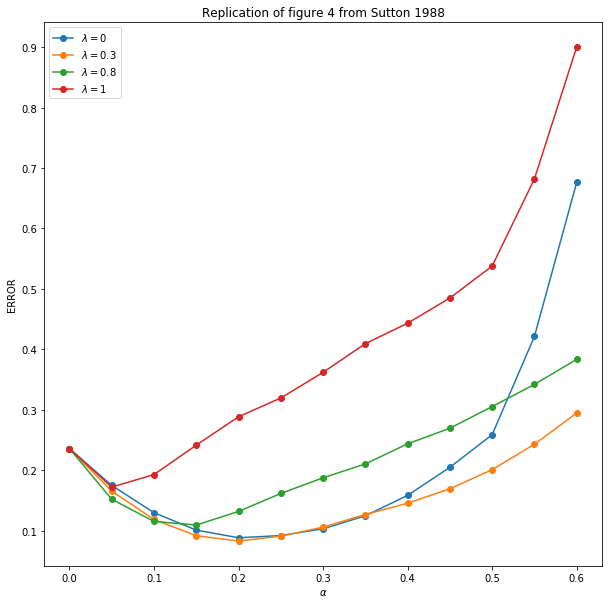

In [723]:
plt.figure(figsize=(10,10))
for key_i in average_error_exp2.keys():
    data_to_plot=np.array(average_error_exp2[key_i])
    #if key_i==99:
    #plt.plot(data_to_plot[:9,0],data_to_plot[:9,1],marker='o',label=r'$\lambda=$' +str(key_i))
    #else:
    plt.plot(data_to_plot[:,0],data_to_plot[:,1],marker='o',label=r'$\lambda=$' +str(key_i))

plt.legend()
plt.title('Replication of figure 4 from Sutton 1988')
plt.ylabel('ERROR')
plt.xlabel(r'$\alpha$')


In [724]:
# same but with more granularity in lambda levels

In [725]:
average_error_exp2=defaultdict(list)
std_error_exp2=defaultdict(list)
set_lambdas=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
set_alphas=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]

for lambdai in set_lambdas:
    #print('lambda is',lambdai)

    for alphai in set_alphas:

        training_set_errors=[]

        
        for i in range(N_training_sets):

            training_set=training_sets[i]

            w=np.ones(5)*0.5

            for sequence_i in training_set:

                TD_dic=TD_update(sequence_i,alpha=alphai,lambd=lambdai,w=w)

                w+=TD_dic['dw']


     
    
            training_set_errors.append(compute_RSME(w))

        average_error_exp2[lambdai].append((alphai,np.mean(training_set_errors)))
            
        std_error_exp2[lambdai].append((alphai,np.std(training_set_errors)))


In [726]:
lambda_error_fig5=[]
for lambda_i in average_error_exp2.keys():
    lambda_i_data=np.array(average_error_exp2[lambda_i])
    min_i=np.min(lambda_i_data[:,1])
    lambda_error_fig5.append((lambda_i,min_i))
    
lambda_error_fig5=np.array(lambda_error_fig5)

Text(0.5,0,'$\\lambda$')

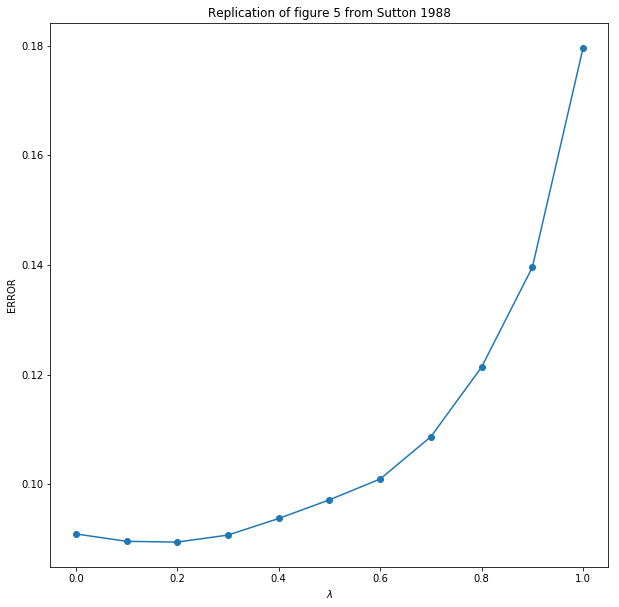

In [727]:
plt.figure(figsize=(10,10))
plt.plot(lambda_error_fig5[:,0],lambda_error_fig5[:,1],marker='o')
plt.title('Replication of figure 5 from Sutton 1988')
plt.ylabel('ERROR')
plt.xlabel(r'$\lambda$')

In [735]:
# This is for my claim of shift in optimal lambda when learning rate is smaller

In [762]:
average_error_exp2=defaultdict(list)
std_error_exp2=defaultdict(list)
set_lambdas=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
set_alphas=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]
set_alphas=np.array(set_alphas)*0.1

for lambdai in set_lambdas:
    #print('lambda is',lambdai)

    for alphai in set_alphas:

        training_set_errors=[]

        
        for i in range(N_training_sets):

            training_set=training_sets[i]

            w=np.ones(5)*0.5

            for sequence_i in training_set:

                TD_dic=TD_update(sequence_i,alpha=alphai,lambd=lambdai,w=w)

                w+=TD_dic['dw']


     
    
            training_set_errors.append(compute_RSME(w))

        average_error_exp2[lambdai].append((alphai,np.mean(training_set_errors)))
            
        std_error_exp2[lambdai].append((alphai,np.std(training_set_errors)))


lambda_error_fig5=[]
for lambda_i in average_error_exp2.keys():
    lambda_i_data=np.array(average_error_exp2[lambda_i])
    min_i=np.min(lambda_i_data[:,1])
    lambda_error_fig5.append((lambda_i,min_i))
    
lambda_error_fig5=np.array(lambda_error_fig5)



Text(0.5,0,'$\\lambda$')

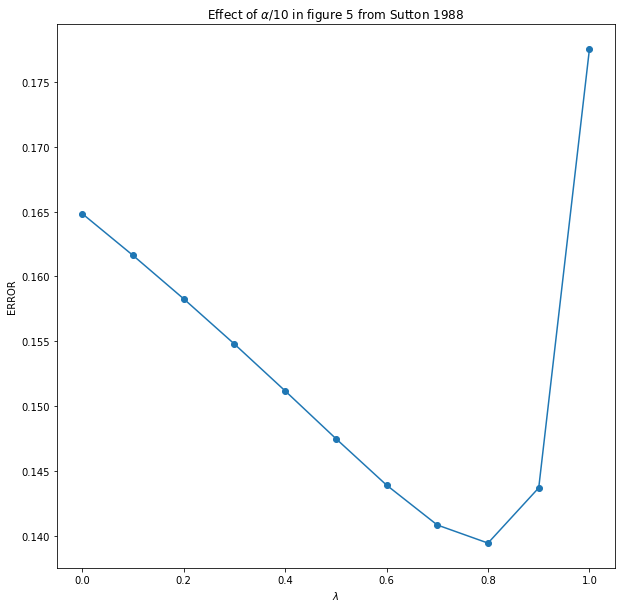

In [763]:
plt.figure(figsize=(10,10))
plt.plot(lambda_error_fig5[:,0],lambda_error_fig5[:,1],marker='o')
plt.title('Effect of '+r'$\alpha/10$'+' in figure 5 from Sutton 1988')
plt.ylabel('ERROR')
plt.xlabel(r'$\lambda$')

In [764]:
average_error_exp2=defaultdict(list)
std_error_exp2=defaultdict(list)
set_lambdas=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
set_alphas=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]
set_alphas=np.array(set_alphas)*(1/5)

for lambdai in set_lambdas:
    #print('lambda is',lambdai)

    for alphai in set_alphas:

        training_set_errors=[]

        
        for i in range(N_training_sets):

            training_set=training_sets[i]

            w=np.ones(5)*0.5

            for sequence_i in training_set:

                TD_dic=TD_update(sequence_i,alpha=alphai,lambd=lambdai,w=w)

                w+=TD_dic['dw']


     
    
            training_set_errors.append(compute_RSME(w))

        average_error_exp2[lambdai].append((alphai,np.mean(training_set_errors)))
            
        std_error_exp2[lambdai].append((alphai,np.std(training_set_errors)))


lambda_error_fig5=[]
for lambda_i in average_error_exp2.keys():
    lambda_i_data=np.array(average_error_exp2[lambda_i])
    min_i=np.min(lambda_i_data[:,1])
    lambda_error_fig5.append((lambda_i,min_i))
    
lambda_error_fig5=np.array(lambda_error_fig5)



Text(0.5,0,'$\\lambda$')

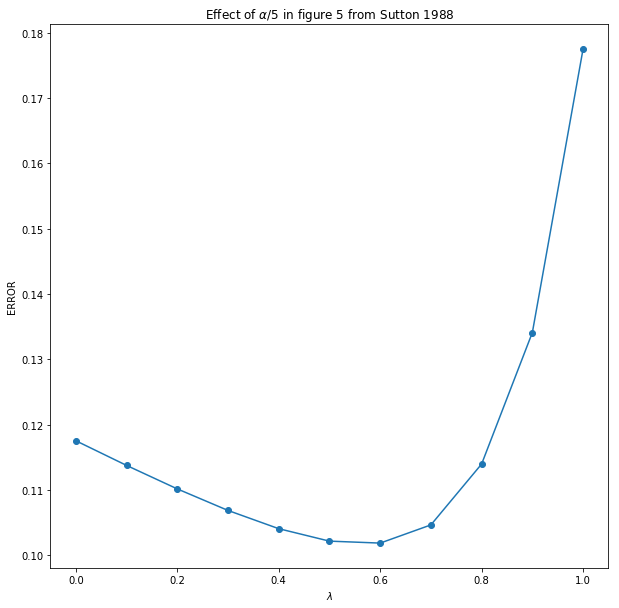

In [765]:
plt.figure(figsize=(10,10))
plt.plot(lambda_error_fig5[:,0],lambda_error_fig5[:,1],marker='o')
plt.title('Effect of '+r'$\alpha/5$'+' in figure 5 from Sutton 1988')
plt.ylabel('ERROR')
plt.xlabel(r'$\lambda$')

In [766]:
average_error_exp2=defaultdict(list)
std_error_exp2=defaultdict(list)
set_lambdas=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
set_alphas=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]
set_alphas=np.array(set_alphas)*(1/100)

for lambdai in set_lambdas:
    #print('lambda is',lambdai)

    for alphai in set_alphas:

        training_set_errors=[]

        
        for i in range(N_training_sets):

            training_set=training_sets[i]

            w=np.ones(5)*0.5

            for sequence_i in training_set:

                TD_dic=TD_update(sequence_i,alpha=alphai,lambd=lambdai,w=w)

                w+=TD_dic['dw']


     
    
            training_set_errors.append(compute_RSME(w))

        average_error_exp2[lambdai].append((alphai,np.mean(training_set_errors)))
            
        std_error_exp2[lambdai].append((alphai,np.std(training_set_errors)))


lambda_error_fig5=[]
for lambda_i in average_error_exp2.keys():
    lambda_i_data=np.array(average_error_exp2[lambda_i])
    min_i=np.min(lambda_i_data[:,1])
    lambda_error_fig5.append((lambda_i,min_i))
    
lambda_error_fig5=np.array(lambda_error_fig5)



Text(0.5,0,'$\\lambda$')

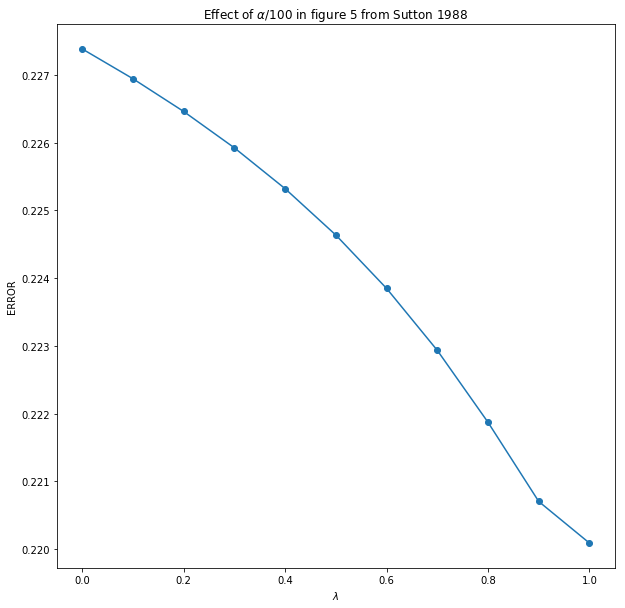

In [767]:
plt.figure(figsize=(10,10))
plt.plot(lambda_error_fig5[:,0],lambda_error_fig5[:,1],marker='o')
plt.title('Effect of '+r'$\alpha/100$'+' in figure 5 from Sutton 1988')
plt.ylabel('ERROR')
plt.xlabel(r'$\lambda$')